### Overview

The goal of this project is to predict if a customer purchased a flight package or not based on customer collected data

To do this I will:
1. Prepare a dataset
2. Train a machine learning model
3. Evaluate and present your findings

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report, precision_score, recall_score, f1_score, RocCurveDisplay, classification_report
from sklearn.inspection import permutation_importance
import joblib
from imblearn.over_sampling import SMOTENC

In [2]:
# load the data 
df = pd.read_csv('customer_booking.csv',encoding='latin-1')

### EDA

In [3]:
df.head()

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2           17        Wed  AKLDEL          India                    1   
3            4        Sat  AKLDEL    New Zealand                    0   
4           15        Wed  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_duration  \
0                     0                      0             5.52   
1                     0                      0             5.52   
2                     1                      0             5.52   
3                     0                      1             5.52   
4                     0                      1             5.52   

   booking_complete  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [4]:
df.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [5]:
df.describe()

num_passengers  purchase_lead  length_of_stay  flight_hour  \
count    50000.000000   50000.000000     50000.00000  50000.00000   
mean         1.591240      84.940480        23.04456      9.06634   
std          1.020165      90.451378        33.88767      5.41266   
min          1.000000       0.000000         0.00000      0.00000   
25%          1.000000      21.000000         5.00000      5.00000   
50%          1.000000      51.000000        17.00000      9.00000   
75%          2.000000     115.000000        28.00000     13.00000   
max          9.000000     867.000000       778.00000     23.00000   

       wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
count         50000.000000          50000.000000           50000.000000   
mean              0.668780              0.296960               0.427140   
std               0.470657              0.456923               0.494668   
min               0.000000              0.000000               0.000000   
25%               0.000000              0.000000               0.000000   
50%               1.000000              0.000000               0.000000   
75%               1.000000              1.000000               1.000000   
max               1.000000              1.000000               1.000000   

       flight_duration  booking_complete  
count     50000.000000      50000.000000  
mean          7.277561          0.149560  
std           1.496863          0.356643  
min           4.670000          0.000000  
25%           5.620000          0.000000  
50%           7.570000          0.000000  
75%           8.830000          0.000000  
max           9.500000          1.000000

In [6]:
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

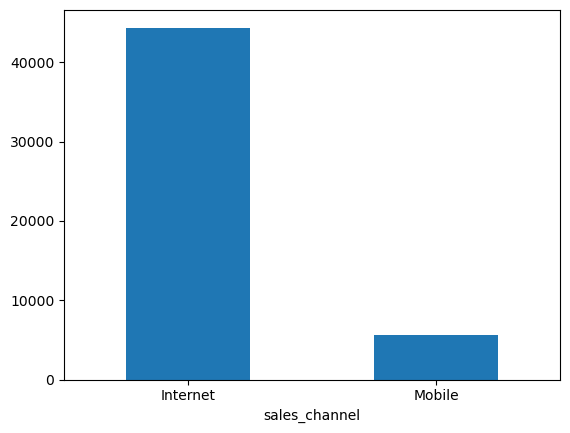

In [8]:
df['sales_channel'].value_counts(sort=False).plot.bar(rot=0);

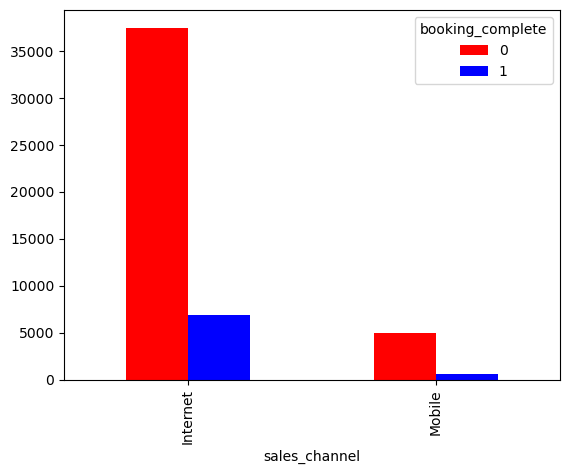

In [9]:
pd.crosstab(df.sales_channel, df.booking_complete).plot(kind='bar',
                                                        color=('red', 'blue'));

In [10]:
# # corretlation matrix
# corr_matrix = df.corr()
# fig, ax = plt.subplots(figsize=(15,10))
# ax = sns.heatmap(corr_matrix,
#                 annot=True,
#                 linewidths=0.5,
#                 fmt='.2f',
#                 cmap= 'YlGnBu');

The correlation matrix shows that there are a few features that are somewhat tied together. only a couple are linked with `booking_complete`

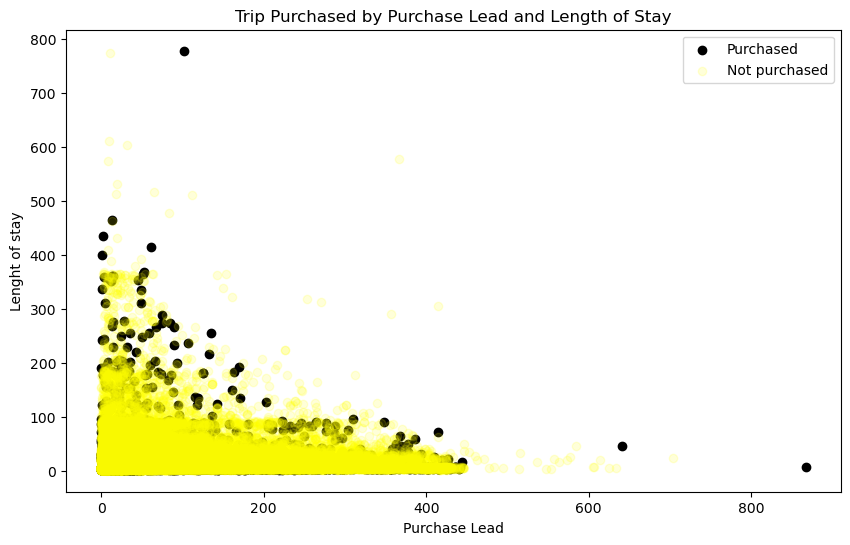

In [11]:
plt.figure(figsize=(10,6))
# scatter of purchased trips
plt.scatter(df.purchase_lead[df.booking_complete==1],
            df.length_of_stay[df.booking_complete==1],
            c='black',
            alpha = 1)
# scatter of trips not purchased
plt.scatter(df.purchase_lead[df.booking_complete==0],
            df.length_of_stay[df.booking_complete==0],
            c='yellow',
            alpha = .15)
plt.title('Trip Purchased by Purchase Lead and Length of Stay')
plt.xlabel('Purchase Lead')
plt.ylabel('Lenght of stay')
plt.legend(['Purchased', 'Not purchased']);

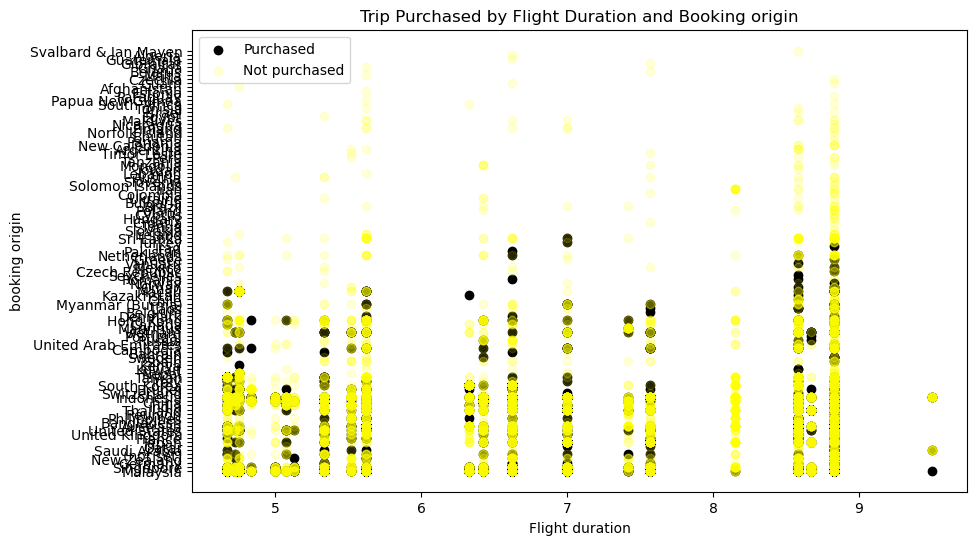

In [12]:
plt.figure(figsize=(10,6))
# scatter of purchased trips
plt.scatter(df.flight_duration[df.booking_complete==1],
            df.booking_origin[df.booking_complete==1],
            c='black',
            alpha = 1)
# scatter of trips not purchased
plt.scatter(df.flight_duration[df.booking_complete==0],
            df.booking_origin[df.booking_complete==0],
            c='yellow',
            alpha = .15)
plt.title('Trip Purchased by Flight Duration and Booking origin')
plt.xlabel('Flight duration')
plt.ylabel('booking origin')
plt.legend(['Purchased', 'Not purchased']);

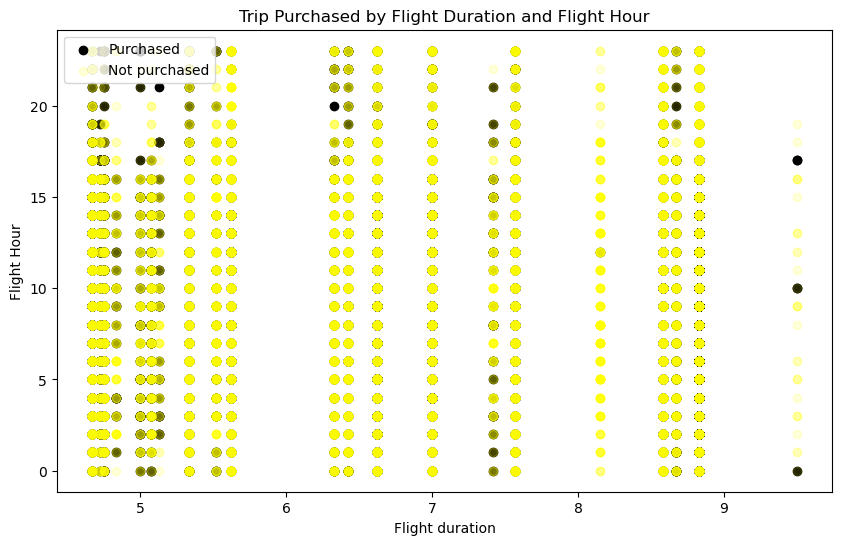

In [13]:
plt.figure(figsize=(10,6))
# scatter of purchased trips
plt.scatter(df.flight_duration[df.booking_complete==1],
            df.flight_hour[df.booking_complete==1],
            c='black',
            alpha = 1)
# scatter of trips not purchased
plt.scatter(df.flight_duration[df.booking_complete==0],
            df.flight_hour[df.booking_complete==0],
            c='yellow',
            alpha = .15)
plt.title('Trip Purchased by Flight Duration and Flight Hour')
plt.xlabel('Flight duration')
plt.ylabel('Flight Hour')
plt.legend(['Purchased', 'Not purchased']);

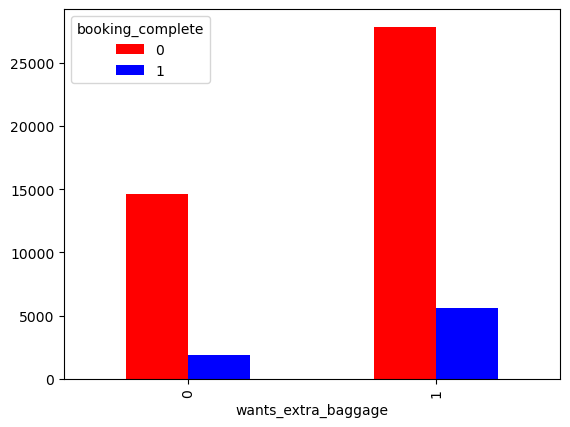

In [14]:
pd.crosstab(df.wants_extra_baggage, df.booking_complete).plot(kind='bar',
                                                        color=('red', 'blue'));

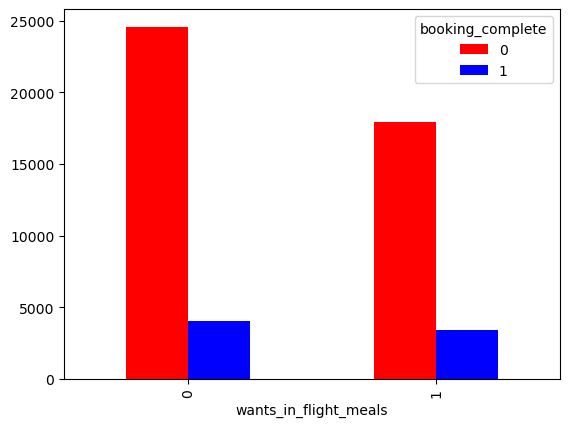

In [15]:
pd.crosstab(df.wants_in_flight_meals, df.booking_complete).plot(kind='bar',
                                                        color=('red', 'blue'));

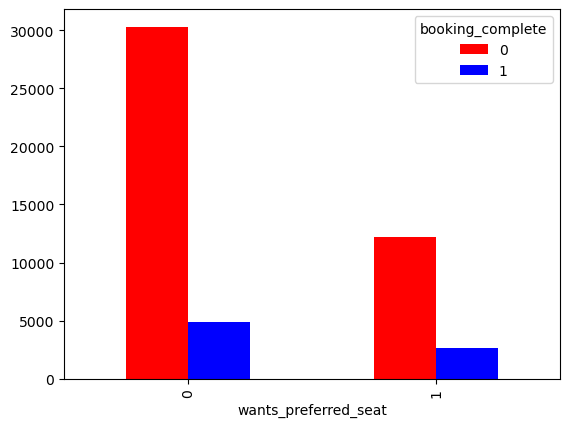

In [16]:
pd.crosstab(df.wants_preferred_seat, df.booking_complete).plot(kind='bar',
                                                        color=('red', 'blue'));

In [17]:
df.booking_complete.sum()/df.booking_complete.count()

0.14956

In [18]:
df['trip_type'].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [19]:
categorical_variables = ['sales_channel', 'trip_type', 'flight_day', 'route' ,'booking_origin','wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals','booking_complete']
df[categorical_variables] =df[categorical_variables].astype('category')
num_cols_names = ['num_passangers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

After EDA it is hard to identify features that are correlated with `booking_complete`. The data is extremely unbalanced because most of the data is skewed to not booking. This is an important point to remember when creating the model. The model by default will predict no on `booking_complete` most of the time because that is the most common answer. Only about 15% of trips are purchased. 

### Modeling

In [20]:
# split into test train split 
le  = LabelEncoder()
encoded_booking_complete = le.fit_transform(df['booking_complete'])
df.drop('booking_complete', axis = 1, inplace = True)
df['booking_complete'] = encoded_booking_complete

np.random.seed(9)
x = df.drop('booking_complete',axis = 1)
y = df['booking_complete']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, stratify = y)
x.head()
y.unique()

array([0, 1])

In [21]:
# # OneHotEncoding
# categorical_variables = ['sales_channel', 'trip_type', 'flight_day', 'route' ,'booking_origin','wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
# df[categorical_variables] =df[categorical_variables].astype('category')
# categorical_transformer = Pipeline(
#     steps=[
#         ('onehot', OneHotEncoder(handle_unknown='ignore'))
#     ]
# )
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('categorical', categorical_transformer,categorical_variables)
#     ],
#     remainder='passthrough'
# )


In [22]:
# find the columns which contain strings 
for label, content  in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

sales_channel
trip_type
flight_day
route
booking_origin


In [23]:
# Selective encoding: OrdinalEncoder and as category 
categorical_variables_ordinal = ['sales_channel','wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
as_category_variables= ['trip_type', 'flight_day', 'route', 'booking_origin']
df[categorical_variables_ordinal] =df[categorical_variables_ordinal].astype('category')

categorical_transformer = Pipeline(
    steps=[
        ('ordinal', OrdinalEncoder(handle_unknown= 'error'))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer,categorical_variables_ordinal)
    ],
    remainder='passthrough'
)

In [24]:
all_cat_variables = [categorical_variables_ordinal + as_category_variables]

In [25]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
                df[label]= content.astype('category').cat.as_ordered()
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
                df[label] = pd.Categorical(content).codes+1
df.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   num_passengers         5 non-null      int64   
 1   sales_channel          5 non-null      int8    
 2   trip_type              5 non-null      int8    
 3   purchase_lead          5 non-null      int64   
 4   length_of_stay         5 non-null      int64   
 5   flight_hour            5 non-null      int64   
 6   flight_day             5 non-null      int8    
 7   route                  5 non-null      int16   
 8   booking_origin         5 non-null      int8    
 9   wants_extra_baggage    5 non-null      category
 10  wants_preferred_seat   5 non-null      category
 11  wants_in_flight_meals  5 non-null      category
 12  flight_duration        5 non-null      float64 
 13  booking_complete       5 non-null      int64   
dtypes: category(3), float64(1), int16(1), int64(5)

In [26]:
# split into test train split 
np.random.seed(9)
x = df.drop('booking_complete',axis = 1)
y = df['booking_complete'].astype('category')

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, stratify = y)
x.head()

num_passengers  sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2              1          3            262              19   
1               1              1          3            112              20   
2               2              1          3            243              22   
3               1              1          3             96              31   
4               2              1          3             68              22   

   flight_hour  flight_day  route  booking_origin wants_extra_baggage  \
0            7           3      1              62                   1   
1            3           3      1              62                   0   
2           17           7      1              37                   1   
3            4           3      1              62                   0   
4           15           7      1              37                   1   

  wants_preferred_seat wants_in_flight_meals  flight_duration  
0                    0                     0             5.52  
1                    0                     0             5.52  
2                    1                     0             5.52  
3                    0                     1             5.52  
4                    0                     1             5.52

In [27]:
# create a dictionary of moedels 
models = {'Logistic Regression' : LogisticRegression(),
         'KNN' : KNeighborsClassifier(),
         "Random Forest" : RandomForestClassifier(),
         "AdaBoostClassifier" : AdaBoostClassifier(),
          "GradientBoostingClassifier": GradientBoostingClassifier()}

# function to train and score models 
def train_and_score(models, x_train, x_test, y_train, y_test):
    """
    fits and evaulates given machine learning models 
    models : dict of different Scikit-Learn Machine learning models 
    x_train : Training data (no labels)
    x_test: test data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # set random seed
    np.random.seed(9)
    # dictionary of model scores
    model_scores = {}
    for name, model in models.items():
        model = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('classifier', model)
            ]
        )
        
        # fit the model
        model.fit(x_train, y_train)
        # score the models and append to it to model scores
        model_scores[name] = model.score(x_test,y_test)
    return model_scores
    

In [28]:
model_scores = train_and_score(models =models,
                              x_train=x_train,
                              x_test=x_test,
                              y_train=y_train,
                              y_test=y_test)
model_scores

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.8504,
 'KNN': 0.8324,
 'Random Forest': 0.8533,
 'AdaBoostClassifier': 0.8499,
 'GradientBoostingClassifier': 0.8491}

Output of above wit: {'Logistic Regression': 0.8497,
 'KNN': 0.8357,
 'Random Forest': 0.8477,
 'AdaBoostClassifier': 0.8479,
 'GradientBoostingClassifier': 0.8507}

All these scores are misleading becaosue of the imbalenced data. All models are mostly selecting for the majority class. 

### Hyperparameter Tunning

In [29]:
# %%time
# # KNN tunning
# knn_train_scores = []
# knn_test_scores = []

# # list of neighbors 
# neighbors = range(1,20)
# # set up model
# knn = KNeighborsClassifier()
# # loop through different neighbors 
# for i in neighbors:
#     knn.set_params(n_neighbors = i)
#     # train
#     knn.fit(x_train,y_train)
#     # update train score lits
#     knn_train_scores.append(knn.score(x_train,y_train))
#     # update the test scores
#     knn_test_scores.append(knn.score(x_test, y_test))

In [30]:
# knn_train_scores, knn_test_scores

In [31]:
# plt.plot(neighbors, knn_train_scores,label='Train Score')
# plt.plot(neighbors, knn_test_scores, label='Test Score')
# plt.xticks(np.arange(1, 20, 1))
# plt.xlabel('Number of Neighbors', rotation=0)
# plt.ylabel('Model Score')
# plt.legend()

# print(f"Maximum KNN score on the test data: {max(knn_test_scores)*100:.2f}%")

Using ~10 neighbors the max KNN test score is 84% after hypertunning. This is about the same as the other models before hypertunning. Time to try tunning the other models and abandon the KNN model.  

In [32]:
 # Create a hyperparameter grid for LogisticRegression()
 np.random.seed(9)
 log_reg_grid = {'C': np.logspace(-4,4,20),
                'solver': ['liblinear','newton-cholesky']}
 #create a hyperparameter grid for RandomForsetClassifier
 rf_grid = {'n_estimators': np.arange(10,1000,50),
           "max_depth": [None, 3, 5,10],
           'min_samples_split': np.arange(2,20,2),
           'min_samples_leaf': np.arange(1,20,2)}
# create a hyperparameter grid for AdaBoostClassifier
ada_grid = {'n_estimators': np.arange(10,1000,50),
             'algorithm': ['SAMME', 'SAMME.R']} 
# create a hyperparameter grid for GradientBoostingClassifier
gb_grid = {'n_estimators': np.arange(10,1000,50),
             "max_depth": [None, 3, 5,10],
             'min_samples_split': np.arange(2,20,2),
             'min_samples_leaf': np.arange(1,20,2),
            'loss': ['log_loss', 'exponential']}

In [33]:
# Tune LogisticRegression

np.random.seed(9)
#setup reandom hyperparameter search for LogisticRegrssion
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                               param_distributions=log_reg_grid,
                               cv=5,
                               n_iter=20,
                               verbose=True)
#fit random Hyperpameter search model for logistic regression
rs_log_reg.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear',
                                                   'newton-cholesky']},
                   verbose=True)

In [34]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 1.623776739188721}

In [35]:
rs_log_reg.score(x_test,y_test)

0.8504

In [36]:
%%time
# setup random seed 
np.random.seed(9)

#setup random hyperparameter grid 
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                          param_distributions=rf_grid,
                          cv=5,
                          n_iter=20,
                          verbose=True)
rs_rf.fit(x_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 14min 38s, sys: 15.1 s, total: 14min 53s
Wall time: 17min 50s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [37]:
#FInd the best hyperparameters
rs_rf.best_params_

{'n_estimators': 110,
 'min_samples_split': 4,
 'min_samples_leaf': 5,
 'max_depth': None}

In [38]:
# Evaluate the randomizedFirestClassifier 
rs_rf.score(x_test,y_test)

0.8521

In [39]:
# %%time
# # setup random seed 
# np.random.seed(9)

# #setup random hyperparameter grid 
# rs_ada = RandomizedSearchCV(AdaBoostClassifier(),
#                           param_distributions=ada_grid,
#                           cv=5,
#                           n_iter=20,
#                           verbose=True)
# rs_ada.fit(x_train,y_train)

In [40]:
# rs_ada.best_params_

In [41]:
# rs_ada.score(x_test,y_test)

In [42]:
# %%time
# # setup random seed 
# np.random.seed(9)

# #setup random hyperparameter grid 
# rs_gb = RandomizedSearchCV(GradientBoostingClassifier(),
#                           param_distributions=gb_grid,
#                           cv=5,
#                           n_iter=20,
#                           verbose=True)
# rs_gb.fit(x_train,y_train)

In [43]:
# rs_gb.best_params_

In [44]:
# rs_gb.score(x_test,y_test)

In [45]:
joblib.dump(rs_log_reg, 'rs_log_reg.joblib')
joblib.dump(rs_rf, 'rs_rf.joblib')
# joblib.dump(rs_ada, 'rs_ada.joblib')
# joblib.dump(rs_gb, 'rs_gb.joblib')

['rs_rf.joblib']

In [46]:
log = joblib.load('rs_log_reg.joblib')
rf = joblib.load('rs_rf.joblib')
# ada = joblib.load('rs_ada.joblib')
# gb = joblib.load('rs_gb.joblib')

In [47]:
log.score(x_test,y_test)

0.8504

In [48]:
rf.score(x_test,y_test)

0.8521

In [49]:
ada.score(x_test,y_test)

In [50]:
gb.score(x_test,y_test)

In [51]:
y_preds_log = rs_log_reg.predict(x_test)
y_preds_rf = rf.predict(x_test)
y_preds_ada = ada.predict(x_test)
y_preds_gb = gb.predict(x_test)

In [52]:
y_test

10300    0
30640    0
16856    0
29465    0
30876    0
        ..
26338    1
19877    0
21971    1
44145    1
21756    0
Name: booking_complete, Length: 10000, dtype: category
Categories (2, int64): [0, 1]

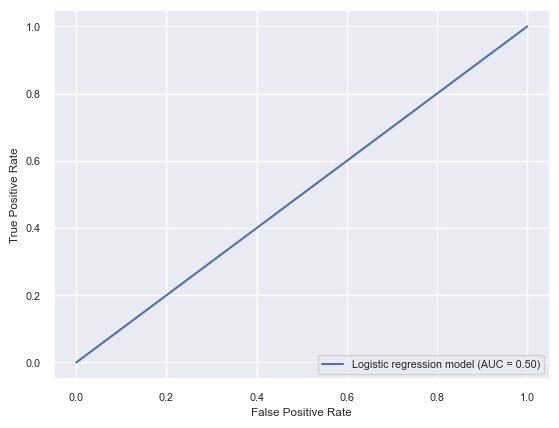

In [173]:
# Plot ROC curve and calculate AUC metric
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds_log, pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
display = metrics.RocCurveDisplay(fpr=fpr,
                                 tpr=tpr,
                                 roc_auc=roc_auc,
                                 estimator_name = 'Logistic regression model')
display.plot();

In [54]:
print(classification_report(y_test,y_preds_log))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8504
           1       0.00      0.00      0.00      1496

    accuracy                           0.85     10000
   macro avg       0.43      0.50      0.46     10000
weighted avg       0.72      0.85      0.78     10000



/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
# Confuision matrix 
print(confusion_matrix(y_test,y_preds_log))

[[8504    0]
 [1496    0]]


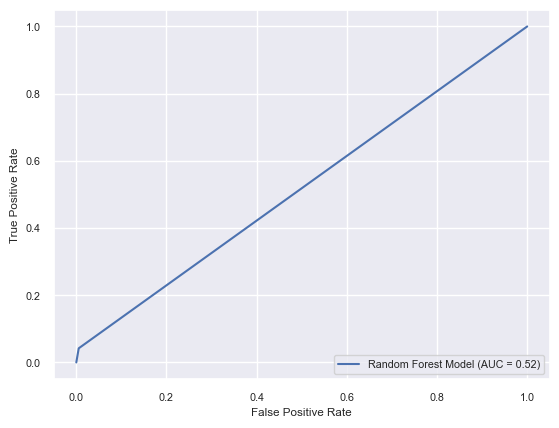

In [174]:
# Plot ROC curve and calculate AUC metric
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds_rf,pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
display = metrics.RocCurveDisplay(fpr=fpr,
                                 tpr=tpr,
                                 roc_auc=roc_auc,
                                 estimator_name = 'Random Forest Model')
display.plot();

In [177]:
# # Plot ROC curve and calculate AUC metric
# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds_ada_pos, label=1)
# roc_auc = metrics.auc(fpr,tpr)
# display = metrics.RocCurveDisplay(fpr=fpr,
#                                  tpr=tpr,
#                                  roc_auc=roc_auc,
#                                  estimator_name = 'ADA boost model')
# display.plot();

In [178]:
# # Plot ROC curve and calculate AUC metric
# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds_gb,pos_label=1)
# roc_auc = metrics.auc(fpr,tpr)
# display = metrics.RocCurveDisplay(fpr=fpr,
#                                  tpr=tpr,
#                                  roc_auc=roc_auc,
#                                  estimator_name = 'Gradient Boost Model')
# display.plot();

In [59]:
print(classification_report(y_test,y_preds_log)), print(classification_report(y_test,y_preds_rf)), #print(classification_report(y_test,y_preds_ada)), print(classification_report(y_test,y_preds_gb))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8504
           1       0.00      0.00      0.00      1496

    accuracy                           0.85     10000
   macro avg       0.43      0.50      0.46     10000
weighted avg       0.72      0.85      0.78     10000

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8504
           1       0.58      0.04      0.08      1496

    accuracy                           0.85     10000
   macro avg       0.72      0.52      0.50     10000
weighted avg       0.81      0.85      0.79     10000



/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(None, None)

In [60]:
# Confuision matrix 
print(confusion_matrix(y_test,y_preds_log))
print(confusion_matrix(y_test, y_preds_rf))
# print(confusion_matrix(y_test, y_preds_ada)) 
# print(confusion_matrix(y_test,y_preds_gb))

[[8504    0]
 [1496    0]]
[[8458   46]
 [1433   63]]


the imbalanced dataset made all of the models score poorly in the minority class. Need to rework the models to actually account for the imbalance. The high accuracy score was misleading.

In [61]:
# categorical_variables = ['sales_channel', 'trip_type', 'flight_day', 'route' ,'booking_origin','wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',	'flight_duration']
# categorical_variables = df[categorical_variables].astype('category')
# ohc_feats = pd.get_dummies(categorical_variables,drop_first=True)
# ohc_feats.info()

In [62]:
# num_cols = ['num_passengers', 'purchase_lead', 'length_of_stay','flight_hour']
# ohc_target = df['booking_complete'].astype('category')
# ohc_target.info

In [65]:
# ohc_data = pd.concat([df[num_cols], ohc_feats, ohc_target],axis=1)

In [66]:
# ohc_feats = pd.get_dummies(categorical_variables,drop_first=True)
# ohc_feats.info()

In [67]:
# ohc_data.head()[::-5]

In [68]:
# np.random.seed(9)
# x = ohc_data.drop('booking_complete',axis = 1)
# y = ohc_data['booking_complete']

# x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, stratify = y)

In [69]:
# cat_col_index = list(range(len(num_cols),936))
# smote_nc = SMOTENC(categorical_features = cat_col_index,sampling_strategy= .6,random_state = 9)
# x_train_resampled, y_train_resampled = smote_nc.fit_resample(x_train,y_train)

In [70]:
%%time
cat_col_index = list(range(len(num_cols_names), 12))
sm = SMOTENC(categorical_features=cat_col_index,random_state=9, sampling_strategy=1)
x_train_resample, y_train_resample = sm.fit_resample(x_train,y_train)

/Users/kolegraham/.local/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


CPU times: user 15.8 s, sys: 1.57 s, total: 17.3 s
Wall time: 17.2 s


In [71]:
%%time
clf = RandomForestClassifier(random_state = 9)
clf.fit(x_train_resample,y_train_resample)
clf.score(x_test,y_test)

CPU times: user 8.61 s, sys: 164 ms, total: 8.77 s
Wall time: 9.45 s


0.8068

In [72]:
y_preds_resampled_rf = clf.predict(x_test)

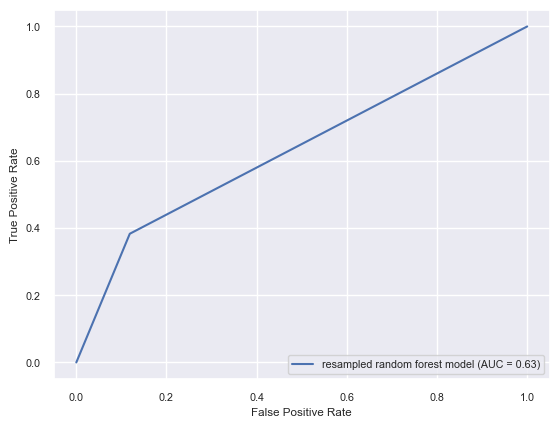

In [179]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds_resampled_rf,pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
display = metrics.RocCurveDisplay(fpr=fpr,
                                 tpr=tpr,
                                 roc_auc=roc_auc,
                                 estimator_name = 'resampled random forest model')
display.plot();

In [74]:
print(confusion_matrix(y_test,y_preds_resampled_rf))

[[7495 1009]
 [ 923  573]]


In [75]:
joblib.dump(clf,'random_forest_classifier_resampled_custom_encoding.joblib')

['random_forest_classifier_resampled_custom_encoding.joblib']

(0.36219974715549935, 0.3830213903743315, 0.3723196881091618)

%%time
clf = RandomForestClassifier(random_state = 9)
clf.fit(x_train_resample,y_train_resample)
clf.score(x_test,y_test)

In [78]:
%%time
# # setup random seed 
np.random.seed(9)

#setup random hyperparameter grid 
resampled_tuned_rs_rf = RandomizedSearchCV(clf,
                                     param_distributions=rf_grid, cv=5,
                                     n_iter=20,
                                     verbose=True)
resampled_tuned_rs_rf.fit(x_train_resample,y_train_resample)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 26min 34s, sys: 35.6 s, total: 27min 9s
Wall time: 32min 3s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=9),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

output: Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 26min 17s, sys: 30.6 s, total: 26min 48s
Wall time: 54min 21s

In [79]:
resampled_tuned_rs_rf.best_params_

{'n_estimators': 110,
 'min_samples_split': 4,
 'min_samples_leaf': 5,
 'max_depth': None}

output: {'n_estimators': 110,
 'min_samples_split': 4,
 'min_samples_leaf': 5,
 'max_depth': None}

In [80]:
resampled_tuned_rs_rf.score(x_test,y_test)

0.788

In [81]:
y_preds_tuned_resampled_rf = resampled_tuned_rs_rf.predict(x_test)

In [82]:
print(classification_report(y_test,y_preds_tuned_resampled_rf))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      8504
           1       0.34      0.44      0.38      1496

    accuracy                           0.79     10000
   macro avg       0.62      0.64      0.63     10000
weighted avg       0.81      0.79      0.80     10000



In [202]:
Metrics = {'Precision' : precision_score(y_test,y_preds_tuned_resampled_rf),
           'Recall' : recall_score(y_test,y_preds_tuned_resampled_rf), 
           'F1' : f1_score(y_test,y_preds_tuned_resampled_rf)}
names = list(Metrics.keys())
height = list(Metrics.values())

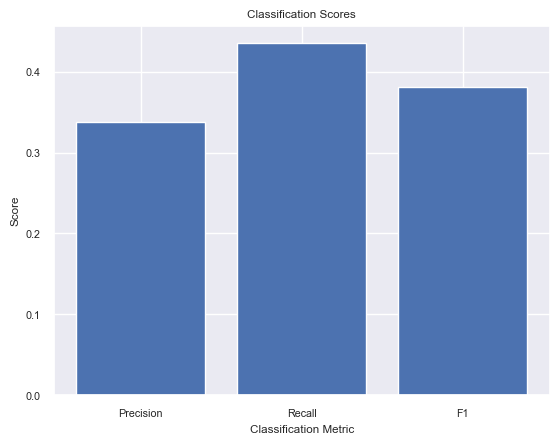

In [216]:
fig, ax = plt.subplots()
ax.bar(x = range(len(Metrics)),
      height = height,
      tick_label = names)
ax.set_title('Classification Scores')
plt.xlabel('Classification Metric')
plt.ylabel('Score')
plt.show()

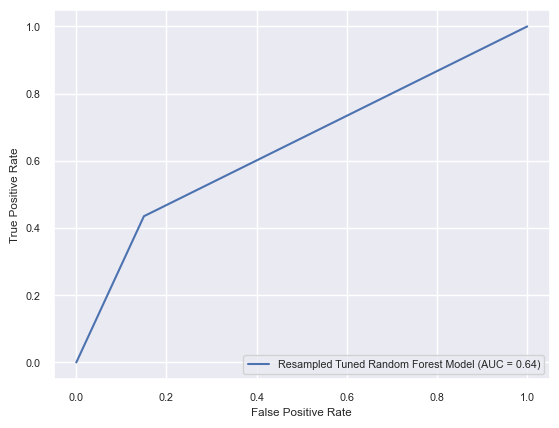

In [180]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds_tuned_resampled_rf,pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
display = metrics.RocCurveDisplay(fpr=fpr,
                                 tpr=tpr,
                                 roc_auc=roc_auc,
                                 estimator_name = 'Resampled Tuned Random Forest Model')
display.plot();

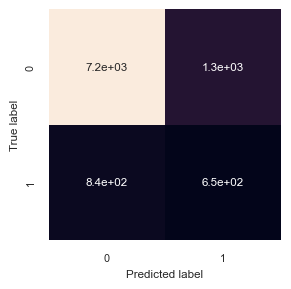

In [172]:
def plot_conf_mat(y_test,y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    sns.set(font_scale=.7)
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test,  y_preds_tuned_resampled_rf),
                    annot=True,
                    cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    
plot_conf_mat(y_test, y_preds_tuned_resampled_rf)

In [92]:
joblib.dump(resampled_tuned_rs_rf, 'resampled_tuned_rs_rf.joblib')

['resampled_tuned_rs_rf.joblib']

In [93]:
feature_names = list(df.columns)
feature_names.remove('booking_complete')
print(feature_names)

['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration']


In [95]:
%%time 
result = permutation_importance(resampled_tuned_rs_rf, x_test,y_test,n_repeats=10, random_state=9,n_jobs=-1)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

CPU times: user 3.73 s, sys: 5.06 s, total: 8.79 s
Wall time: 52.2 s


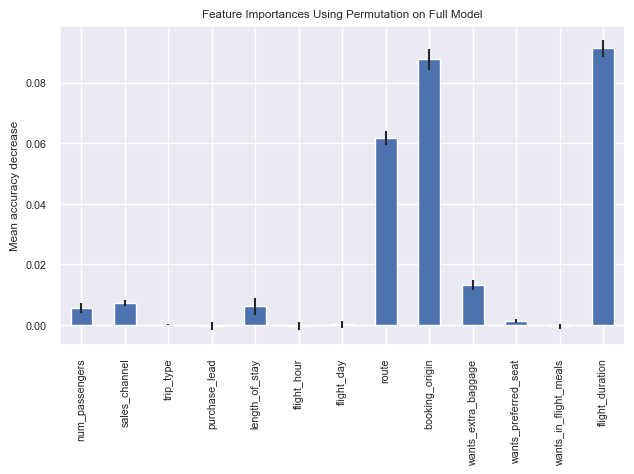

In [206]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation on Full Model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show();

The data still shows very  little correlation between the results and features. 

In [98]:
%%time
svc = SVC(verbose=True, random_state=9)
accuracies = cross_val_score(svc, x_train_resample,y_train_resample,cv=5)
svc.fit(x_train_resample,y_train_resample)

print('Train Score:',np.mean(accuracies))
print('Test Score:',svc.score(x_test,y_test))

[LibSVM]...........................
*.
*.
*
optimization finished, #iter = 29551
obj = -42356.599120, rho = -9.728769
nSV = 44502, nBSV = 44446
Total nSV = 44502
[LibSVM]...........................
*.
*..
*
optimization finished, #iter = 30370
obj = -42756.635397, rho = -8.999610
nSV = 44699, nBSV = 44650
Total nSV = 44699
[LibSVM]...........................
*.
*.
*
optimization finished, #iter = 29244
obj = -42718.228615, rho = -9.055102
nSV = 44689, nBSV = 44632
Total nSV = 44689
[LibSVM]...........................
*.
*.
*
optimization finished, #iter = 28996
obj = -42711.005691, rho = -9.234255
nSV = 44662, nBSV = 44612
Total nSV = 44662
[LibSVM]...........................
*..
*.
*
optimization finished, #iter = 30121
obj = -42785.821401, rho = -9.066468
nSV = 44689, nBSV = 44641
Total nSV = 44689
[LibSVM]..................................
*..
*...
*.
*
optimization finished, #iter = 38849
obj = -52809.358074, rho = -10.430746
nSV = 55290, nBSV = 55236
Total nSV = 55290
Train Score:

In [100]:
svc_y_preds = svc.predict(x_test)

In [101]:
print(classification_report(y_test,svc_y_preds))

              precision    recall  f1-score   support

           0       0.91      0.52      0.66      8504
           1       0.20      0.69      0.32      1496

    accuracy                           0.55     10000
   macro avg       0.56      0.61      0.49     10000
weighted avg       0.80      0.55      0.61     10000



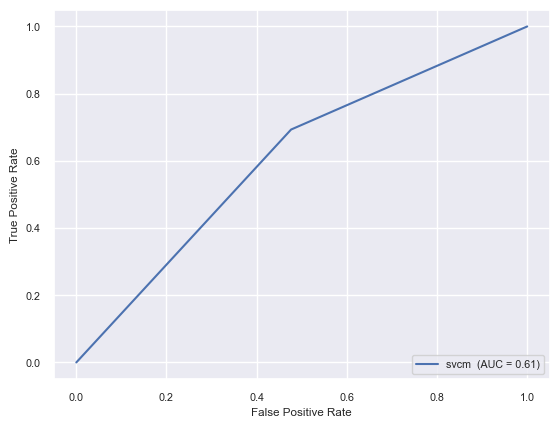

In [102]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, svc_y_preds)
roc_auc = metrics.auc(fpr,tpr)
display = metrics.RocCurveDisplay(fpr=fpr,
                                 tpr=tpr,
                                 roc_auc=roc_auc,
                                 estimator_name = 'svcm ')
display.plot();

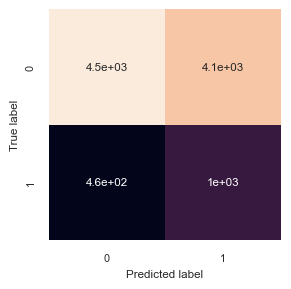

In [103]:
plot_conf_mat(y_test,svc_y_preds)

In [104]:
joblib.dump(svc, 'svc_resample.joblib')

['svc_resample.joblib']

In [123]:
from sklearn.neural_network import MLPClassifier

In [153]:
%%time
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),
    max_iter=200,
    alpha=1e-4,
    solver="lbfgs",
    random_state=9)

CPU times: user 26 µs, sys: 1 µs, total: 27 µs
Wall time: 32.2 µs


In [154]:
%%time
mlp.fit(x_train_resample,y_train_resample)

CPU times: user 38.1 s, sys: 2.59 s, total: 40.7 s
Wall time: 27.8 s


/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(random_state=9, solver='lbfgs')

In [155]:
y_preds_mlp_resample = mlp.predict(x_test)

In [156]:
print(classification_report(y_test,y_preds_mlp_resample))

              precision    recall  f1-score   support

           0       0.90      0.64      0.75      8504
           1       0.22      0.58      0.32      1496

    accuracy                           0.64     10000
   macro avg       0.56      0.61      0.54     10000
weighted avg       0.80      0.64      0.69     10000



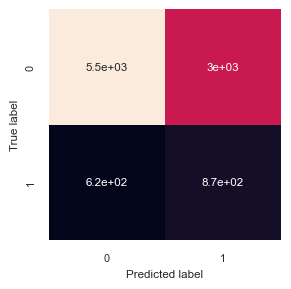

In [170]:
plot_conf_mat(y_test, y_preds_mlp_resample)

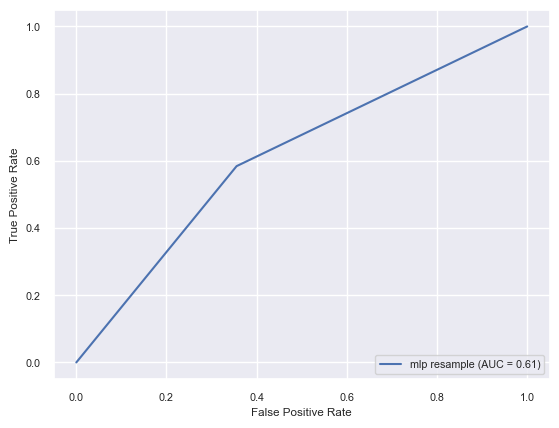

In [157]:
y_preds_mlp = mlp.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds_mlp)
roc_auc = metrics.auc(fpr,tpr)
display = metrics.RocCurveDisplay(fpr=fpr,
                                 tpr=tpr,
                                 roc_auc=roc_auc,
                                 estimator_name = 'mlp resample')
display.plot();

In [160]:
joblib.dump(mlp,'mlp.joblib')

['mlp.joblib']

In [159]:
mlp_grid ={'activation' :['identity', 'logistic', 'tanh', 'relu'],
           'hidden_layer_sizes' : [(100,),(50,),(10,)],
           'max_iter' :[200, 300],
           'solver' : ['lbfgs', 'sgd','adam']}
           

In [165]:
%%time 
mlp_grid = GridSearchCV(estimator= MLPClassifier(verbose=True, random_state=9), param_grid=mlp_grid, verbose=1, cv=5, n_jobs=-1)
mlp_grid.fit(x_train_resample, y_train_resample)
print(mlp_grid.best_estimator_)
y_preds_mlp_tuned = mlp_grid.predict(x_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05519D+01    |proj g|=  4.16817D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05763D+01    |proj g|=  4.17040D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05360D+01    |proj g|=  4.14512D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06153D+01    |proj g|=  4.18534D+01


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    1    f=  5.48142D+00    |proj g|=  2.60310D+01

At iterate    1    f=  5.49471D+00    |proj g|=  2.61923D+01

At iterate    1    f=  5.50025D+00    |proj g|=  2.59639D+01

At iterate    1    f=  5.50888D+00    |proj g|=  2.61144D+01

At iterate    2    f=  4.33651D+00    |proj g|=  7.99009D+00

At iterate    2    f=  4.33000D+00    |proj g|=  8.39566D+00

At iterate    2    f=  4.36204D+00    |proj g|=  7.94175D+00

At iterate    2    f=  4.36435D+00    |proj g|=  8.08403D+00

At iterate    3    f=  3.55439D+00    |proj g|=  1.76632D+01

At iterate    3    f=  3.50051D+00    |proj g|=  1.29438D+01

At iterate    3    f=  3.61021D+00    |proj g|=  2.00398D+01

At iterate    3    f=  3.56747D+00    |proj g|=  1.71559D+01

At iterate    4    f=  2.39533D+00    |proj g|=  8.39495D+00

At iterate    4    f=  2.40957D+00    |proj g|=  1.19621D+01

At iterate    4    f=  2.46778D+00    |proj g|=  1.21790D+01

At iterate    4    f=  2.38747D+00    |proj g|=  6.81587D+00

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  197    f=  6.06610D-01    |proj g|=  9.72811D-02

At iterate  190    f=  6.31197D-01    |proj g|=  4.82515D-02

At iterate  195    f=  6.32522D-01    |proj g|=  1.57174D-01

At iterate  198    f=  6.06608D-01    |proj g|=  1.03075D-01

At iterate  191    f=  6.31196D-01    |proj g|=  2.11785D-02

At iterate  196    f=  6.32516D-01    |proj g|=  2.16448D-01

At iterate  199    f=  6.06591D-01    |proj g|=  6.91784D-02

At iterate  192    f=  6.31196D-01    |proj g|=  1.64405D-02

At iterate  197    f=  6.32506D-01    |proj g|=  2.01209D-01

At iterate  200    f=  6.06575D-01    |proj g|=  1.74343D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06030D+01    |proj g|=  4.18188D+01

At iterate  199    f=  6.32440D-01    |proj g|=  1.95942D-02

At iterate  194    f=  6.31193D-01    |proj g|=  2.65899D-02

At iterate  200    f=  6.32397D-01    |proj g|=  1.63423D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1501    200    234      1     0     0   1.634D-01   6.324D-01
  F =  0.63239657088709289     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 



/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  195    f=  6.31191D-01    |proj g|=  3.25719D-02

At iterate  196    f=  6.31190D-01    |proj g|=  3.25419D-02

At iterate  197    f=  6.31187D-01    |proj g|=  2.35866D-02

At iterate    1    f=  5.50719D+00    |proj g|=  2.61273D+01

At iterate  198    f=  6.31184D-01    |proj g|=  2.57464D-02

At iterate    2    f=  4.35835D+00    |proj g|=  8.16182D+00

At iterate  199    f=  6.31176D-01    |proj g|=  1.07297D-01

At iterate  200    f=  6.31164D-01    |proj g|=  7.53960D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1501    200    241      1     0     0   7.540D-02   6.312D-01
  F =  0.6311640948682

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate    4    f=  2.37607D+00    |proj g|=  4.91808D+00

At iterate    5    f=  2.25733D+00    |proj g|=  4.57929D+00

At iterate    6    f=  1.67178D+00    |proj g|=  4.78680D+00

At iterate    7    f=  1.32423D+00    |proj g|=  4.63543D+00

At iterate    8    f=  1.04406D+00    |proj g|=  3.02666D+00

At iterate    9    f=  8.36227D-01    |proj g|=  2.54520D+00

At iterate   10    f=  8.14070D-01    |proj g|=  1.81158D+00

At iterate   11    f=  8.12637D-01    |proj g|=  1.26469D+00

At iterate   12    f=  8.11282D-01    |proj g|=  5.05769D-01

At iterate   13    f=  8.08085D-01    |proj g|=  1.53971D+00

At iterate   14    f=  7.92259D-01    |proj g|=  5.53538D+00

At iterate   15    f=  7.69661D-01    |proj g|=  8.55360D+00

At iterate   16    f=  7.42646D-01    |proj g|=  8.18184D+00

At iterate   17    f=  7.26419D-01    |proj g|=  1.38139D+00

At iterate   18    f=  7.24794D-01    |proj g|=  2.18729D-01

At iterate   19    f=  7.24664D-01    |proj g|=  5.36130D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05360D+01    |proj g|=  4.14512D+01


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05763D+01    |proj g|=  4.17040D+01


 This problem is unconstrained.



At iterate    1    f=  5.49471D+00    |proj g|=  2.61923D+01

At iterate    2    f=  4.33000D+00    |proj g|=  8.39566D+00

At iterate    3    f=  3.50051D+00    |proj g|=  1.29438D+01

At iterate    1    f=  5.50025D+00    |proj g|=  2.59639D+01

At iterate    4    f=  2.40957D+00    |proj g|=  1.19621D+01

At iterate    2    f=  4.36204D+00    |proj g|=  7.94175D+00

At iterate    5    f=  2.33088D+00    |proj g|=  6.95814D+00

At iterate    6    f=  2.26939D+00    |proj g|=  7.35456D+00

At iterate    3    f=  3.61021D+00    |proj g|=  2.00398D+01

At iterate    7    f=  1.85597D+00    |proj g|=  7.27681D+00

At iterate    8    f=  1.48302D+00    |proj g|=  7.19436D+00

At iterate    4    f=  2.46778D+00    |proj g|=  1.21790D+01

At iterate    9    f=  1.14517D+00    |proj g|=  3.18698D+00

At iterate    5    f=  2.24898D+00    |proj g|=  1.05473D+01

At iterate    6    f=  1.89894D+00    |proj g|=  1.70810D+01

At iterate   10    f=  9.55513D-01    |proj g|=  5.41786D+00

At iter

 This problem is unconstrained.



At iterate   27    f=  7.26415D-01    |proj g|=  2.89783D-01

At iterate   31    f=  7.13888D-01    |proj g|=  5.18281D+00

At iterate   28    f=  7.26033D-01    |proj g|=  2.54659D-01

At iterate   32    f=  7.04508D-01    |proj g|=  4.58008D+00

At iterate   29    f=  7.25249D-01    |proj g|=  2.97915D-01

At iterate   33    f=  6.94662D-01    |proj g|=  2.19621D+00

At iterate   30    f=  7.24617D-01    |proj g|=  5.08824D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06153D+01    |proj g|=  4.18534D+01

At iterate   34    f=  6.90467D-01    |proj g|=  1.45828D+00


 This problem is unconstrained.



At iterate   31    f=  7.23109D-01    |proj g|=  8.23035D-01

At iterate   35    f=  6.89396D-01    |proj g|=  1.85421D+00

At iterate    1    f=  5.48142D+00    |proj g|=  2.60310D+01

At iterate   32    f=  7.19163D-01    |proj g|=  1.45406D+00

At iterate   36    f=  6.88183D-01    |proj g|=  1.42316D+00

At iterate   33    f=  7.11200D-01    |proj g|=  2.35560D+00

At iterate   37    f=  6.86670D-01    |proj g|=  1.51009D+00

At iterate    2    f=  4.33651D+00    |proj g|=  7.99009D+00

At iterate   34    f=  6.99228D-01    |proj g|=  3.14878D+00

At iterate   35    f=  6.87877D-01    |proj g|=  2.16237D+00

At iterate   38    f=  6.84936D-01    |proj g|=  4.98056D-01

At iterate   36    f=  6.83512D-01    |proj g|=  1.13436D+00

At iterate    3    f=  3.55439D+00    |proj g|=  1.76632D+01

At iterate   39    f=  6.84231D-01    |proj g|=  3.65054D-01

At iterate    1    f=  5.50888D+00    |proj g|=  2.61144D+01

At iterate   40    f=  6.84086D-01    |proj g|=  7.58366D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  235    f=  6.29666D-01    |proj g|=  7.20953D-02

At iterate  266    f=  6.28211D-01    |proj g|=  9.78811D-02

At iterate  221    f=  6.30977D-01    |proj g|=  2.86206D-01

At iterate  270    f=  6.05947D-01    |proj g|=  3.06808D-02

At iterate  236    f=  6.29552D-01    |proj g|=  3.15318D-01

At iterate  222    f=  6.30891D-01    |proj g|=  2.17806D-01

At iterate  237    f=  6.29372D-01    |proj g|=  4.20070D-01

At iterate  271    f=  6.05935D-01    |proj g|=  6.35677D-02

At iterate  267    f=  6.28093D-01    |proj g|=  5.80814D-01

At iterate  223    f=  6.30800D-01    |proj g|=  9.80930D-02

At iterate  272    f=  6.05901D-01    |proj g|=  1.85304D-01

At iterate  238    f=  6.28932D-01    |proj g|=  4.59913D-01

At iterate  268    f=  6.27732D-01    |proj g|=  2.03427D-01

At iterate  273    f=  6.05871D-01    |proj g|=  2.36112D-01

At iterate  224    f=  6.30675D-01    |proj g|=  1.27713D-01

At iterate  269    f=  6.27656D-01    |proj g|=  1.94452D-01

At itera

 This problem is unconstrained.
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate    1    f=  5.50719D+00    |proj g|=  2.61273D+01

At iterate  273    f=  6.25831D-01    |proj g|=  8.49253D-03

At iterate  258    f=  6.25095D-01    |proj g|=  3.35090D-02

At iterate    2    f=  4.35835D+00    |proj g|=  8.16182D+00

At iterate  259    f=  6.25084D-01    |proj g|=  1.88770D-02

At iterate  274    f=  6.25831D-01    |proj g|=  1.22433D-02

At iterate  275    f=  6.25831D-01    |proj g|=  1.27307D-02

At iterate    3    f=  3.54432D+00    |proj g|=  1.57684D+01

At iterate  260    f=  6.25083D-01    |proj g|=  1.07055D-01

At iterate  276    f=  6.25830D-01    |proj g|=  9.59288D-03

At iterate  261    f=  6.25078D-01    |proj g|=  4.41564D-02

At iterate  277    f=  6.25828D-01    |proj g|=  4.86579D-02

At iterate    4    f=  2.37607D+00    |proj g|=  4.91808D+00

At iterate  262    f=  6.25075D-01    |proj g|=  2.66711D-02

At iterate    5    f=  2.25733D+00    |proj g|=  4.57929D+00

At iterate  263    f=  6.25071D-01    |proj g|=  1.44658D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


te   25    f=  7.07681D-01    |proj g|=  4.11300D+00

At iterate  282    f=  6.25043D-01    |proj g|=  6.22736D-02

At iterate  296    f=  6.25633D-01    |proj g|=  3.83870D-02

At iterate   26    f=  6.94432D-01    |proj g|=  4.06434D+00

At iterate  283    f=  6.25040D-01    |proj g|=  4.75926D-02

At iterate  297    f=  6.25625D-01    |proj g|=  1.29202D-01

At iterate   27    f=  6.85585D-01    |proj g|=  1.81053D+00

At iterate  284    f=  6.25034D-01    |proj g|=  3.42675D-02

At iterate  298    f=  6.25607D-01    |proj g|=  9.37210D-02

At iterate   28    f=  6.82879D-01    |proj g|=  8.06176D-01

At iterate  285    f=  6.25020D-01    |proj g|=  2.02695D-02

At iterate  299    f=  6.25561D-01    |proj g|=  7.70462D-02

At iterate   29    f=  6.82596D-01    |proj g|=  1.47506D-01

At iterate  300    f=  6.25439D-01    |proj g|=  1.42029D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored 

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate   45    f=  6.79365D-01    |proj g|=  5.80123D-01

At iterate   46    f=  6.78866D-01    |proj g|=  1.10418D+00

At iterate   47    f=  6.78510D-01    |proj g|=  8.20059D-01

At iterate   48    f=  6.77577D-01    |proj g|=  5.29869D-01

At iterate   49    f=  6.75452D-01    |proj g|=  1.06393D+00

At iterate   50    f=  6.72220D-01    |proj g|=  2.35950D+00

At iterate   51    f=  6.71534D-01    |proj g|=  7.35215D-01

At iterate   52    f=  6.70208D-01    |proj g|=  1.69342D+00

At iterate   53    f=  6.69289D-01    |proj g|=  1.40778D+00

At iterate   54    f=  6.67111D-01    |proj g|=  2.01629D+00

At iterate   55    f=  6.65823D-01    |proj g|=  4.66706D-01

At iterate   56    f=  6.63396D-01    |proj g|=  1.75642D+00

At iterate   57    f=  6.62839D-01    |proj g|=  1.28710D+00

At iterate   58    f=  6.61902D-01    |proj g|=  1.44051D+00

At iterate   59    f=  6.61697D-01    |proj g|=  8.89734D-01

At iterate   60    f=  6.61352D-01    |proj g|=  4.55441D-01

At itera

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52897D+01    |proj g|=  7.10948D+01


 This problem is unconstrained.



At iterate    1    f=  3.23621D+00    |proj g|=  1.16914D+01

At iterate    2    f=  3.16535D+00    |proj g|=  1.25594D+01

At iterate    3    f=  2.86705D+00    |proj g|=  1.07124D+01

At iterate    4    f=  2.27251D+00    |proj g|=  6.46889D+00

At iterate    5    f=  1.42939D+00    |proj g|=  1.85361D+01

At iterate    6    f=  1.41597D+00    |proj g|=  1.94696D+01

At iterate    7    f=  1.24002D+00    |proj g|=  2.60257D+00

At iterate    8    f=  1.23717D+00    |proj g|=  2.10993D+00

At iterate    9    f=  1.20875D+00    |proj g|=  1.73849D+00

At iterate   10    f=  1.16449D+00    |proj g|=  1.26179D+00

At iterate   11    f=  1.13384D+00    |proj g|=  1.24462D+00

At iterate   12    f=  1.10161D+00    |proj g|=  1.96353D+00

At iterate   13    f=  1.06488D+00    |proj g|=  2.66051D+00

At iterate   14    f=  1.01651D+00    |proj g|=  4.49374D+00

At iterate   15    f=  9.21354D-01    |proj g|=  5.01147D+00

At iterate   16    f=  9.03137D-01    |proj g|=  1.26391D+01

At iter

 This problem is unconstrained.



At iterate   34    f=  6.85913D-01    |proj g|=  1.44851D-01

At iterate   35    f=  6.85906D-01    |proj g|=  1.10715D-01

At iterate   36    f=  6.85884D-01    |proj g|=  8.35341D-02

At iterate   37    f=  6.85829D-01    |proj g|=  8.51706D-02

At iterate   38    f=  6.85551D-01    |proj g|=  2.90025D-01

At iterate    1    f=  3.28165D+00    |proj g|=  1.16116D+01

At iterate   39    f=  6.85054D-01    |proj g|=  6.92758D-01

At iterate   40    f=  6.83895D-01    |proj g|=  6.27014D-01

At iterate    2    f=  3.20894D+00    |proj g|=  1.26821D+01

At iterate    3    f=  2.90459D+00    |proj g|=  1.08449D+01

At iterate   41    f=  6.83535D-01    |proj g|=  2.00374D+00

At iterate   42    f=  6.81776D-01    |proj g|=  1.80371D+00

At iterate    4    f=  2.28569D+00    |proj g|=  6.55371D+00

At iterate   43    f=  6.78031D-01    |proj g|=  1.16532D+00

At iterate   44    f=  6.75170D-01    |proj g|=  2.15109D+00

At iterate    5    f=  1.38644D+00    |proj g|=  1.70573D+01

At iter

 This problem is unconstrained.



At iterate   20    f=  7.74655D-01    |proj g|=  4.23609D+00

At iterate   58    f=  6.71161D-01    |proj g|=  1.60466D-01

At iterate   21    f=  7.71377D-01    |proj g|=  1.01785D+00

At iterate   59    f=  6.71100D-01    |proj g|=  1.34881D-01

At iterate   22    f=  7.70911D-01    |proj g|=  5.23326D-01

At iterate   60    f=  6.70970D-01    |proj g|=  3.02396D-01

At iterate   23    f=  7.69763D-01    |proj g|=  9.86137D-01

At iterate   61    f=  6.70906D-01    |proj g|=  4.19385D-01

At iterate   24    f=  7.68999D-01    |proj g|=  9.70535D-01

At iterate   62    f=  6.70612D-01    |proj g|=  1.47524D-01

At iterate   25    f=  7.67777D-01    |proj g|=  2.93494D-01

At iterate   63    f=  6.70355D-01    |proj g|=  2.52196D-01

At iterate    1    f=  3.27749D+00    |proj g|=  1.17832D+01

At iterate   26    f=  7.64578D-01    |proj g|=  1.78214D+00

At iterate   64    f=  6.70227D-01    |proj g|=  1.90289D-01

At iterate   27    f=  7.60921D-01    |proj g|=  3.19810D+00

At iter

 This problem is unconstrained.


At iterate   28    f=  7.48740D-01    |proj g|=  6.22601D+00

At iterate   66    f=  6.70126D-01    |proj g|=  2.08638D-01

At iterate    3    f=  2.90371D+00    |proj g|=  1.08409D+01

At iterate   29    f=  7.27777D-01    |proj g|=  8.24680D+00

At iterate   67    f=  6.70060D-01    |proj g|=  3.70489D-01

At iterate   30    f=  6.98562D-01    |proj g|=  6.15825D+00

At iterate   68    f=  6.69872D-01    |proj g|=  7.20158D-01

At iterate    4    f=  2.28396D+00    |proj g|=  6.53461D+00

At iterate   69    f=  6.69440D-01    |proj g|=  1.30962D+00

At iterate   70    f=  6.68477D-01    |proj g|=  2.23446D+00

At iterate   31    f=  6.96223D-01    |proj g|=  2.09064D+00

At iterate    5    f=  1.40969D+00    |proj g|=  1.80493D+01

At iterate   71    f=  6.66762D-01    |proj g|=  2.86588D+00

At iterate   32    f=  6.90413D-01    |proj g|=  8.02452D-01

At iterate   72    f=  6.64371D-01    |proj g|=  2.18833D+00

At iterate   33    f=  6.89215D-01    |proj g|=  5.04594D-01

At itera

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  131    f=  6.34888D-01    |proj g|=  4.10412D-01

At iterate  111    f=  6.34960D-01    |proj g|=  2.61789D-02

At iterate  132    f=  6.34859D-01    |proj g|=  3.26871D-01

At iterate  112    f=  6.34959D-01    |proj g|=  2.06003D-02

At iterate  199    f=  6.10471D-01    |proj g|=  3.14284D-01

At iterate  159    f=  6.31819D-01    |proj g|=  1.09936D-02

At iterate  113    f=  6.34959D-01    |proj g|=  1.57700D-02

At iterate  133    f=  6.34801D-01    |proj g|=  2.22605D-01

At iterate  134    f=  6.34694D-01    |proj g|=  1.08339D-01

At iterate  200    f=  6.10396D-01    |proj g|=  1.91487D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate  116    f=  6.34944D-01    |proj g|=  3.88715D-02

At iterate  117    f=  6.34892D-01    |proj g|=  1.20414D-01

At iterate  163    f=  6.31811D-01    |proj g|=  6.22929D-02

At iterate  137    f=  6.34533D-01    |proj g|=  2.14971D-01

At iterate  118    f=  6.34781D-01    |proj g|=  2.91270D-01

At iterate  164    f=  6.31804D-01    |proj g|=  8.47033D-02

At iterate  138    f=  6.34514D-01    |proj g|=  1.44668D-01

At iterate  165    f=  6.31787D-01    |proj g|=  1.61599D-01

At iterate  139    f=  6.34444D-01    |proj g|=  1.73439D-01

At iterate  119    f=  6.34569D-01    |proj g|=  6.52782D-01

At iterate  166    f=  6.31775D-01    |proj g|=  1.54199D-01

At iterate  120    f=  6.34412D-01    |proj g|=  1.09460D+00

At iterate  140    f=  6.34385D-01    |proj g|=  2.85565D-01

At iterate  167    f=  6.31753D-01    |proj g|=  4.90154D-02

At iterate  141    f=  6.34271D-01    |proj g|=  3.77135D-01

At iterate  168    f=  6.31728D-01    |proj g|=  6.25004D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  194    f=  6.30806D-01    |proj g|=  2.42367D-01

At iterate  147    f=  6.32180D-01    |proj g|=  4.08471D-01

At iterate  195    f=  6.30746D-01    |proj g|=  2.41672D-01

At iterate   24    f=  7.64768D-01    |proj g|=  1.05181D+00

At iterate  167    f=  6.30955D-01    |proj g|=  1.39362D-01

At iterate  148    f=  6.32118D-01    |proj g|=  2.26203D-01

At iterate   25    f=  7.61363D-01    |proj g|=  1.98166D+00

At iterate  168    f=  6.30947D-01    |proj g|=  6.91848D-02

At iterate  149    f=  6.31855D-01    |proj g|=  1.15487D-01

At iterate   26    f=  7.52843D-01    |proj g|=  3.33169D+00

At iterate  196    f=  6.30742D-01    |proj g|=  3.79519D-01

At iterate  169    f=  6.30940D-01    |proj g|=  4.89714D-02

At iterate  150    f=  6.31644D-01    |proj g|=  2.40554D-01

At iterate   27    f=  7.36313D-01    |proj g|=  4.60546D+00

At iterate  197    f=  6.30654D-01    |proj g|=  2.33881D-01

At iterate  170    f=  6.30937D-01    |proj g|=  5.58504D-02

At itera

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate   57    f=  6.74369D-01    |proj g|=  1.22059D-01

At iterate  179    f=  6.30463D-01    |proj g|=  1.80689D-02

At iterate   58    f=  6.73942D-01    |proj g|=  1.18939D-01

At iterate  200    f=  6.30878D-01    |proj g|=  2.03382D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  751    200    240      1     0     0   2.034D-02   6.309D-01
  F =  0.63087750606532589     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  180    f=  6.30461D-01    |proj g|=  1.40985D-02

At iterate   59    f=  6.73811D-01    |proj g|=  3.52042D-02

At iterate   60    f=  6.73300D-01    |proj g|=  3.

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


  751    200    240      1     0     0   2.428D-02   6.304D-01
  F =  0.63041497159721382     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   80    f=  6.35182D-01    |proj g|=  5.23317D-01

At iterate   81    f=  6.35124D-01    |proj g|=  1.99533D-01

At iterate   82    f=  6.35090D-01    |proj g|=  1.53741D-01

At iterate   83    f=  6.35066D-01    |proj g|=  6.68872D-02

At iterate   84    f=  6.35057D-01    |proj g|=  7.03376D-02

At iterate   85    f=  6.35034D-01    |proj g|=  1.25072D-01

At iterate   86    f=  6.35003D-01    |proj g|=  7.61719D-02

At iterate   87    f=  6.34968D-01    |proj g|=  3.66768D-02

At iterate   88    f=  6.34955D-01    |proj g|=  4.05418D-02

At iterate   89    f=  6.34945D-01    |proj g|=  4.64877D-02

At iterate   90    f=  6.34939D-01    |proj g|=  1.69544D-02

At iterate   91    f=  6.34937D-01    |proj g|=  1.69438D-01

At iterate   92    f=  6.34929D-01    |proj g|=  6.89669D-02

At iterate   93    f=  6.34923D-01  

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52897D+01    |proj g|=  7.10948D+01


 This problem is unconstrained.



At iterate    1    f=  3.23621D+00    |proj g|=  1.16914D+01

At iterate    2    f=  3.16535D+00    |proj g|=  1.25594D+01

At iterate    3    f=  2.86705D+00    |proj g|=  1.07124D+01

At iterate    4    f=  2.27251D+00    |proj g|=  6.46889D+00

At iterate    5    f=  1.42939D+00    |proj g|=  1.85361D+01

At iterate    6    f=  1.41597D+00    |proj g|=  1.94696D+01

At iterate    7    f=  1.24002D+00    |proj g|=  2.60257D+00

At iterate    8    f=  1.23717D+00    |proj g|=  2.10993D+00

At iterate    9    f=  1.20875D+00    |proj g|=  1.73849D+00

At iterate   10    f=  1.16449D+00    |proj g|=  1.26179D+00

At iterate   11    f=  1.13384D+00    |proj g|=  1.24462D+00

At iterate   12    f=  1.10161D+00    |proj g|=  1.96353D+00

At iterate   13    f=  1.06488D+00    |proj g|=  2.66051D+00

At iterate   14    f=  1.01651D+00    |proj g|=  4.49374D+00

At iterate   15    f=  9.21354D-01    |proj g|=  5.01147D+00

At iterate   16    f=  9.03137D-01    |proj g|=  1.26391D+01

At iter

 This problem is unconstrained.


At iterate   22    f=  7.64106D-01    |proj g|=  5.41725D-01

At iterate   23    f=  7.59029D-01    |proj g|=  1.85904D+00

At iterate   24    f=  7.52991D-01    |proj g|=  2.91611D+00

At iterate   25    f=  7.37058D-01    |proj g|=  5.26446D+00

At iterate   26    f=  7.16251D-01    |proj g|=  6.00845D+00

At iterate   27    f=  7.14844D-01    |proj g|=  3.25873D+00

At iterate   28    f=  6.97159D-01    |proj g|=  3.99394D+00

At iterate   29    f=  6.94846D-01    |proj g|=  2.38469D+00

At iterate   30    f=  6.87474D-01    |proj g|=  6.36580D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53688D+01    |proj g|=  7.15084D+01

At iterate   31    f=  6.86364D-01    |proj g|=  7.31277D-01

At iterate   32    f=  6.86043D-01    |proj g|=  2.48192D-01

At iterate   33    f=  6.85936D-01    |proj g|=  2.52680D-01

At iterate   34    f=  6.85

 This problem is unconstrained.



At iterate  110    f=  6.17652D-01    |proj g|=  7.38043D-01

At iterate  111    f=  6.17555D-01    |proj g|=  4.73123D-01

At iterate   74    f=  6.51804D-01    |proj g|=  1.52743D+00

At iterate  112    f=  6.17429D-01    |proj g|=  1.19562D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53775D+01    |proj g|=  7.17437D+01

At iterate   75    f=  6.49317D-01    |proj g|=  1.47700D+00


 This problem is unconstrained.



At iterate  113    f=  6.17419D-01    |proj g|=  9.10824D-02

At iterate   76    f=  6.46851D-01    |proj g|=  9.39250D-01

At iterate  114    f=  6.17418D-01    |proj g|=  2.62862D-02

At iterate    1    f=  3.27749D+00    |proj g|=  1.17832D+01

At iterate   77    f=  6.46053D-01    |proj g|=  1.23738D+00

At iterate  115    f=  6.17418D-01    |proj g|=  2.18313D-02

At iterate   78    f=  6.44531D-01    |proj g|=  1.02961D+00

At iterate  116    f=  6.17416D-01    |proj g|=  1.92943D-02

At iterate   79    f=  6.42933D-01    |proj g|=  2.25095D+00

At iterate    2    f=  3.20385D+00    |proj g|=  1.26457D+01

At iterate   80    f=  6.40292D-01    |proj g|=  8.67067D-01

At iterate  117    f=  6.17415D-01    |proj g|=  2.88667D-02

At iterate    3    f=  2.90371D+00    |proj g|=  1.08409D+01

At iterate    1    f=  3.28374D+00    |proj g|=  1.18170D+01

At iterate   81    f=  6.38530D-01    |proj g|=  2.96801D-01

At iterate  118    f=  6.17415D-01    |proj g|=  2.46041D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  250    f=  6.27212D-01    |proj g|=  1.48136D-02

At iterate  295    f=  6.05460D-01    |proj g|=  6.67940D-02

At iterate  174    f=  6.30485D-01    |proj g|=  3.53307D-02

At iterate  251    f=  6.27211D-01    |proj g|=  1.47800D-02

At iterate  296    f=  6.05449D-01    |proj g|=  1.09540D-01

At iterate  175    f=  6.30479D-01    |proj g|=  7.09916D-02

At iterate  252    f=  6.27210D-01    |proj g|=  1.15667D-01

At iterate  174    f=  6.30915D-01    |proj g|=  4.71971D-02

At iterate  297    f=  6.05433D-01    |proj g|=  1.23028D-01

At iterate  175    f=  6.30913D-01    |proj g|=  1.63289D-02

At iterate  176    f=  6.30475D-01    |proj g|=  4.74340D-02

At iterate  253    f=  6.27207D-01    |proj g|=  4.42514D-02

At iterate  177    f=  6.30467D-01    |proj g|=  3.73736D-02

At iterate  176    f=  6.30913D-01    |proj g|=  1.25303D-02

At iterate  254    f=  6.27200D-01    |proj g|=  4.04115D-02

At iterate  298    f=  6.05427D-01    |proj g|=  5.14936D-02

At itera

 This problem is unconstrained.




At iterate  182    f=  6.30456D-01    |proj g|=  3.01191D-02
At iterate  182    f=  6.30895D-01    |proj g|=  1.31676D-02

At iterate  260    f=  6.27025D-01    |proj g|=  8.58391D-02

At iterate  183    f=  6.30450D-01    |proj g|=  5.43499D-02

At iterate  183    f=  6.30894D-01    |proj g|=  5.51167D-02

At iterate  261    f=  6.27019D-01    |proj g|=  1.04428D-01

At iterate  184    f=  6.30894D-01    |proj g|=  2.84295D-02

At iterate  262    f=  6.27015D-01    |proj g|=  1.56151D-01

At iterate  184    f=  6.30448D-01    |proj g|=  5.36034D-02

At iterate  263    f=  6.27006D-01    |proj g|=  1.95903D-01

At iterate  185    f=  6.30893D-01    |proj g|=  1.35976D-02

At iterate  185    f=  6.30447D-01    |proj g|=  2.40833D-02

At iterate  186    f=  6.30892D-01    |proj g|=  2.88778D-02

At iterate  264    f=  6.27000D-01    |proj g|=  3.04125D-02

At iterate    1    f=  3.28416D+00    |proj g|=  1.18345D+01

At iterate  186    f=  6.30445D-01    |proj g|=  1.62970D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   34    f=  6.87990D-01    |proj g|=  5.10460D-01

At iterate  222    f=  6.30357D-01    |proj g|=  1.81702D-02

At iterate  220    f=  6.30056D-01    |proj g|=  5.98264D-02

At iterate   35    f=  6.87680D-01    |proj g|=  5.63224D-01

At iterate  221    f=  6.30048D-01    |proj g|=  5.91125D-02

At iterate  223    f=  6.30356D-01    |proj g|=  2.66618D-02

At iterate   36    f=  6.87426D-01    |proj g|=  4.39410D-01

At iterate  224    f=  6.30356D-01    |proj g|=  6.95602D-02

At iterate  222    f=  6.30034D-01    |proj g|=  5.68303D-02

At iterate   37    f=  6.87285D-01    |proj g|=  2.72013D-01

At iterate  225    f=  6.30351D-01    |proj g|=  3.59142D-02

At iterate   38    f=  6.87215D-01    |proj g|=  7.29316D-02

At iterate  226    f=  6.30348D-01    |proj g|=  2.98462D-02

At iterate  223    f=  6.29986D-01    |proj g|=  1.95051D-01

At iterate   39    f=  6.87197D-01    |proj g|=  1.01361D-01

At iterate  224    f=  6.29948D-01    |proj g|=  2.84421D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  751    300    356      1     0     0   6.119D-02   6.260D-01
  F =  0.62596120226054985     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  121    f=  6.31890D-01    |proj g|=  1.63770D-01

At iterate  296    f=  6.25256D-01    |proj g|=  7.39847D-02

At iterate  122    f=  6.31858D-01    |proj g|=  9.95525D-02

At iterate  297    f=  6.25248D-01    |proj g|=  7.49190D-02

At iterate  123    f=  6.31834D-01    |proj g|=  1.65087D-01

At iterate  298    f=  6.25244D-01    |proj g|=  1.01115D-01

At iterate  124    f=  6.31806D-01    |proj g|=  1.77092D-01

At iterate  299    f=  6.25230D-01    |proj g|=  1.75591D-01

At iterate  300    f=  6.25208D-01    |proj g|=  1.40282D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  135    f=  6.31390D-01    |proj g|=  1.39848D-01

At iterate  136    f=  6.30914D-01    |proj g|=  1.54827D-01

At iterate  137    f=  6.30909D-01    |proj g|=  8.88578D-02

At iterate  138    f=  6.30815D-01    |proj g|=  2.24142D-01

At iterate  139    f=  6.30769D-01    |proj g|=  4.20355D-02

At iterate  140    f=  6.30700D-01    |proj g|=  7.83829D-02

At iterate  141    f=  6.30687D-01    |proj g|=  7.38205D-02

At iterate  142    f=  6.30660D-01    |proj g|=  9.51969D-02

At iterate  143    f=  6.30654D-01    |proj g|=  6.79627D-02

At iterate  144    f=  6.30649D-01    |proj g|=  5.73643D-02

At iterate  145    f=  6.30622D-01    |proj g|=  5.35591D-02

At iterate  146    f=  6.30615D-01    |proj g|=  3.56998D-02

At iterate  147    f=  6.30591D-01    |proj g|=  4.58591D-02

At iterate  148    f=  6.30590D-01    |proj g|=  4.90057D-02

At iterate  149    f=  6.30580D-01    |proj g|=  8.75174D-03

At iterate  150    f=  6.30579D-01    |proj g|=  3.12307D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  751    300    354      1     0     0   3.810D-02   6.291D-01
  F =  0.62912041509584571     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.67084D+00    |proj g|=  9.49059D+01

At iterate    1    f=  7.10320D+00    |proj g|=  4.12358D+01


 This problem is unconstrained.



At iterate    2    f=  6.41176D+00    |proj g|=  1.73283D+01

At iterate    3    f=  6.10684D+00    |proj g|=  1.73569D+01

At iterate    4    f=  5.41635D+00    |proj g|=  3.71903D+01

At iterate    5    f=  4.47901D+00    |proj g|=  5.62152D+01

At iterate    6    f=  3.59739D+00    |proj g|=  1.84569D+01

At iterate    7    f=  3.44476D+00    |proj g|=  7.23063D+00

At iterate    8    f=  3.41291D+00    |proj g|=  9.21843D+00

At iterate    9    f=  3.16410D+00    |proj g|=  2.73994D+01

At iterate   10    f=  2.70998D+00    |proj g|=  5.54796D+01

At iterate   11    f=  2.22399D+00    |proj g|=  5.02125D+01

At iterate   12    f=  1.82190D+00    |proj g|=  1.29965D+01


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.66830D+00    |proj g|=  9.53674D+01

At iterate   13    f=  1.65794D+00    |proj g|=  1.45286D+01

At iterate   14    f=  1.27437D+00    |proj g|=  1.06489D+01

At iterate   15    f=  9.47606D-01    |proj g|=  3.24374D+00

At iterate    1    f=  7.10465D+00    |proj g|=  4.14020D+01

At iterate   16    f=  9.21292D-01    |proj g|=  3.12444D+00

At iterate   17    f=  9.20479D-01    |proj g|=  5.99956D+00

At iterate   18    f=  9.18607D-01    |proj g|=  1.05611D+00

At iterate    2    f=  6.39978D+00    |proj g|=  1.73074D+01

At iterate    3    f=  6.09205D+00    |proj g|=  1.73537D+01

At iterate    4    f=  5.40211D+00    |proj g|=  3.68582D+01

At iterate   19    f=  9.18276D-01    |proj g|=  5.32780D-01

At iterate    5    f=  4.47333D+00    |proj g|=  5.51214D+01

At iterate    6    f=  3.5

 This problem is unconstrained.


At iterate   95    f=  6.43491D-01    |proj g|=  3.83999D-02

At iterate  109    f=  6.33346D-01    |proj g|=  8.47099D-02

At iterate  110    f=  6.33339D-01    |proj g|=  1.80238D-01

At iterate   96    f=  6.43489D-01    |proj g|=  3.45546D-02

At iterate  111    f=  6.33300D-01    |proj g|=  5.50393D-01

At iterate   97    f=  6.43485D-01    |proj g|=  9.97717D-02

At iterate  112    f=  6.33275D-01    |proj g|=  5.20386D-01

At iterate   98    f=  6.43480D-01    |proj g|=  1.14653D-01

At iterate  113    f=  6.33259D-01    |proj g|=  4.94669D-01

At iterate   99    f=  6.43477D-01    |proj g|=  7.23304D-02

At iterate  114    f=  6.33190D-01    |proj g|=  4.18309D-01

At iterate  100    f=  6.43468D-01    |proj g|=  8.59367D-02

At iterate  101    f=  6.43448D-01    |proj g|=  6.37635D-02

At iterate  115    f=  6.33093D-01    |proj g|=  5.27225D-01

At iterate  102    f=  6.43374D-01    |proj g|=  8.36985D-02

At iterate  116    f=  6.33062D-01    |proj g|=  2.71957D-01

At itera

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.64797D+00    |proj g|=  9.59826D+01

At iterate  199    f=  6.31282D-01    |proj g|=  2.89000D-01

At iterate  200    f=  6.31262D-01    |proj g|=  3.30311D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  151    200    232      1     0     0   3.303D-01   6.313D-01
  F =  0.63126171911697337     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   89    f=  6.71695D-01    |proj g|=  2.26850D+00

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate    3    f=  6.06714D+00    |proj g|=  1.72499D+01

At iterate   94    f=  6.60475D-01    |proj g|=  4.04635D+00

At iterate    4    f=  5.36950D+00    |proj g|=  3.75985D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.64213D+00    |proj g|=  9.56745D+01

At iterate   95    f=  6.57174D-01    |proj g|=  7.24801D+00

At iterate    5    f=  4.38632D+00    |proj g|=  5.61303D+01

At iterate   96    f=  6.55068D-01    |proj g|=  2.07538D+00

At iterate    6    f=  3.57785D+00    |proj g|=  1.82406D+01

At iterate    7    f=  3.43497D+00    |proj g|=  8.44243D+00

At iterate   97    f=  6.52457D-01    |proj g|=  1.45205D+00

At iterate   98    f=  6.50373D-01    |proj g|=  3.05012D+00

At iterate    8    f=  3.31862D+00    |proj g|=  1.50215D+01

At iterate    1    f=  7.04223D+00    |proj g|=  4.06742D+01

At iterate   99    f=  6.4

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ate   14    f=  1.02935D+00    |proj g|=  2.46379D+01

At iterate    7    f=  3.42564D+00    |proj g|=  7.13541D+00

At iterate  105    f=  6.44256D-01    |proj g|=  1.12219D+00

At iterate    8    f=  3.39438D+00    |proj g|=  9.17894D+00

At iterate   15    f=  9.69591D-01    |proj g|=  2.64436D+00

At iterate    9    f=  3.13812D+00    |proj g|=  2.84892D+01

At iterate   10    f=  2.69922D+00    |proj g|=  5.78229D+01

At iterate   16    f=  9.34362D-01    |proj g|=  6.80322D+00

At iterate  106    f=  6.44174D-01    |proj g|=  1.90142D+00

At iterate   17    f=  9.22806D-01    |proj g|=  4.81822D+00

At iterate  107    f=  6.43863D-01    |proj g|=  4.54027D-01

At iterate   18    f=  9.20210D-01    |proj g|=  5.57257D-01

At iterate   11    f=  2.20758D+00    |proj g|=  5.18479D+01

At iterate   19    f=  9.19735D-01    |proj g|=  5.43153D-01

At iterate  108    f=  6.43760D-01    |proj g|=  4.98573D-01

At iterate   12    f=  1.85597D+00    |proj g|=  1.77771D+01

At iterate   20

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  176    f=  6.37624D-01    |proj g|=  3.75277D-01

At iterate  194    f=  6.32242D-01    |proj g|=  9.25755D-02

At iterate  177    f=  6.37404D-01    |proj g|=  1.16443D+00

At iterate  195    f=  6.32231D-01    |proj g|=  2.03468D-01

At iterate  196    f=  6.32213D-01    |proj g|=  2.33497D-01

At iterate  178    f=  6.37298D-01    |proj g|=  1.75926D-01

At iterate  197    f=  6.32179D-01    |proj g|=  2.38365D-01

At iterate  179    f=  6.37079D-01    |proj g|=  8.27384D-01

At iterate  180    f=  6.36746D-01    |proj g|=  4.32189D-01

At iterate  198    f=  6.32151D-01    |proj g|=  6.10550D-01

At iterate  181    f=  6.36503D-01    |proj g|=  4.49996D-01

At iterate  199    f=  6.32123D-01    |proj g|=  2.43826D-01

At iterate  182    f=  6.36315D-01    |proj g|=  2.24258D+00

At iterate  200    f=  6.32094D-01    |proj g|=  1.39319D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments e

 This problem is unconstrained.



At iterate    5    f=  4.47901D+00    |proj g|=  5.62152D+01

At iterate    6    f=  3.59739D+00    |proj g|=  1.84569D+01

At iterate    7    f=  3.44476D+00    |proj g|=  7.23063D+00

At iterate    8    f=  3.41291D+00    |proj g|=  9.21843D+00

At iterate    9    f=  3.16410D+00    |proj g|=  2.73994D+01

At iterate   10    f=  2.70998D+00    |proj g|=  5.54796D+01

At iterate   11    f=  2.22399D+00    |proj g|=  5.02125D+01

At iterate   12    f=  1.82190D+00    |proj g|=  1.29965D+01


 This problem is unconstrained.



At iterate   13    f=  1.65794D+00    |proj g|=  1.45286D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.66830D+00    |proj g|=  9.53674D+01

At iterate   14    f=  1.27437D+00    |proj g|=  1.06489D+01

At iterate   15    f=  9.47606D-01    |proj g|=  3.24374D+00

At iterate   16    f=  9.21292D-01    |proj g|=  3.12444D+00

At iterate   17    f=  9.20479D-01    |proj g|=  5.99956D+00

At iterate    1    f=  7.10465D+00    |proj g|=  4.14020D+01

At iterate    2    f=  6.39978D+00    |proj g|=  1.73074D+01

At iterate   18    f=  9.18607D-01    |proj g|=  1.05611D+00

At iterate   19    f=  9.18276D-01    |proj g|=  5.32780D-01

At iterate    3    f=  6.09205D+00    |proj g|=  1.73537D+01

At iterate    4    f=  5.40211D+00    |proj g|=  3.68582D+01

At iterate   20    f=  9.16558D-01    |proj g|=  9.99171D-01

At iterate   21    f=  9.0

 This problem is unconstrained.



At iterate   96    f=  6.36652D-01    |proj g|=  3.97319D+00

At iterate   79    f=  6.58390D-01    |proj g|=  5.64434D+00

At iterate   97    f=  6.35655D-01    |proj g|=  4.86851D-01

At iterate   80    f=  6.53954D-01    |proj g|=  4.77645D+00

At iterate   98    f=  6.34858D-01    |proj g|=  3.86766D-01

At iterate   81    f=  6.51181D-01    |proj g|=  1.28462D+00

At iterate   99    f=  6.34531D-01    |proj g|=  1.67695D+00

At iterate    1    f=  7.06387D+00    |proj g|=  4.10181D+01

At iterate   82    f=  6.50659D-01    |proj g|=  1.40853D+00

At iterate   83    f=  6.49314D-01    |proj g|=  1.11440D+00

At iterate  100    f=  6.34189D-01    |proj g|=  1.63389D+00

At iterate    2    f=  6.37272D+00    |proj g|=  1.73389D+01

At iterate    3    f=  6.06321D+00    |proj g|=  1.74199D+01

At iterate   84    f=  6.46656D-01    |proj g|=  1.18511D+00

At iterate  101    f=  6.34111D-01    |proj g|=  1.76831D+00

At iterate    4    f=  5.37416D+00    |proj g|=  3.72823D+01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.


At iterate  189    f=  6.32475D-01    |proj g|=  2.92662D-02

At iterate  190    f=  6.32466D-01    |proj g|=  2.10713D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.64797D+00    |proj g|=  9.59826D+01

At iterate  191    f=  6.32461D-01    |proj g|=  4.74973D-02

At iterate  192    f=  6.32458D-01    |proj g|=  2.01509D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.64213D+00    |proj g|=  9.56745D+01

At iterate  193    f=  6.32457D-01    |proj g|=  7.22024D-02

At iterate  194    f=  6.32455D-01    |proj g|=  2.38866D-02

At iterate    1    f=  7.05556D+00    |proj g|=  4.08750D+01

At iterate  195    f=  6.32453D-01    |proj g|=  9.10783D-02

At iterate    2    f=  6.37130D+00    |proj g|

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  130    f=  6.43397D-01    |proj g|=  4.70209D-01

At iterate  137    f=  6.41872D-01    |proj g|=  6.29103D-02

At iterate  131    f=  6.43375D-01    |proj g|=  1.89942D-01

At iterate  132    f=  6.43352D-01    |proj g|=  6.09018D-01

At iterate  138    f=  6.41855D-01    |proj g|=  2.91438D-01

At iterate  133    f=  6.43334D-01    |proj g|=  2.09215D-01

At iterate  134    f=  6.43328D-01    |proj g|=  6.44813D-02

At iterate  139    f=  6.41845D-01    |proj g|=  8.28589D-02

At iterate  135    f=  6.43326D-01    |proj g|=  1.15485D-01

At iterate  140    f=  6.41838D-01    |proj g|=  7.82563D-02

At iterate  136    f=  6.43322D-01    |proj g|=  5.01261D-02

At iterate  137    f=  6.43320D-01    |proj g|=  4.04149D-02

At iterate  141    f=  6.41830D-01    |proj g|=  6.83746D-02

At iterate  142    f=  6.41817D-01    |proj g|=  7.04943D-02

At iterate  143    f=  6.41789D-01    |proj g|=  4.74034D-01

At iterate  138    f=  6.43316D-01    |proj g|=  8.06356D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  297    f=  6.30383D-01    |proj g|=  7.68372D-02

At iterate  298    f=  6.30341D-01    |proj g|=  2.02379D-01

At iterate  299    f=  6.30291D-01    |proj g|=  5.51299D-01

At iterate  300    f=  6.30244D-01    |proj g|=  9.42075D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  151    300    356      1     0     0   9.421D-01   6.302D-01
  F =  0.63024402431626814     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95436D-01    |proj g|=  3.43556D-01


 This problem is unconstrained.



At iterate    1    f=  6.84303D-01    |proj g|=  2.09387D-01

At iterate    2    f=  6.83692D-01    |proj g|=  5.40248D-01

At iterate    3    f=  6.80339D-01    |proj g|=  7.16758D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95295D-01    |proj g|=  3.26003D-01


 This problem is unconstrained.



At iterate    4    f=  6.79476D-01    |proj g|=  2.47876D-01

At iterate    5    f=  6.78169D-01    |proj g|=  2.23512D-01

At iterate    6    f=  6.74690D-01    |proj g|=  1.81724D-01

At iterate    1    f=  6.85030D-01    |proj g|=  2.74158D-01

At iterate    7    f=  6.74617D-01    |proj g|=  2.57648D-01

At iterate    8    f=  6.72030D-01    |proj g|=  1.36097D-01

At iterate    2    f=  6.83297D-01    |proj g|=  2.82546D-01

At iterate    9    f=  6.69406D-01    |proj g|=  1.95514D-01

At iterate    3    f=  6.82150D-01    |proj g|=  1.61647D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95079D-01    |proj g|=  3.36637D-01

At iterate   10    f=  6.67157D-01    |proj g|=  2.23288D-01


 This problem is unconstrained.



At iterate    4    f=  6.79886D-01    |proj g|=  9.13156D-02

At iterate   11    f=  6.66298D-01    |proj g|=  2.49811D-01

At iterate    5    f=  6.77714D-01    |proj g|=  1.76210D-01

At iterate   12    f=  6.64161D-01    |proj g|=  3.10282D-01

At iterate    6    f=  6.74958D-01    |proj g|=  1.36019D-01

At iterate    1    f=  6.84979D-01    |proj g|=  2.98594D-01

At iterate   13    f=  6.63105D-01    |proj g|=  1.05676D-01

At iterate    7    f=  6.73093D-01    |proj g|=  2.44320D-01

At iterate   14    f=  6.61565D-01    |proj g|=  1.19571D-01

At iterate    8    f=  6.70373D-01    |proj g|=  1.93551D-01

At iterate    2    f=  6.83214D-01    |proj g|=  2.79670D-01

At iterate    9    f=  6.68130D-01    |proj g|=  1.98986D-01

At iterate    3    f=  6.82082D-01    |proj g|=  1.71977D-01

At iterate   15    f=  6.59465D-01    |proj g|=  3.17997D-01

At iterate   10    f=  6.65394D-01    |proj g|=  3.35557D-01

At iterate    4    f=  6.79759D-01    |proj g|=  9.38978D-02

At iter

 This problem is unconstrained.



At iterate   23    f=  6.47503D-01    |proj g|=  1.32950D-01

At iterate   16    f=  6.55391D-01    |proj g|=  7.74415D-01


At iterate   27    f=  6.42928D-01    |proj g|=  1.95059D-01
At iterate   24    f=  6.47142D-01    |proj g|=  1.74117D-01

At iterate   17    f=  6.51545D-01    |proj g|=  8.40605D-02

At iterate    1    f=  6.85125D-01    |proj g|=  3.10459D-01

At iterate   28    f=  6.42372D-01    |proj g|=  1.54164D-01

At iterate   25    f=  6.46191D-01    |proj g|=  2.17341D-01

At iterate   18    f=  6.50858D-01    |proj g|=  1.54065D-01

At iterate   29    f=  6.41893D-01    |proj g|=  1.72187D-01

At iterate   26    f=  6.45802D-01    |proj g|=  2.61699D-01

At iterate   19    f=  6.50043D-01    |proj g|=  2.19416D-01

At iterate   30    f=  6.41556D-01    |proj g|=  1.18304D-01

At iterate    2    f=  6.83358D-01    |proj g|=  2.76012D-01

At iterate   27    f=  6.43669D-01    |proj g|=  1.46073D-01

At iterate   20    f=  6.49073D-01    |proj g|=  1.25894D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  186    f=  6.02471D-01    |proj g|=  3.55740D-02

At iterate  177    f=  6.02137D-01    |proj g|=  5.25591D-02

At iterate  158    f=  6.03411D-01    |proj g|=  1.73596D-01

At iterate  187    f=  6.02400D-01    |proj g|=  6.73097D-02

At iterate  178    f=  6.02050D-01    |proj g|=  5.94181D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95488D-01    |proj g|=  3.31995D-01

At iterate  159    f=  6.03306D-01    |proj g|=  6.17543D-02

At iterate  179    f=  6.01839D-01    |proj g|=  1.88553D-01

At iterate  188    f=  6.02341D-01    |proj g|=  8.98487D-02


 This problem is unconstrained.



At iterate  160    f=  6.03221D-01    |proj g|=  5.07122D-02

At iterate  180    f=  6.01686D-01    |proj g|=  1.04794D-01

At iterate  189    f=  6.02286D-01    |proj g|=  4.72861D-02

At iterate  181    f=  6.01646D-01    |proj g|=  1.93967D-01

At iterate  161    f=  6.03096D-01    |proj g|=  7.67807D-02

At iterate  190    f=  6.02244D-01    |proj g|=  3.29633D-02

At iterate    1    f=  6.85301D-01    |proj g|=  2.80518D-01

At iterate  162    f=  6.02988D-01    |proj g|=  6.22431D-02

At iterate  182    f=  6.01525D-01    |proj g|=  5.48724D-02

At iterate  191    f=  6.02205D-01    |proj g|=  4.64055D-02

At iterate  163    f=  6.02938D-01    |proj g|=  2.08849D-01

At iterate  183    f=  6.01490D-01    |proj g|=  4.51714D-02

At iterate  192    f=  6.02144D-01    |proj g|=  5.10052D-02

At iterate    2    f=  6.83544D-01    |proj g|=  2.98120D-01

At iterate  164    f=  6.02774D-01    |proj g|=  6.38782D-02

At iterate  184    f=  6.01398D-01    |proj g|=  5.27469D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   10    f=  6.63405D-01    |proj g|=  2.54386D-01

At iterate  193    f=  6.00563D-01    |proj g|=  4.32825D-02

At iterate  172    f=  6.01965D-01    |proj g|=  7.68622D-02

At iterate  173    f=  6.01872D-01    |proj g|=  1.26464D-01

At iterate   11    f=  6.62222D-01    |proj g|=  2.45749D-01

At iterate   12    f=  6.61405D-01    |proj g|=  1.03176D-01

At iterate  194    f=  6.00518D-01    |proj g|=  1.52746D-01

At iterate  174    f=  6.01754D-01    |proj g|=  5.88517D-02

At iterate   13    f=  6.60056D-01    |proj g|=  2.02129D-01

At iterate  195    f=  6.00455D-01    |proj g|=  1.07164D-01

At iterate  175    f=  6.01640D-01    |proj g|=  3.50335D-02

At iterate   14    f=  6.59069D-01    |proj g|=  2.03155D-01

At iterate  196    f=  6.00265D-01    |proj g|=  8.39135D-02

At iterate  176    f=  6.01568D-01    |proj g|=  2.62156D-02

At iterate   15    f=  6.57201D-01    |proj g|=  2.44189D-01

At iterate  177    f=  6.01514D-01    |proj g|=  2.41722D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   20    f=  6.51105D-01    |proj g|=  1.68936D-01

At iterate  181    f=  6.01115D-01    |proj g|=  6.16226D-02

At iterate   21    f=  6.49592D-01    |proj g|=  1.05658D-01

At iterate  182    f=  6.01070D-01    |proj g|=  3.38562D-02

At iterate   22    f=  6.49012D-01    |proj g|=  1.59258D-01

At iterate  183    f=  6.01019D-01    |proj g|=  2.48886D-02

At iterate   23    f=  6.47635D-01    |proj g|=  7.03923D-02

At iterate  184    f=  6.00905D-01    |proj g|=  4.89918D-02

At iterate   24    f=  6.45881D-01    |proj g|=  3.49695D-01

At iterate   25    f=  6.44800D-01    |proj g|=  1.14929D-01

At iterate  185    f=  6.00867D-01    |proj g|=  9.08776D-02


At iterate  186    f=  6.00798D-01    |proj g|=  5.76855D-02
At iterate   26    f=  6.43834D-01    |proj g|=  9.89116D-02

At iterate   27    f=  6.43318D-01    |proj g|=  9.55404D-02

At iterate  187    f=  6.00638D-01    |proj g|=  4.43638D-02

At iterate   28    f=  6.41944D-01    |proj g|=  1.05455D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   41    f=  6.32353D-01    |proj g|=  1.40977D-01

At iterate   42    f=  6.31566D-01    |proj g|=  9.43317D-02

At iterate   43    f=  6.30732D-01    |proj g|=  6.50424D-02

At iterate   44    f=  6.29995D-01    |proj g|=  6.83513D-02

At iterate   45    f=  6.28599D-01    |proj g|=  1.05116D-01

At iterate   46    f=  6.27767D-01    |proj g|=  1.10917D-01

At iterate   47    f=  6.27693D-01    |proj g|=  9.81319D-02

At iterate   48    f=  6.26952D-01    |proj g|=  3.40643D-01

At iterate   49    f=  6.26397D-01    |proj g|=  6.15783D-02

At iterate   50    f=  6.26217D-01    |proj g|=  7.65606D-02

At iterate   51    f=  6.26049D-01    |proj g|=  6.56430D-02

At iterate   52    f=  6.25558D-01    |proj g|=  5.29698D-02

At iterate   53    f=  6.25047D-01    |proj g|=  7.01994D-02

At iterate   54    f=  6.24452D-01    |proj g|=  1.21386D-01

At iterate   55    f=  6.23967D-01    |proj g|=  7.54541D-02

At iterate   56    f=  6.23724D-01    |proj g|=  2.23172D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95436D-01    |proj g|=  3.43556D-01


 This problem is unconstrained.



At iterate    1    f=  6.84303D-01    |proj g|=  2.09387D-01

At iterate    2    f=  6.83692D-01    |proj g|=  5.40248D-01

At iterate    3    f=  6.80339D-01    |proj g|=  7.16758D-02

At iterate    4    f=  6.79476D-01    |proj g|=  2.47876D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95295D-01    |proj g|=  3.26003D-01


 This problem is unconstrained.



At iterate    5    f=  6.78169D-01    |proj g|=  2.23512D-01

At iterate    6    f=  6.74690D-01    |proj g|=  1.81724D-01

At iterate    7    f=  6.74617D-01    |proj g|=  2.57648D-01

At iterate    1    f=  6.85030D-01    |proj g|=  2.74158D-01

At iterate    8    f=  6.72030D-01    |proj g|=  1.36097D-01

At iterate    9    f=  6.69406D-01    |proj g|=  1.95514D-01

At iterate    2    f=  6.83297D-01    |proj g|=  2.82546D-01

At iterate   10    f=  6.67157D-01    |proj g|=  2.23288D-01

At iterate    3    f=  6.82150D-01    |proj g|=  1.61647D-01

At iterate   11    f=  6.66298D-01    |proj g|=  2.49811D-01

At iterate    4    f=  6.79886D-01    |proj g|=  9.13156D-02

At iterate   12    f=  6.64161D-01    |proj g|=  3.10282D-01

At iterate    5    f=  6.77714D-01    |proj g|=  1.76210D-01

At iterate   13    f=  6.63105D-01    |proj g|=  1.05676D-01

At iterate    6    f=  6.74958D-01    |proj g|=  1.36019D-01

At iterate   14    f=  6.61565D-01    |proj g|=  1.19571D-01

At iter

 This problem is unconstrained.



At iterate   67    f=  6.15842D-01    |proj g|=  1.20234D-01

At iterate   60    f=  6.21469D-01    |proj g|=  1.59079D-01

At iterate   68    f=  6.15657D-01    |proj g|=  7.79162D-02

At iterate   61    f=  6.20990D-01    |proj g|=  5.95445D-02

At iterate    1    f=  6.84979D-01    |proj g|=  2.98594D-01

At iterate   69    f=  6.15551D-01    |proj g|=  8.93347D-02

At iterate   62    f=  6.20515D-01    |proj g|=  1.40675D-01

At iterate   70    f=  6.15229D-01    |proj g|=  7.75248D-02

At iterate   63    f=  6.20191D-01    |proj g|=  1.35276D-01

At iterate    2    f=  6.83214D-01    |proj g|=  2.79670D-01

At iterate   64    f=  6.19831D-01    |proj g|=  4.04355D-02

At iterate    3    f=  6.82082D-01    |proj g|=  1.71977D-01

At iterate   71    f=  6.15137D-01    |proj g|=  6.97941D-02

At iterate   65    f=  6.19638D-01    |proj g|=  7.83260D-02

At iterate    4    f=  6.79759D-01    |proj g|=  9.38978D-02

At iterate   72    f=  6.14993D-01    |proj g|=  6.65072D-02

At iter

 This problem is unconstrained.



At iterate  151    f=  6.05662D-01    |proj g|=  3.55712D-02

At iterate  166    f=  5.99397D-01    |proj g|=  1.11001D-01

At iterate   88    f=  6.13244D-01    |proj g|=  8.33491D-02

At iterate  152    f=  6.05570D-01    |proj g|=  8.21376D-02

At iterate   89    f=  6.13002D-01    |proj g|=  8.67745D-02

At iterate  167    f=  5.99249D-01    |proj g|=  1.06325D-01

At iterate  153    f=  6.05520D-01    |proj g|=  1.24215D-01

At iterate   90    f=  6.12833D-01    |proj g|=  5.37761D-02

At iterate  168    f=  5.99152D-01    |proj g|=  7.01327D-02

At iterate    1    f=  6.85125D-01    |proj g|=  3.10459D-01

At iterate  154    f=  6.05425D-01    |proj g|=  6.44798D-02

At iterate  169    f=  5.99075D-01    |proj g|=  8.34587D-02

At iterate   91    f=  6.12679D-01    |proj g|=  6.12216D-02

At iterate  155    f=  6.05313D-01    |proj g|=  2.65546D-02

At iterate  170    f=  5.98917D-01    |proj g|=  5.55301D-02

At iterate    2    f=  6.83358D-01    |proj g|=  2.76012D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  288    f=  5.92573D-01    |proj g|=  1.62357D-01

At iterate  227    f=  5.98236D-01    |proj g|=  1.82017D-01

At iterate  132    f=  6.06730D-01    |proj g|=  3.54897D-02

At iterate  289    f=  5.92420D-01    |proj g|=  6.08387D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95488D-01    |proj g|=  3.31995D-01

At iterate  228    f=  5.98131D-01    |proj g|=  1.87074D-01

At iterate  133    f=  6.06626D-01    |proj g|=  1.10752D-01

At iterate  290    f=  5.92338D-01    |proj g|=  8.77970D-02


 This problem is unconstrained.



At iterate  291    f=  5.92244D-01    |proj g|=  4.99414D-02

At iterate  134    f=  6.06494D-01    |proj g|=  5.09300D-02

At iterate  229    f=  5.98045D-01    |proj g|=  2.64974D-01

At iterate  292    f=  5.92076D-01    |proj g|=  4.62743D-02

At iterate  135    f=  6.06415D-01    |proj g|=  4.40932D-02

At iterate    1    f=  6.85301D-01    |proj g|=  2.80518D-01

At iterate  136    f=  6.06305D-01    |proj g|=  3.93598D-02

At iterate  230    f=  5.97972D-01    |proj g|=  6.57983D-02

At iterate  293    f=  5.91982D-01    |proj g|=  2.14274D-01

At iterate  137    f=  6.06221D-01    |proj g|=  8.85259D-02

At iterate    2    f=  6.83544D-01    |proj g|=  2.98120D-01

At iterate  231    f=  5.97885D-01    |proj g|=  5.76909D-02

At iterate  138    f=  6.06142D-01    |proj g|=  2.99142D-02

At iterate    3    f=  6.82328D-01    |proj g|=  1.90538D-01

At iterate  232    f=  5.97741D-01    |proj g|=  4.54884D-01

At iterate  294    f=  5.91916D-01    |proj g|=  2.23441D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   10    f=  6.63405D-01    |proj g|=  2.54386D-01

At iterate  240    f=  5.96881D-01    |proj g|=  1.75123D-01

At iterate   11    f=  6.62222D-01    |proj g|=  2.45749D-01

At iterate  147    f=  6.04705D-01    |proj g|=  1.76057D-01

At iterate   12    f=  6.61405D-01    |proj g|=  1.03176D-01

At iterate  148    f=  6.04455D-01    |proj g|=  7.37426D-02

At iterate  241    f=  5.96810D-01    |proj g|=  3.33946D-01

At iterate   13    f=  6.60056D-01    |proj g|=  2.02129D-01

At iterate  149    f=  6.04333D-01    |proj g|=  5.40600D-02

At iterate  242    f=  5.96715D-01    |proj g|=  2.08866D-01

At iterate  243    f=  5.96610D-01    |proj g|=  8.73209D-02

At iterate   14    f=  6.59069D-01    |proj g|=  2.03155D-01

At iterate  150    f=  6.04241D-01    |proj g|=  1.15256D-01

At iterate  244    f=  5.96543D-01    |proj g|=  2.30330D-01

At iterate   15    f=  6.57201D-01    |proj g|=  2.44189D-01

At iterate  151    f=  6.04135D-01    |proj g|=  7.05071D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate   75    f=  6.18913D-01    |proj g|=  5.17139D-02

At iterate  212    f=  5.98478D-01    |proj g|=  1.98452D-01

At iterate   76    f=  6.18693D-01    |proj g|=  6.14154D-02

At iterate  213    f=  5.98312D-01    |proj g|=  4.13472D-01

At iterate   77    f=  6.18508D-01    |proj g|=  5.32776D-02

At iterate  214    f=  5.98217D-01    |proj g|=  7.93276D-02

At iterate   78    f=  6.18320D-01    |proj g|=  4.99774D-02

At iterate  215    f=  5.98184D-01    |proj g|=  4.73075D-02

At iterate   79    f=  6.18167D-01    |proj g|=  4.41587D-02

At iterate  216    f=  5.98157D-01    |proj g|=  5.94794D-02

At iterate   80    f=  6.17930D-01    |proj g|=  5.70563D-02

At iterate  217    f=  5.98069D-01    |proj g|=  3.83094D-02

At iterate   81    f=  6.17720D-01    |proj g|=  9.55599D-02

At iterate  218    f=  5.97898D-01    |proj g|=  6.45919D-02

At iterate   82    f=  6.17271D-01    |proj g|=  5.48673D-02

At iterate   83    f=  6.16842D-01    |proj g|=  7.98029D-02

At itera

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  168    f=  6.05482D-01    |proj g|=  1.04312D-01

At iterate  169    f=  6.05364D-01    |proj g|=  8.47523D-02

At iterate  170    f=  6.05199D-01    |proj g|=  6.38279D-02

At iterate  171    f=  6.05104D-01    |proj g|=  8.63107D-02

At iterate  172    f=  6.05025D-01    |proj g|=  1.27207D-01

At iterate  173    f=  6.04924D-01    |proj g|=  8.97360D-02

At iterate  174    f=  6.04852D-01    |proj g|=  4.30015D-02

At iterate  175    f=  6.04774D-01    |proj g|=  3.39513D-02

At iterate  176    f=  6.04697D-01    |proj g|=  5.97780D-02

At iterate  177    f=  6.04548D-01    |proj g|=  6.90322D-02

At iterate  178    f=  6.04417D-01    |proj g|=  1.50766D-01

At iterate  179    f=  6.04223D-01    |proj g|=  7.14010D-02

At iterate  180    f=  6.04148D-01    |proj g|=  2.53546D-02

At iterate  181    f=  6.04087D-01    |proj g|=  3.47652D-02

At iterate  182    f=  6.03944D-01    |proj g|=  8.42701D-02

At iterate  183    f=  6.03797D-01    |proj g|=  6.35691D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03047D-01    |proj g|=  2.95055D-01


 This problem is unconstrained.



At iterate    1    f=  7.02682D-01    |proj g|=  2.20837D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03170D-01    |proj g|=  2.76502D-01


 This problem is unconstrained.



At iterate    2    f=  6.90064D-01    |proj g|=  2.88003D-02

At iterate    3    f=  6.88222D-01    |proj g|=  4.31593D-02

At iterate    1    f=  7.02343D-01    |proj g|=  1.98873D-01

At iterate    4    f=  6.85856D-01    |proj g|=  8.15855D-02

At iterate    2    f=  6.90958D-01    |proj g|=  2.76668D-02

At iterate    3    f=  6.89268D-01    |proj g|=  3.89410D-02

At iterate    4    f=  6.87273D-01    |proj g|=  7.76481D-02

At iterate    5    f=  6.85193D-01    |proj g|=  1.26662D-01

At iterate    6    f=  6.84199D-01    |proj g|=  5.79255D-02

At iterate    5    f=  6.86430D-01    |proj g|=  1.76072D-01

At iterate    7    f=  6.82192D-01    |proj g|=  7.76863D-02

At iterate    8    f=  6.80900D-01    |proj g|=  7.39069D-02

At iterate    9    f=  6.75185D-01    |proj g|=  2.51210D-01

At iterate    6    f=  6.83918D-01    |proj g|=  8.26652D-02

At iterate   10    f=  6.74401D-01    |proj g|=  1.42431D-01

At iterate   11    f=  6.74096D-01    |proj g|=  7.63505D-02

At iter

 This problem is unconstrained.



At iterate   27    f=  6.41506D-01    |proj g|=  1.40826D-01

At iterate   31    f=  6.36994D-01    |proj g|=  8.57107D-02

At iterate    1    f=  7.01846D-01    |proj g|=  1.85124D-01

At iterate   28    f=  6.41248D-01    |proj g|=  2.96115D-01

At iterate   32    f=  6.35942D-01    |proj g|=  1.67292D-01

At iterate    2    f=  6.90929D-01    |proj g|=  2.72180D-02

At iterate   29    f=  6.40901D-01    |proj g|=  3.58257D-01

At iterate   33    f=  6.35226D-01    |proj g|=  5.17326D-02

At iterate    3    f=  6.89280D-01    |proj g|=  3.46769D-02

At iterate   34    f=  6.34876D-01    |proj g|=  5.45755D-02

At iterate    4    f=  6.87440D-01    |proj g|=  6.79721D-02

At iterate   35    f=  6.34548D-01    |proj g|=  1.80813D-01

At iterate   30    f=  6.40615D-01    |proj g|=  4.07742D-01

At iterate   31    f=  6.40011D-01    |proj g|=  2.39475D-01

At iterate   36    f=  6.33585D-01    |proj g|=  2.44522D-01

At iterate    5    f=  6.85199D-01    |proj g|=  3.34774D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  200    f=  6.12132D-01    |proj g|=  3.76947D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  751    200    242      1     0     0   3.769D-02   6.121D-01
  F =  0.61213227851900265     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  180    f=  6.16042D-01    |proj g|=  1.03925D-01

At iterate  181    f=  6.16008D-01    |proj g|=  5.53585D-02

At iterate  182    f=  6.15957D-01    |proj g|=  1.54755D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  7.03199D-01    |proj g|=  2.70484D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03307D-01    |proj g|=  2.69981D-01

At iterate  183    f=  6.15934D-01    |proj g|=  2.53438D-02

At iterate    1    f=  7.01925D-01    |proj g|=  1.88087D-01

At iterate  184    f=  6.15891D-01    |proj g|=  3.10509D-02

At iterate    1    f=  7.02155D-01    |proj g|=  1.97698D-01

At iterate    2    f=  6.90949D-01    |proj g|=  2.80469D-02

At iterate  185    f=  6.15851D-01    |proj g|=  7.46436D-02

At iterate    2    f=  6.91106D-01    |proj g|=  2.85251D-02

At iterate    3    f=  6.89296D-01    |proj g|=  4.02523D-02

At iterate  186    f=  6.15678D-01    |proj g|=  1.24932D-01

At iterate    3    f=  6.89443D-01    |proj g|=  3.94116D-02

At iterate  187    f=  6.15602D-01    |proj g|=  4.68297D-02

At iterate    4    f=  6.8

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   16    f=  6.67149D-01    |proj g|=  2.45432D-01

At iterate   17    f=  6.62127D-01    |proj g|=  4.57582D-02

At iterate   17    f=  6.63256D-01    |proj g|=  3.59065D-01

At iterate   18    f=  6.61967D-01    |proj g|=  1.51573D+00

At iterate   18    f=  6.58397D-01    |proj g|=  8.93055D-02

At iterate   19    f=  6.51131D-01    |proj g|=  1.20375D-01

At iterate   19    f=  6.56389D-01    |proj g|=  7.48995D-02

At iterate   20    f=  6.54770D-01    |proj g|=  2.46726D-01

At iterate   20    f=  6.47836D-01    |proj g|=  2.23662D-01

At iterate   21    f=  6.52764D-01    |proj g|=  1.86481D-01

At iterate   21    f=  6.46675D-01    |proj g|=  1.98559D-01

At iterate   22    f=  6.50071D-01    |proj g|=  3.98322D-01

At iterate   22    f=  6.44380D-01    |proj g|=  1.54877D-01

At iterate   23    f=  6.46833D-01    |proj g|=  4.55503D-01

At iterate   23    f=  6.43464D-01    |proj g|=  4.43092D-02

At iterate   24    f=  6.42573D-01    |proj g|=  3.98317D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  190    f=  6.12098D-01    |proj g|=  3.65114D-02

At iterate  191    f=  6.12076D-01    |proj g|=  6.96776D-02

At iterate  192    f=  6.12050D-01    |proj g|=  5.94297D-02

At iterate  193    f=  6.11949D-01    |proj g|=  2.34931D-02

At iterate  194    f=  6.11879D-01    |proj g|=  2.41658D-02

At iterate  195    f=  6.11821D-01    |proj g|=  1.88757D-01

At iterate  196    f=  6.11718D-01    |proj g|=  5.97076D-02

At iterate  197    f=  6.11636D-01    |proj g|=  2.92053D-02

At iterate  198    f=  6.11537D-01    |proj g|=  6.11426D-02

At iterate  199    f=  6.11400D-01    |proj g|=  8.10102D-02

At iterate  200    f=  6.11209D-01    |proj g|=  1.76787D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Iteration 1, loss = 1.48399895
Iteration 2, loss = 0.69014877
Iteration 3, loss = 0.68129268
Iteration 4, loss = 0.67978050
Iteration 5, loss = 0.67788085
Iteration 6, loss = 0.67653184
Iteration 7, loss = 0.67708828
Iteration 8, loss = 0.67615113
Iteration 9, loss = 0.67595420
Iteration 10, loss = 0.67516121
Iteration 11, loss = 0.67482012
Iteration 12, loss = 0.67494731
Iteration 13, loss = 0.67424838
Iteration 14, loss = 0.67408609
Iteration 15, loss = 0.67257015
Iteration 16, loss = 0.67239260
Iteration 17, loss = 0.67185787
Iteration 18, loss = 0.67224184
Iteration 19, loss = 0.67149134
Iteration 20, loss = 0.66876476
Iteration 21, loss = 0.67058543
Iteration 22, loss = 0.67101696
Iteration 23, loss = 0.67037657
Iteration 24, loss = 0.67076252
Iteration 25, loss = 0.66892420
Iteration 26, loss = 0.66949350
Iteration 27, loss = 0.66988741
Iteration 28, loss = 0.66990916
Iteration 29, loss = 0.66892443
Iteration 30, loss = 0.66824980
Iteration 31, loss = 0.66950940
Iteration 32, los

 This problem is unconstrained.



At iterate    1    f=  7.02682D-01    |proj g|=  2.20837D-01

At iterate    2    f=  6.90064D-01    |proj g|=  2.88003D-02

At iterate    3    f=  6.88222D-01    |proj g|=  4.31593D-02

At iterate    4    f=  6.85856D-01    |proj g|=  8.15855D-02

At iterate    5    f=  6.85193D-01    |proj g|=  1.26662D-01

At iterate    6    f=  6.84199D-01    |proj g|=  5.79255D-02

At iterate    7    f=  6.82192D-01    |proj g|=  7.76863D-02

At iterate    8    f=  6.80900D-01    |proj g|=  7.39069D-02

At iterate    9    f=  6.75185D-01    |proj g|=  2.51210D-01

At iterate   10    f=  6.74401D-01    |proj g|=  1.42431D-01

At iterate   11    f=  6.74096D-01    |proj g|=  7.63505D-02

At iterate   12    f=  6.73842D-01    |proj g|=  1.19557D-01

At iterate   13    f=  6.73577D-01    |proj g|=  6.24411D-02

At iterate   14    f=  6.72238D-01    |proj g|=  1.40378D-01

At iterate   15    f=  6.71518D-01    |proj g|=  3.58561D-01

At iterate   16    f=  6.70384D-01    |proj g|=  3.13565D-01

At iter

 This problem is unconstrained.



At iterate    1    f=  7.02343D-01    |proj g|=  1.98873D-01

At iterate   37    f=  6.32102D-01    |proj g|=  3.72704D-01

At iterate    2    f=  6.90958D-01    |proj g|=  2.76668D-02

At iterate   38    f=  6.31645D-01    |proj g|=  4.54984D-01

At iterate    3    f=  6.89268D-01    |proj g|=  3.89410D-02

At iterate   39    f=  6.30436D-01    |proj g|=  2.50613D-01

At iterate    4    f=  6.87273D-01    |proj g|=  7.76481D-02

At iterate   40    f=  6.30064D-01    |proj g|=  7.85962D-02

At iterate    5    f=  6.86430D-01    |proj g|=  1.76072D-01

At iterate   41    f=  6.29937D-01    |proj g|=  8.17778D-02

At iterate   42    f=  6.28927D-01    |proj g|=  4.63584D-02

At iterate    6    f=  6.83918D-01    |proj g|=  8.26652D-02

At iterate   43    f=  6.28823D-01    |proj g|=  4.79902D-02

At iterate    7    f=  6.83195D-01    |proj g|=  2.56083D-01

At iterate   44    f=  6.28562D-01    |proj g|=  3.91828D-01

At iterate    8    f=  6.79896D-01    |proj g|=  1.53345D-01

At iter

 This problem is unconstrained.



At iterate   89    f=  6.20579D-01    |proj g|=  1.69700D-02

At iterate  125    f=  6.15739D-01    |proj g|=  4.07844D-02

At iterate   90    f=  6.20527D-01    |proj g|=  4.04357D-02

At iterate    1    f=  7.01846D-01    |proj g|=  1.85124D-01

At iterate  126    f=  6.15711D-01    |proj g|=  4.77674D-02

At iterate   91    f=  6.20397D-01    |proj g|=  5.32459D-02

At iterate    2    f=  6.90929D-01    |proj g|=  2.72180D-02

At iterate  127    f=  6.15676D-01    |proj g|=  3.41293D-02

At iterate    3    f=  6.89280D-01    |proj g|=  3.46769D-02

At iterate  128    f=  6.15623D-01    |proj g|=  4.46310D-02

At iterate   92    f=  6.20335D-01    |proj g|=  8.83127D-02

At iterate    4    f=  6.87440D-01    |proj g|=  6.79721D-02

At iterate  129    f=  6.15509D-01    |proj g|=  3.72219D-02

At iterate   93    f=  6.20196D-01    |proj g|=  3.19423D-02

At iterate   94    f=  6.20106D-01    |proj g|=  4.02016D-02

At iterate    5    f=  6.85199D-01    |proj g|=  3.34774D-01

At iter

 This problem is unconstrained.



At iterate  153    f=  6.17366D-01    |proj g|=  3.32443D-02

At iterate  241    f=  6.07743D-01    |proj g|=  1.86141D-01

At iterate  154    f=  6.17348D-01    |proj g|=  1.87967D-02

At iterate  278    f=  5.95985D-01    |proj g|=  3.35236D-01

At iterate  242    f=  6.07697D-01    |proj g|=  1.35912D-01

At iterate  155    f=  6.17310D-01    |proj g|=  1.68501D-02

At iterate  279    f=  5.95923D-01    |proj g|=  1.95677D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03199D-01    |proj g|=  2.70484D-01

At iterate  243    f=  6.07631D-01    |proj g|=  7.77335D-02

At iterate  156    f=  6.17250D-01    |proj g|=  6.16996D-02

At iterate  280    f=  5.95842D-01    |proj g|=  6.41533D-02

At iterate  244    f=  6.07603D-01    |proj g|=  7.47370D-02

At iterate  157    f=  6.17208D-01    |proj g|=  2.44730D-02

At iterate  281    f=  5.9

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   19    f=  6.56389D-01    |proj g|=  7.48995D-02

At iterate  178    f=  6.16158D-01    |proj g|=  3.94766D-02

At iterate  266    f=  6.04967D-01    |proj g|=  2.48022D-02

At iterate   20    f=  6.54770D-01    |proj g|=  2.46726D-01

At iterate  267    f=  6.04796D-01    |proj g|=  7.29838D-02

At iterate  179    f=  6.16103D-01    |proj g|=  7.62595D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03307D-01    |proj g|=  2.69981D-01


 This problem is unconstrained.



At iterate   21    f=  6.52764D-01    |proj g|=  1.86481D-01

At iterate  180    f=  6.16042D-01    |proj g|=  1.03925D-01

At iterate  268    f=  6.04680D-01    |proj g|=  2.54183D-01

At iterate  181    f=  6.16008D-01    |proj g|=  5.53585D-02

At iterate   22    f=  6.50071D-01    |proj g|=  3.98322D-01

At iterate    1    f=  7.02155D-01    |proj g|=  1.97698D-01

At iterate  269    f=  6.04639D-01    |proj g|=  1.18026D-01

At iterate   23    f=  6.46833D-01    |proj g|=  4.55503D-01

At iterate  182    f=  6.15957D-01    |proj g|=  1.54755D-02

At iterate    2    f=  6.91106D-01    |proj g|=  2.85251D-02

At iterate  183    f=  6.15934D-01    |proj g|=  2.53438D-02

At iterate  270    f=  6.04510D-01    |proj g|=  5.57494D-02

At iterate   24    f=  6.42573D-01    |proj g|=  3.98317D-01

At iterate    3    f=  6.89443D-01    |proj g|=  3.94116D-02

At iterate  184    f=  6.15891D-01    |proj g|=  3.10509D-02

At iterate  271    f=  6.04408D-01    |proj g|=  3.36216D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  210    f=  6.13644D-01    |proj g|=  1.14138D-01

At iterate   50    f=  6.31090D-01    |proj g|=  1.01693D-01

At iterate  211    f=  6.13548D-01    |proj g|=  9.47230D-02

At iterate   51    f=  6.30601D-01    |proj g|=  2.23095D-01

At iterate   28    f=  6.39261D-01    |proj g|=  1.56073D-01

At iterate  212    f=  6.13496D-01    |proj g|=  1.73472D-02

At iterate   52    f=  6.30263D-01    |proj g|=  4.03401D-01

At iterate   29    f=  6.39021D-01    |proj g|=  1.06640D-01

At iterate  213    f=  6.13473D-01    |proj g|=  1.71802D-02

At iterate  214    f=  6.13412D-01    |proj g|=  4.55359D-02

At iterate   53    f=  6.30021D-01    |proj g|=  1.36222D-01

At iterate   30    f=  6.38707D-01    |proj g|=  9.66774D-02

At iterate  215    f=  6.13334D-01    |proj g|=  6.73768D-02

At iterate   54    f=  6.29645D-01    |proj g|=  1.08745D-01

At iterate   31    f=  6.38370D-01    |proj g|=  1.89839D-01

At iterate   55    f=  6.29366D-01    |proj g|=  2.29975D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  142    f=  6.11974D-01    |proj g|=  4.24447D-02

At iterate  119    f=  6.18728D-01    |proj g|=  2.88952D-02

At iterate  120    f=  6.18670D-01    |proj g|=  3.86912D-02

At iterate  143    f=  6.11916D-01    |proj g|=  5.55312D-02

At iterate  121    f=  6.18645D-01    |proj g|=  2.05342D-02

At iterate  144    f=  6.11726D-01    |proj g|=  1.08742D-01

At iterate  122    f=  6.18611D-01    |proj g|=  1.54812D-02

At iterate  145    f=  6.11581D-01    |proj g|=  9.28285D-02

At iterate  146    f=  6.11506D-01    |proj g|=  2.20612D-01

At iterate  123    f=  6.18510D-01    |proj g|=  4.57444D-02

At iterate  147    f=  6.11382D-01    |proj g|=  3.41527D-02

At iterate  148    f=  6.11325D-01    |proj g|=  3.09575D-02

At iterate  124    f=  6.18490D-01    |proj g|=  6.34681D-02

At iterate  149    f=  6.11210D-01    |proj g|=  4.26389D-02

At iterate  125    f=  6.18449D-01    |proj g|=  2.13288D-02

At iterate  150    f=  6.11189D-01    |proj g|=  6.56626D-02

At itera

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  277    f=  5.99948D-01    |proj g|=  1.86521D-01

At iterate  278    f=  5.99786D-01    |proj g|=  1.85441D-01

At iterate  279    f=  5.99365D-01    |proj g|=  1.11359D-01

At iterate  280    f=  5.99195D-01    |proj g|=  4.77339D-01

At iterate  281    f=  5.98870D-01    |proj g|=  3.66041D-01
Iteration 1, loss = 1.57307413
Iteration 2, loss = 0.68976682
Iteration 3, loss = 0.68240446
Iteration 4, loss = 0.68142832
Iteration 5, loss = 0.67975928
Iteration 6, loss = 0.67808926
Iteration 7, loss = 0.67977054
Iteration 8, loss = 0.67720233
Iteration 9, loss = 0.67723346
Iteration 10, loss = 0.67593617
Iteration 11, loss = 0.67535675
Iteration 12, loss = 0.67553909
Iteration 13, loss = 0.67452546
Iteration 14, loss = 0.67461059
Iteration 15, loss = 0.67388752
Iteration 16, loss = 0.67275768
Iteration 17, loss = 0.67347491
Iteration 18, loss = 0.67141788
Iteration 19, loss = 0.67235102
Iteration 20, loss = 0.67187740
Iteration 21, loss = 0.67262692
Iteration 22, loss = 0.6707

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93838D-01    |proj g|=  4.14732D-01

At iterate    1    f=  6.93352D-01    |proj g|=  3.83830D-01


 This problem is unconstrained.



At iterate    2    f=  6.87352D-01    |proj g|=  4.52252D-02

At iterate    3    f=  6.86641D-01    |proj g|=  4.19398D-02

At iterate    4    f=  6.84500D-01    |proj g|=  7.25646D-02

At iterate    5    f=  6.81426D-01    |proj g|=  3.91339D-02

At iterate    6    f=  6.80759D-01    |proj g|=  2.07841D-02

At iterate    7    f=  6.79428D-01    |proj g|=  2.92327D-02

At iterate    8    f=  6.78300D-01    |proj g|=  8.83386D-02

At iterate    9    f=  6.77258D-01    |proj g|=  5.38696D-02

At iterate   10    f=  6.74387D-01    |proj g|=  6.76545D-02

At iterate   11    f=  6.74362D-01    |proj g|=  7.94392D-02

At iterate   12    f=  6.74041D-01    |proj g|=  1.83862D-02

At iterate   13    f=  6.73898D-01    |proj g|=  1.27014D-02

At iterate   14    f=  6.73692D-01    |proj g|=  3.01761D-02

At iterate   15    f=  6.73058D-01    |proj g|=  5.39738D-02

At iterate   16    f=  6.71792D-01    |proj g|=  6.68861D-02

At iterate   17    f=  6.69627D-01    |proj g|=  1.66637D-01

At iter

 This problem is unconstrained.



At iterate   90    f=  6.31903D-01    |proj g|=  4.29167D-02

At iterate   91    f=  6.31636D-01    |proj g|=  4.53477D-02

At iterate    1    f=  6.92597D-01    |proj g|=  3.40470D-01

At iterate    2    f=  6.88212D-01    |proj g|=  3.58699D-02

At iterate   92    f=  6.31302D-01    |proj g|=  6.40203D-02

At iterate    3    f=  6.87555D-01    |proj g|=  3.38965D-02

At iterate   93    f=  6.31175D-01    |proj g|=  2.78696D-02

At iterate    4    f=  6.85064D-01    |proj g|=  5.23421D-02

At iterate   94    f=  6.31087D-01    |proj g|=  2.34724D-02

At iterate    5    f=  6.83064D-01    |proj g|=  1.00240D-01

At iterate   95    f=  6.30966D-01    |proj g|=  1.46117D-02

At iterate    6    f=  6.82548D-01    |proj g|=  2.03073D-02

At iterate   96    f=  6.30752D-01    |proj g|=  1.15330D-01

At iterate    7    f=  6.82018D-01    |proj g|=  2.57995D-02

At iterate   97    f=  6.30486D-01    |proj g|=  9.35871D-02

At iterate    8    f=  6.81813D-01    |proj g|=  1.23448D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   97    f=  6.27286D-01    |proj g|=  1.83667D-02

At iterate   98    f=  6.27170D-01    |proj g|=  3.46817D-02

At iterate   99    f=  6.27026D-01    |proj g|=  5.22779D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93380D-01    |proj g|=  4.24879D-01


 This problem is unconstrained.



At iterate  100    f=  6.26894D-01    |proj g|=  3.71108D-02

At iterate  101    f=  6.26739D-01    |proj g|=  2.23978D-02

At iterate  102    f=  6.26585D-01    |proj g|=  2.03443D-02

At iterate    1    f=  6.93054D-01    |proj g|=  3.75888D-01

At iterate    2    f=  6.88239D-01    |proj g|=  3.15832D-02

At iterate    3    f=  6.87697D-01    |proj g|=  3.05046D-02

At iterate  103    f=  6.25891D-01    |proj g|=  1.00555D-01

At iterate    4    f=  6.85124D-01    |proj g|=  4.97713D-02

At iterate    5    f=  6.82609D-01    |proj g|=  1.02326D-01

At iterate  104    f=  6.25798D-01    |proj g|=  1.26470D-01

At iterate    6    f=  6.82097D-01    |proj g|=  2.67681D-02

At iterate  105    f=  6.25463D-01    |proj g|=  9.10838D-02

At iterate    7    f=  6.81799D-01    |proj g|=  2.07515D-02

At iterate  106    f=  6.24851D-01    |proj g|=  1.08262D-01

At iterate    8    f=  6.81647D-01    |proj g|=  3.58846D-02

At iterate  107    f=  6.24563D-01    |proj g|=  8.86560D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  198    f=  6.16517D-01    |proj g|=  2.05273D-02

At iterate   84    f=  6.19078D-01    |proj g|=  1.78114D-01

At iterate  199    f=  6.16499D-01    |proj g|=  1.28066D-01

At iterate  200    f=  6.16449D-01    |proj g|=  3.83036D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  151    200    249      1     0     0   3.830D-02   6.164D-01
  F =  0.61644905476037171     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   85    f=  6.18819D-01    |proj g|=  1.65958D-01

At iterate   86    f=  6.18502D-01    |proj g|=  6.34699D-02

At iterate   87    f=  6.18377D-01    |proj g|=  8.

 This problem is unconstrained.



At iterate    1    f=  6.93066D-01    |proj g|=  3.67227D-01

At iterate    2    f=  6.88295D-01    |proj g|=  3.45403D-02

At iterate   92    f=  6.18163D-01    |proj g|=  2.28774D-02

At iterate    3    f=  6.87664D-01    |proj g|=  3.96398D-02

At iterate   93    f=  6.18157D-01    |proj g|=  2.22437D-02

At iterate    4    f=  6.85353D-01    |proj g|=  5.20729D-02

At iterate   94    f=  6.18117D-01    |proj g|=  2.48520D-02

At iterate    5    f=  6.83213D-01    |proj g|=  1.02225D-01

At iterate    6    f=  6.82585D-01    |proj g|=  2.07231D-02

At iterate   95    f=  6.18051D-01    |proj g|=  4.02015D-02

At iterate    7    f=  6.82144D-01    |proj g|=  1.39671D-02

At iterate   96    f=  6.17955D-01    |proj g|=  5.99829D-02

At iterate    8    f=  6.81747D-01    |proj g|=  2.29649D-02

At iterate   97    f=  6.17838D-01    |proj g|=  1.83098D-01

At iterate   98    f=  6.17648D-01    |proj g|=  1.07716D-01

At iterate    9    f=  6.80219D-01    |proj g|=  2.74437D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  185    f=  6.12415D-01    |proj g|=  6.92234D-02

At iterate  186    f=  6.12369D-01    |proj g|=  4.14561D-02

At iterate  187    f=  6.12323D-01    |proj g|=  4.42076D-02

At iterate   69    f=  6.30330D-01    |proj g|=  9.27723D-02

At iterate  188    f=  6.12270D-01    |proj g|=  4.75386D-02

At iterate  189    f=  6.12211D-01    |proj g|=  3.80955D-02

At iterate  190    f=  6.11973D-01    |proj g|=  1.93710D-01

At iterate   70    f=  6.30322D-01    |proj g|=  9.79208D-02

At iterate  191    f=  6.11263D-01    |proj g|=  3.58847D-01

At iterate   71    f=  6.30121D-01    |proj g|=  5.95431D-02

At iterate  192    f=  6.10838D-01    |proj g|=  1.06909D-01

At iterate   72    f=  6.29948D-01    |proj g|=  4.96955D-02

At iterate   73    f=  6.29840D-01    |proj g|=  2.68541D-02

At iterate  193    f=  6.10699D-01    |proj g|=  1.05417D-01

At iterate   74    f=  6.27918D-01    |proj g|=  6.29420D-02

At iterate  194    f=  6.10586D-01    |proj g|=  2.22916D-01

At itera

 This problem is unconstrained.



At iterate   85    f=  6.25732D-01    |proj g|=  2.88168D-02

At iterate   86    f=  6.25476D-01    |proj g|=  6.97713D-02

At iterate    1    f=  6.85082D-01    |proj g|=  3.96804D-01

At iterate   87    f=  6.25164D-01    |proj g|=  1.86756D-02

At iterate    2    f=  6.83721D-01    |proj g|=  3.16174D-01

At iterate   88    f=  6.24905D-01    |proj g|=  2.74860D-02

At iterate    3    f=  6.82944D-01    |proj g|=  7.38911D-02

At iterate   89    f=  6.24628D-01    |proj g|=  1.65996D-01

At iterate   90    f=  6.24339D-01    |proj g|=  7.12666D-02

At iterate   91    f=  6.24070D-01    |proj g|=  2.79332D-02

At iterate    4    f=  6.78661D-01    |proj g|=  1.38525D-01

At iterate   92    f=  6.23788D-01    |proj g|=  2.76727D-02

At iterate    5    f=  6.72880D-01    |proj g|=  2.81754D-01

At iterate   93    f=  6.23490D-01    |proj g|=  3.28741D-02

At iterate    6    f=  6.71732D-01    |proj g|=  1.89732D-01

At iterate    7    f=  6.71571D-01    |proj g|=  4.32546D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  122    f=  6.21845D-01    |proj g|=  1.85030D-01

At iterate  123    f=  6.21338D-01    |proj g|=  1.75807D-01

At iterate  124    f=  6.21323D-01    |proj g|=  1.74168D-01

At iterate  125    f=  6.21236D-01    |proj g|=  1.01066D-01

At iterate  126    f=  6.21125D-01    |proj g|=  1.81340D-01

At iterate  127    f=  6.20962D-01    |proj g|=  4.49653D-01

At iterate  128    f=  6.20576D-01    |proj g|=  3.34667D-01

At iterate  129    f=  6.20517D-01    |proj g|=  4.37423D-01

At iterate  130    f=  6.20460D-01    |proj g|=  5.78345D-02

At iterate  131    f=  6.20440D-01    |proj g|=  2.73697D-02

At iterate  132    f=  6.20418D-01    |proj g|=  2.35210D-02

At iterate  133    f=  6.20359D-01    |proj g|=  1.21503D-01

At iterate  134    f=  6.20317D-01    |proj g|=  9.76403D-02

At iterate  135    f=  6.20223D-01    |proj g|=  7.88719D-02

At iterate  136    f=  6.20105D-01    |proj g|=  2.90141D-01

At iterate  137    f=  6.19873D-01    |proj g|=  2.43589D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Iteration 1, loss = 1.60207262
Iteration 2, loss = 0.68796462
Iteration 3, loss = 0.68225881
Iteration 4, loss = 0.68111805
Iteration 5, loss = 0.67924593
Iteration 6, loss = 0.67761165
Iteration 7, loss = 0.67966309
Iteration 8, loss = 0.67652853
Iteration 9, loss = 0.67726114
Iteration 10, loss = 0.67668895
Iteration 11, loss = 0.67601699
Iteration 12, loss = 0.67386444
Iteration 13, loss = 0.67486400
Iteration 14, loss = 0.67492897
Iteration 15, loss = 0.67339240
Iteration 16, loss = 0.67292396
Iteration 17, loss = 0.67221262
Iteration 18, loss = 0.67174898
Iteration 19, loss = 0.67165656
Iteration 20, loss = 0.67207689
Iteration 21, loss = 0.67188875
Iteration 22, loss = 0.67154702
Iteration 23, loss = 0.67164017
Iteration 24, loss = 0.66956620
Iteration 25, loss = 0.67100063
Iteration 26, loss = 0.67143597
Iteration 27, loss = 0.67081196
Iteration 28, loss = 0.67079510
Iteration 29, loss = 0.66939440
Iteration 30, loss = 0.66926199
Iteration 31, loss = 0.66959122
Iteration 32, los

 This problem is unconstrained.



At iterate    2    f=  6.87352D-01    |proj g|=  4.52252D-02

At iterate    3    f=  6.86641D-01    |proj g|=  4.19398D-02

At iterate    4    f=  6.84500D-01    |proj g|=  7.25646D-02

At iterate    5    f=  6.81426D-01    |proj g|=  3.91339D-02

At iterate    6    f=  6.80759D-01    |proj g|=  2.07841D-02

At iterate    7    f=  6.79428D-01    |proj g|=  2.92327D-02

At iterate    8    f=  6.78300D-01    |proj g|=  8.83386D-02

At iterate    9    f=  6.77258D-01    |proj g|=  5.38696D-02

At iterate   10    f=  6.74387D-01    |proj g|=  6.76545D-02

At iterate   11    f=  6.74362D-01    |proj g|=  7.94392D-02

At iterate   12    f=  6.74041D-01    |proj g|=  1.83862D-02

At iterate   13    f=  6.73898D-01    |proj g|=  1.27014D-02

At iterate   14    f=  6.73692D-01    |proj g|=  3.01761D-02

At iterate   15    f=  6.73058D-01    |proj g|=  5.39738D-02

At iterate   16    f=  6.71792D-01    |proj g|=  6.68861D-02

At iterate   17    f=  6.69627D-01    |proj g|=  1.66637D-01

At iter

 This problem is unconstrained.



At iterate   37    f=  6.45798D-01    |proj g|=  6.71433D-02

At iterate    1    f=  6.92597D-01    |proj g|=  3.40470D-01

At iterate   38    f=  6.45550D-01    |proj g|=  8.00904D-02

At iterate   39    f=  6.45009D-01    |proj g|=  7.45518D-02

At iterate    2    f=  6.88212D-01    |proj g|=  3.58699D-02

At iterate   40    f=  6.43802D-01    |proj g|=  4.20892D-02

At iterate    3    f=  6.87555D-01    |proj g|=  3.38965D-02

At iterate   41    f=  6.42029D-01    |proj g|=  6.92173D-02

At iterate    4    f=  6.85064D-01    |proj g|=  5.23421D-02

At iterate   42    f=  6.41965D-01    |proj g|=  4.94552D-02

At iterate    5    f=  6.83064D-01    |proj g|=  1.00240D-01

At iterate    6    f=  6.82548D-01    |proj g|=  2.03073D-02

At iterate    7    f=  6.82018D-01    |proj g|=  2.57995D-02

At iterate   43    f=  6.41499D-01    |proj g|=  1.39392D-01

At iterate   44    f=  6.40799D-01    |proj g|=  1.50515D-01

At iterate    8    f=  6.81813D-01    |proj g|=  1.23448D-01

At iter

 This problem is unconstrained.



At iterate  250    f=  6.13466D-01    |proj g|=  2.47087D-02
At iterate  207    f=  6.16194D-01    |proj g|=  2.00448D-02

At iterate  251    f=  6.13431D-01    |proj g|=  2.89402D-02

At iterate  208    f=  6.16180D-01    |proj g|=  4.29234D-02

At iterate  252    f=  6.13353D-01    |proj g|=  4.21707D-02

At iterate  209    f=  6.16151D-01    |proj g|=  6.92182D-02

At iterate  253    f=  6.13237D-01    |proj g|=  5.35372D-02

At iterate  210    f=  6.16139D-01    |proj g|=  2.80680D-02

At iterate  211    f=  6.16113D-01    |proj g|=  2.37369D-02

At iterate  254    f=  6.13100D-01    |proj g|=  1.56068D-02

At iterate  255    f=  6.13028D-01    |proj g|=  1.50864D-02

At iterate  212    f=  6.16101D-01    |proj g|=  1.21869D-02

At iterate  256    f=  6.12961D-01    |proj g|=  2.82251D-02

At iterate  213    f=  6.16071D-01    |proj g|=  2.06440D-02

At iterate  214    f=  6.16038D-01    |proj g|=  3.74286D-02

At iterate  257    f=  6.12881D-01    |proj g|=  2.29203D-02

At itera

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  257    f=  6.14857D-01    |proj g|=  2.06268D-02

At iterate   39    f=  6.37515D-01    |proj g|=  1.48737D-02

At iterate  258    f=  6.14835D-01    |proj g|=  2.06300D-02

At iterate   40    f=  6.37333D-01    |proj g|=  2.90964D-02

At iterate  259    f=  6.14802D-01    |proj g|=  2.79173D-02

At iterate   41    f=  6.36741D-01    |proj g|=  4.36778D-02

At iterate  260    f=  6.14754D-01    |proj g|=  3.76378D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93435D-01    |proj g|=  4.27434D-01

At iterate   42    f=  6.36233D-01    |proj g|=  1.09185D-01

At iterate  261    f=  6.14725D-01    |proj g|=  2.72404D-02

At iterate   43    f=  6.35156D-01    |proj g|=  3.13657D-01


 This problem is unconstrained.



At iterate   44    f=  6.32918D-01    |proj g|=  3.39189D-02

At iterate  262    f=  6.14678D-01    |proj g|=  3.48477D-02

At iterate    1    f=  6.93066D-01    |proj g|=  3.67227D-01

At iterate    2    f=  6.88295D-01    |proj g|=  3.45403D-02

At iterate   45    f=  6.32159D-01    |proj g|=  3.46351D-02

At iterate    3    f=  6.87664D-01    |proj g|=  3.96398D-02

At iterate  263    f=  6.14662D-01    |proj g|=  4.23674D-02

At iterate   46    f=  6.31263D-01    |proj g|=  1.38383D-01

At iterate    4    f=  6.85353D-01    |proj g|=  5.20729D-02

At iterate  264    f=  6.14633D-01    |proj g|=  3.47611D-02

At iterate   47    f=  6.30108D-01    |proj g|=  1.67393D-01

At iterate    5    f=  6.83213D-01    |proj g|=  1.02225D-01

At iterate    6    f=  6.82585D-01    |proj g|=  2.07231D-02

At iterate  265    f=  6.14610D-01    |proj g|=  2.49024D-02

At iterate   48    f=  6.30012D-01    |proj g|=  2.15859D-01

At iterate    7    f=  6.82144D-01    |proj g|=  1.39671D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   38    f=  6.40774D-01    |proj g|=  3.11287D-02

At iterate   39    f=  6.40424D-01    |proj g|=  4.77932D-02

At iterate   83    f=  6.19131D-01    |proj g|=  2.25802D-01

At iterate   40    f=  6.40359D-01    |proj g|=  4.52279D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93287D-01    |proj g|=  4.12117D-01


 This problem is unconstrained.



At iterate   84    f=  6.19078D-01    |proj g|=  1.78114D-01

At iterate   85    f=  6.18819D-01    |proj g|=  1.65958D-01

At iterate   86    f=  6.18502D-01    |proj g|=  6.34699D-02

At iterate    1    f=  6.85082D-01    |proj g|=  3.96804D-01

At iterate   87    f=  6.18377D-01    |proj g|=  8.00428D-02

At iterate   41    f=  6.38391D-01    |proj g|=  2.85661D-01

At iterate    2    f=  6.83721D-01    |proj g|=  3.16174D-01

At iterate   88    f=  6.18347D-01    |proj g|=  7.17787D-02

At iterate    3    f=  6.82944D-01    |proj g|=  7.38911D-02

At iterate   89    f=  6.18332D-01    |proj g|=  2.79402D-02

At iterate   90    f=  6.18311D-01    |proj g|=  1.66230D-02

At iterate   91    f=  6.18270D-01    |proj g|=  5.77814D-02

At iterate   42    f=  6.36385D-01    |proj g|=  5.91411D-01

At iterate    4    f=  6.78661D-01    |proj g|=  1.38525D-01

At iterate    5    f=  6.72880D-01    |proj g|=  2.81754D-01

At iterate    6    f=  6.71732D-01    |proj g|=  1.89732D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  283    f=  5.94955D-01    |proj g|=  6.80957D-02

At iterate  196    f=  6.14993D-01    |proj g|=  1.03731D-01

At iterate  231    f=  6.17323D-01    |proj g|=  1.58845D-02

At iterate  284    f=  5.94875D-01    |proj g|=  3.33292D-01

At iterate  232    f=  6.17309D-01    |proj g|=  9.65622D-03

At iterate  197    f=  6.14970D-01    |proj g|=  4.30209D-02

At iterate  285    f=  5.94837D-01    |proj g|=  4.24297D-01

At iterate  198    f=  6.14900D-01    |proj g|=  2.64568D-02

At iterate  233    f=  6.17296D-01    |proj g|=  1.71355D-02

At iterate  286    f=  5.94747D-01    |proj g|=  1.66174D-01

At iterate  199    f=  6.14186D-01    |proj g|=  1.18031D+00

At iterate  234    f=  6.17269D-01    |proj g|=  2.78329D-02

At iterate  287    f=  5.94557D-01    |proj g|=  3.88924D-01

At iterate  235    f=  6.17240D-01    |proj g|=  7.81911D-02

At iterate  288    f=  5.94395D-01    |proj g|=  5.24027D-01

At iterate  200    f=  6.13812D-01    |proj g|=  1.02899D+00

At itera

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  272    f=  6.00436D-01    |proj g|=  5.24686D-02

At iterate  273    f=  6.00353D-01    |proj g|=  1.43764D-01

At iterate  274    f=  6.00249D-01    |proj g|=  5.82406D-02

At iterate  275    f=  6.00151D-01    |proj g|=  7.66811D-02

At iterate  276    f=  6.00117D-01    |proj g|=  1.37680D-01

At iterate  277    f=  6.00081D-01    |proj g|=  7.48570D-02

At iterate  278    f=  6.00033D-01    |proj g|=  1.57615D-01

At iterate  279    f=  6.00016D-01    |proj g|=  6.76359D-02

At iterate  280    f=  5.99992D-01    |proj g|=  2.79287D-02

At iterate  281    f=  5.99911D-01    |proj g|=  1.80369D-01

At iterate  282    f=  5.99849D-01    |proj g|=  7.29890D-01

At iterate  283    f=  5.99743D-01    |proj g|=  4.50389D-01

At iterate  284    f=  5.99563D-01    |proj g|=  2.65094D-01

At iterate  285    f=  5.99382D-01    |proj g|=  7.15918D-01

At iterate  286    f=  5.99250D-01    |proj g|=  3.24315D-01

At iterate  287    f=  5.99155D-01    |proj g|=  1.04346D-01

At itera

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11659D-01    |proj g|=  6.10496D-01


 This problem is unconstrained.



At iterate    1    f=  6.87756D-01    |proj g|=  9.51865D-01

At iterate    2    f=  6.81529D-01    |proj g|=  3.43191D-01

At iterate    3    f=  6.78932D-01    |proj g|=  2.91479D-01

At iterate    4    f=  6.72868D-01    |proj g|=  5.76648D-01

At iterate    5    f=  6.68097D-01    |proj g|=  1.64777D-01

At iterate    6    f=  6.63052D-01    |proj g|=  2.46502D-01

At iterate    7    f=  6.62009D-01    |proj g|=  6.30261D-01

At iterate    8    f=  6.60509D-01    |proj g|=  4.32144D-01

At iterate    9    f=  6.58390D-01    |proj g|=  1.02878D+00

At iterate   10    f=  6.55636D-01    |proj g|=  7.09904D-01

At iterate   11    f=  6.53898D-01    |proj g|=  1.89585D-01

At iterate   12    f=  6.53062D-01    |proj g|=  1.36456D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11313D-01    |proj g|=  5.58801D-01

At iterate   13    f=  6.5

 This problem is unconstrained.



At iterate   14    f=  6.48775D-01    |proj g|=  2.11030D-01

At iterate    1    f=  6.87892D-01    |proj g|=  7.20457D-01

At iterate   15    f=  6.47056D-01    |proj g|=  2.57740D-01

At iterate    2    f=  6.83274D-01    |proj g|=  9.67571D-01

At iterate   16    f=  6.45009D-01    |proj g|=  1.75592D-01

At iterate    3    f=  6.80922D-01    |proj g|=  3.59391D-01

At iterate   17    f=  6.43454D-01    |proj g|=  4.35323D-01

At iterate    4    f=  6.79072D-01    |proj g|=  3.18070D-01

At iterate   18    f=  6.42265D-01    |proj g|=  1.69548D-01

At iterate   19    f=  6.41482D-01    |proj g|=  3.90296D-01

At iterate    5    f=  6.75847D-01    |proj g|=  3.77174D-01

At iterate   20    f=  6.40106D-01    |proj g|=  3.00339D-01

At iterate    6    f=  6.71863D-01    |proj g|=  3.13160D-01

At iterate    7    f=  6.66145D-01    |proj g|=  5.33566D-01

At iterate   21    f=  6.39185D-01    |proj g|=  1.77705D-01

At iterate    8    f=  6.63578D-01    |proj g|=  1.80886D-01

At iter

 This problem is unconstrained.



At iterate   30    f=  6.29566D-01    |proj g|=  8.55269D-02

At iterate   38    f=  6.24551D-01    |proj g|=  2.51591D-01

At iterate   31    f=  6.28687D-01    |proj g|=  1.29888D-01

At iterate   39    f=  6.24200D-01    |proj g|=  1.89831D-01

At iterate    1    f=  6.89398D-01    |proj g|=  1.12525D+00

At iterate   40    f=  6.23614D-01    |proj g|=  1.42122D-01

At iterate    2    f=  6.83762D-01    |proj g|=  1.06009D+00

At iterate   32    f=  6.28475D-01    |proj g|=  3.59365D-01

At iterate   41    f=  6.23334D-01    |proj g|=  1.59854D-01

At iterate    3    f=  6.81435D-01    |proj g|=  2.72797D-01

At iterate   33    f=  6.28091D-01    |proj g|=  2.07546D-01

At iterate   42    f=  6.22827D-01    |proj g|=  1.03803D-01

At iterate    4    f=  6.80039D-01    |proj g|=  2.46642D-01

At iterate   34    f=  6.27709D-01    |proj g|=  6.54460D-02

At iterate   43    f=  6.22534D-01    |proj g|=  8.57219D-02

At iterate    5    f=  6.78516D-01    |proj g|=  8.69351D-01

At iter

 This problem is unconstrained.



At iterate   90    f=  6.07853D-01    |proj g|=  6.90840D-02

At iterate   78    f=  6.13085D-01    |proj g|=  7.46472D-02

At iterate   47    f=  6.21668D-01    |proj g|=  1.40360D-01

At iterate   79    f=  6.12878D-01    |proj g|=  1.53953D-01

At iterate   91    f=  6.07691D-01    |proj g|=  6.62675D-01

At iterate   48    f=  6.21077D-01    |proj g|=  9.64094D-02

At iterate   92    f=  6.07243D-01    |proj g|=  2.26833D-01

At iterate   80    f=  6.12667D-01    |proj g|=  1.17042D-01

At iterate   49    f=  6.20581D-01    |proj g|=  1.28992D-01

At iterate    1    f=  6.90013D-01    |proj g|=  1.24797D+00

At iterate   81    f=  6.12468D-01    |proj g|=  4.94928D-02

At iterate   93    f=  6.06995D-01    |proj g|=  9.17775D-02

At iterate   50    f=  6.20276D-01    |proj g|=  1.18995D-01

At iterate    2    f=  6.84794D-01    |proj g|=  1.15414D+00

At iterate   82    f=  6.12303D-01    |proj g|=  5.78953D-02

At iterate   94    f=  6.06748D-01    |proj g|=  1.32649D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  113    f=  6.09480D-01    |proj g|=  4.17693D-01

At iterate  163    f=  6.01232D-01    |proj g|=  3.38545D-01

At iterate  190    f=  5.96528D-01    |proj g|=  2.13988D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12185D-01    |proj g|=  6.05590D-01

At iterate  164    f=  6.01085D-01    |proj g|=  4.70177D-01


 This problem is unconstrained.



At iterate  191    f=  5.96071D-01    |proj g|=  1.06567D+00

At iterate  114    f=  6.09292D-01    |proj g|=  3.29594D-01

At iterate  165    f=  6.00993D-01    |proj g|=  6.62688D-02

At iterate  192    f=  5.95804D-01    |proj g|=  2.02502D-01

At iterate  115    f=  6.09107D-01    |proj g|=  1.28450D-01

At iterate  166    f=  6.00962D-01    |proj g|=  9.84058D-02

At iterate  193    f=  5.95710D-01    |proj g|=  2.54949D-01

At iterate    1    f=  6.89949D-01    |proj g|=  1.10681D+00

At iterate  116    f=  6.09017D-01    |proj g|=  1.12669D-01

At iterate  167    f=  6.00874D-01    |proj g|=  9.08767D-02

At iterate  194    f=  5.95519D-01    |proj g|=  5.68071D-01

At iterate    2    f=  6.84407D-01    |proj g|=  8.82819D-01

At iterate  117    f=  6.08824D-01    |proj g|=  1.34036D-01

At iterate  168    f=  6.00738D-01    |proj g|=  3.39819D-01

At iterate  195    f=  5.95171D-01    |proj g|=  5.03683D-01

At iterate    3    f=  6.82227D-01    |proj g|=  2.86252D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate    7    f=  6.65448D-01    |proj g|=  3.15087D-01

At iterate  123    f=  6.08185D-01    |proj g|=  3.62798D-02

At iterate  173    f=  5.99943D-01    |proj g|=  6.31593D-01

At iterate    8    f=  6.62650D-01    |proj g|=  1.93542D-01

At iterate  124    f=  6.07995D-01    |proj g|=  1.74572D-01

At iterate  174    f=  5.99819D-01    |proj g|=  4.27928D-01

At iterate    9    f=  6.60101D-01    |proj g|=  1.10399D-01

At iterate  125    f=  6.07905D-01    |proj g|=  8.74024D-02

At iterate  175    f=  5.99720D-01    |proj g|=  1.25760D-01

At iterate   10    f=  6.57539D-01    |proj g|=  2.14681D-01

At iterate  126    f=  6.07882D-01    |proj g|=  1.48787D-01

At iterate  176    f=  5.99623D-01    |proj g|=  2.98571D-01

At iterate  127    f=  6.07759D-01    |proj g|=  1.94978D-01

At iterate  177    f=  5.99566D-01    |proj g|=  3.51942D-01

At iterate   11    f=  6.56038D-01    |proj g|=  2.32690D-01

At iterate  128    f=  6.07710D-01    |proj g|=  1.30971D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   32    f=  6.29411D-01    |proj g|=  2.15522D-01

At iterate  156    f=  6.04043D-01    |proj g|=  1.00340D+00

At iterate   33    f=  6.29138D-01    |proj g|=  1.31647D-01

At iterate  157    f=  6.03611D-01    |proj g|=  2.08091D-01

At iterate   34    f=  6.28680D-01    |proj g|=  3.57207D-01

At iterate  158    f=  6.03448D-01    |proj g|=  1.57642D-01

At iterate   35    f=  6.28332D-01    |proj g|=  9.84277D-02

At iterate  159    f=  6.03285D-01    |proj g|=  6.23985D-02

At iterate  160    f=  6.03203D-01    |proj g|=  9.43163D-02

At iterate   36    f=  6.28019D-01    |proj g|=  5.75981D-02

At iterate   37    f=  6.27275D-01    |proj g|=  1.79574D-01

At iterate  161    f=  6.03144D-01    |proj g|=  6.26997D-02

At iterate   38    f=  6.26705D-01    |proj g|=  1.83105D-01

At iterate  162    f=  6.03109D-01    |proj g|=  3.95091D-01

At iterate   39    f=  6.26430D-01    |proj g|=  1.33445D-01

At iterate  163    f=  6.03050D-01    |proj g|=  8.08388D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   79    f=  6.15534D-01    |proj g|=  1.38787D-01

At iterate   80    f=  6.15381D-01    |proj g|=  7.99105D-02

At iterate   81    f=  6.15300D-01    |proj g|=  1.16752D-01

At iterate   82    f=  6.14960D-01    |proj g|=  2.31431D-01

At iterate   83    f=  6.14825D-01    |proj g|=  1.94592D-01

At iterate   84    f=  6.14520D-01    |proj g|=  3.99702D-02

At iterate   85    f=  6.14321D-01    |proj g|=  6.27489D-02

At iterate   86    f=  6.14231D-01    |proj g|=  2.14820D-01

At iterate   87    f=  6.14105D-01    |proj g|=  8.87050D-02

At iterate   88    f=  6.14007D-01    |proj g|=  7.88899D-02

At iterate   89    f=  6.13914D-01    |proj g|=  1.23311D-01

At iterate   90    f=  6.13772D-01    |proj g|=  4.32413D-02

At iterate   91    f=  6.13679D-01    |proj g|=  1.18887D-01

At iterate   92    f=  6.13566D-01    |proj g|=  7.50356D-02

At iterate   93    f=  6.13508D-01    |proj g|=  6.08335D-02

At iterate   94    f=  6.13382D-01    |proj g|=  4.30678D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11659D-01    |proj g|=  6.10496D-01


 This problem is unconstrained.



At iterate    1    f=  6.87756D-01    |proj g|=  9.51865D-01

At iterate    2    f=  6.81529D-01    |proj g|=  3.43191D-01

At iterate    3    f=  6.78932D-01    |proj g|=  2.91479D-01

At iterate    4    f=  6.72868D-01    |proj g|=  5.76648D-01

At iterate    5    f=  6.68097D-01    |proj g|=  1.64777D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11313D-01    |proj g|=  5.58801D-01


 This problem is unconstrained.



At iterate    6    f=  6.63052D-01    |proj g|=  2.46502D-01

At iterate    7    f=  6.62009D-01    |proj g|=  6.30261D-01

At iterate    8    f=  6.60509D-01    |proj g|=  4.32144D-01

At iterate    1    f=  6.87892D-01    |proj g|=  7.20457D-01

At iterate    9    f=  6.58390D-01    |proj g|=  1.02878D+00

At iterate    2    f=  6.83274D-01    |proj g|=  9.67571D-01

At iterate   10    f=  6.55636D-01    |proj g|=  7.09904D-01

At iterate    3    f=  6.80922D-01    |proj g|=  3.59391D-01

At iterate    4    f=  6.79072D-01    |proj g|=  3.18070D-01

At iterate   11    f=  6.53898D-01    |proj g|=  1.89585D-01

At iterate   12    f=  6.53062D-01    |proj g|=  1.36456D-01

At iterate    5    f=  6.75847D-01    |proj g|=  3.77174D-01

At iterate   13    f=  6.50388D-01    |proj g|=  2.03936D-01

At iterate    6    f=  6.71863D-01    |proj g|=  3.13160D-01

At iterate    7    f=  6.66145D-01    |proj g|=  5.33566D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   14    f=  6.48775D-01    |proj g|=  2.11030D-01

At iterate    8    f=  6.63578D-01    |proj g|=  1.80886D-01

At iterate   15    f=  6.47056D-01    |proj g|=  2.57740D-01

At iterate    9    f=  6.62223D-01    |proj g|=  2.41057D-01

At iterate   16    f=  6.45009D-01    |proj g|=  1.75592D-01

At iterate   10    f=  6.60117D-01    |proj g|=  2.19108D-01

At iterate    1    f=  6.89398D-01    |proj g|=  1.12525D+00

At iterate   17    f=  6.43454D-01    |proj g|=  4.35323D-01

At iterate   11    f=  6.57229D-01    |proj g|=  3.85310D-01

At iterate    2    f=  6.83762D-01    |proj g|=  1.06009D+00

At iterate   18    f=  6.42265D-01    |proj g|=  1.69548D-01

At iterate   12    f=  6.54121D-01    |proj g|=  3.05180D-01

At iterate    3    f=  6.81435D-01    |proj g|=  2.72797D-01

At iterate   19    f=  6.41482D-01    |proj g|=  3.90296D-01

At iterate   13    f=  6.52035D-01    |proj g|=  4.80413D-01

At iterate    4    f=  6.80039D-01    |proj g|=  2.46642D-01

At iter

 This problem is unconstrained.



At iterate  109    f=  6.07912D-01    |proj g|=  5.93237D-02

At iterate  118    f=  6.06444D-01    |proj g|=  1.63522D-01

At iterate  122    f=  6.01564D-01    |proj g|=  3.80743D-01

At iterate  110    f=  6.07843D-01    |proj g|=  7.38098D-02

At iterate  119    f=  6.06400D-01    |proj g|=  1.99469D-01

At iterate  123    f=  6.01310D-01    |proj g|=  7.10225D-02

At iterate  111    f=  6.07624D-01    |proj g|=  1.60052D-01

At iterate  120    f=  6.06320D-01    |proj g|=  4.32575D-01

At iterate    1    f=  6.90013D-01    |proj g|=  1.24797D+00

At iterate  124    f=  6.01207D-01    |proj g|=  5.62159D-02

At iterate    2    f=  6.84794D-01    |proj g|=  1.15414D+00

At iterate  121    f=  6.06183D-01    |proj g|=  1.86138D-01

At iterate  125    f=  6.01027D-01    |proj g|=  1.31985D-01

At iterate  112    f=  6.07589D-01    |proj g|=  1.34728D-01

At iterate    3    f=  6.82273D-01    |proj g|=  3.21800D-01

At iterate  122    f=  6.06046D-01    |proj g|=  1.18599D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  287    f=  5.80998D-01    |proj g|=  8.71376D-01

At iterate  186    f=  6.00645D-01    |proj g|=  9.47354D-02

At iterate  287    f=  5.79857D-01    |proj g|=  4.44612D-01

At iterate  288    f=  5.80963D-01    |proj g|=  5.33191D-01

At iterate  288    f=  5.79692D-01    |proj g|=  3.04624D-01

At iterate  187    f=  6.00526D-01    |proj g|=  4.37318D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12185D-01    |proj g|=  6.05590D-01


 This problem is unconstrained.



At iterate  289    f=  5.80930D-01    |proj g|=  1.34727D-01

At iterate  188    f=  6.00426D-01    |proj g|=  4.39824D-01

At iterate  290    f=  5.80911D-01    |proj g|=  3.14465D-01

At iterate  289    f=  5.79645D-01    |proj g|=  1.16648D+00

At iterate  291    f=  5.80857D-01    |proj g|=  8.13629D-01

At iterate  290    f=  5.79536D-01    |proj g|=  4.47965D-01

At iterate  189    f=  6.00307D-01    |proj g|=  5.50849D-01

At iterate    1    f=  6.89949D-01    |proj g|=  1.10681D+00

At iterate  292    f=  5.80782D-01    |proj g|=  1.02733D+00

At iterate  291    f=  5.79475D-01    |proj g|=  8.72008D-02

At iterate  190    f=  6.00062D-01    |proj g|=  1.06176D+00

At iterate    2    f=  6.84407D-01    |proj g|=  8.82819D-01

At iterate  293    f=  5.80678D-01    |proj g|=  4.70172D-01

At iterate  292    f=  5.79456D-01    |proj g|=  1.21593D-01

At iterate  191    f=  5.99681D-01    |proj g|=  3.21197D-01

At iterate    3    f=  6.82227D-01    |proj g|=  2.86252D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  300    f=  5.78618D-01    |proj g|=  1.37277D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1501    300    350      1     0     0   1.373D+00   5.786D-01
  F =  0.57861840151771837     

At iterate  199    f=  5.98173D-01    |proj g|=  5.76967D-01

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   11    f=  6.56038D-01    |proj g|=  2.32690D-01

At iterate  200    f=  5.97626D-01    |proj g|=  1.84457D+00

At iterate  201    f=  5.97229D-01    |proj g|=  1.08089D+00

At iterate   12    f=  6.54501D-01    |proj g|=  1.97677D-01

At iterate  202    f=  5.97177D-01    |proj g|=  1.01174D+00

At iterate   13    f=  6.52039D-01    |proj g|=  2.85130D-01

At iterate   14    f=  6.50813D-01    |proj g|=  2.04451D-01

At iterate  203    f=  5.96876D-01    |proj g|=  1.66288D-01

At iterate   15    f=  6.49825D-01    |proj g|=  1.42694D-01

At iterate  204    f=  5.96693D-01    |proj g|=  6.43310D-01

At iterate  205    f=  5.96420D-01    |proj g|=  1.11299D+00

At iterate   16    f=  6.47329D-01    |proj g|=  3.52858D-01

At iterate  206    f=  5.95899D-01    |proj g|=  1.21200D+00

At iterate   17    f=  6.46161D-01    |proj g|=  1.84455D-01

At iterate   18    f=  6.44927D-01    |proj g|=  7.18591D-02

At iterate  207    f=  5.95695D-01    |proj g|=  2.99323D+00

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  116    f=  6.08468D-01    |proj g|=  4.47303D-02

At iterate  117    f=  6.08292D-01    |proj g|=  1.02224D-01

At iterate  118    f=  6.08172D-01    |proj g|=  1.36120D-01

At iterate  119    f=  6.08006D-01    |proj g|=  1.92564D-01

At iterate  120    f=  6.07915D-01    |proj g|=  2.18608D-01

At iterate  121    f=  6.07811D-01    |proj g|=  5.81125D-02

At iterate  122    f=  6.07713D-01    |proj g|=  7.49695D-02

At iterate  123    f=  6.07621D-01    |proj g|=  7.11835D-02

At iterate  124    f=  6.07569D-01    |proj g|=  4.07556D-01

At iterate  125    f=  6.07423D-01    |proj g|=  1.63192D-01

At iterate  126    f=  6.07298D-01    |proj g|=  1.49640D-01

At iterate  127    f=  6.07100D-01    |proj g|=  1.36767D-01

At iterate  128    f=  6.06910D-01    |proj g|=  9.19023D-02

At iterate  129    f=  6.06685D-01    |proj g|=  2.75036D-01

At iterate  130    f=  6.06490D-01    |proj g|=  1.03269D-01

At iterate  131    f=  6.06363D-01    |proj g|=  1.73296D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.30381D-01    |proj g|=  6.09035D-01


 This problem is unconstrained.



At iterate    1    f=  7.02109D-01    |proj g|=  9.02675D-02

At iterate    2    f=  6.87028D-01    |proj g|=  1.01396D-01

At iterate    3    f=  6.69314D-01    |proj g|=  2.63579D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31042D-01    |proj g|=  5.32303D-01

At iterate    4    f=  6.68890D-01    |proj g|=  9.75155D-02


 This problem is unconstrained.



At iterate    1    f=  7.00286D-01    |proj g|=  7.58645D-02

At iterate    5    f=  6.67695D-01    |proj g|=  1.88630D-01

At iterate    6    f=  6.65887D-01    |proj g|=  3.71891D-01

At iterate    2    f=  6.89459D-01    |proj g|=  3.11222D-02

At iterate    7    f=  6.63822D-01    |proj g|=  2.84326D-01

At iterate    3    f=  6.88222D-01    |proj g|=  3.17431D-02

At iterate    4    f=  6.83625D-01    |proj g|=  4.91242D-02

At iterate    8    f=  6.57925D-01    |proj g|=  7.78479D-01

At iterate    9    f=  6.56103D-01    |proj g|=  3.82457D-01

At iterate   10    f=  6.54022D-01    |proj g|=  5.96521D-01

At iterate   11    f=  6.51033D-01    |proj g|=  4.05316D-01

At iterate   12    f=  6.50591D-01    |proj g|=  1.44581D-01

At iterate    5    f=  6.74223D-01    |proj g|=  2.03398D-01

At iterate   13    f=  6.50221D-01    |proj g|=  2.45044D-01

At iterate   14    f=  6.49381D-01    |proj g|=  2.73768D-01

At iterate   15    f=  6.47440D-01    |proj g|=  6.11282D-01

At iter

 This problem is unconstrained.



At iterate  154    f=  6.13560D-01    |proj g|=  2.07714D-01

At iterate    1    f=  6.97273D-01    |proj g|=  6.85674D-02

At iterate  135    f=  6.16709D-01    |proj g|=  6.15699D-02

At iterate  155    f=  6.13489D-01    |proj g|=  1.66245D-01

At iterate  136    f=  6.16668D-01    |proj g|=  4.36746D-02

At iterate  156    f=  6.13291D-01    |proj g|=  9.91886D-02

At iterate    2    f=  6.88259D-01    |proj g|=  6.44190D-02

At iterate  137    f=  6.16612D-01    |proj g|=  7.26623D-02

At iterate  157    f=  6.13196D-01    |proj g|=  4.11561D-02

At iterate    3    f=  6.86210D-01    |proj g|=  8.52064D-02

At iterate  138    f=  6.16564D-01    |proj g|=  3.11269D-02

At iterate  158    f=  6.13163D-01    |proj g|=  1.43986D-02

At iterate  139    f=  6.16529D-01    |proj g|=  3.27750D-02

At iterate  159    f=  6.13141D-01    |proj g|=  1.18034D-02

At iterate  140    f=  6.16464D-01    |proj g|=  2.19493D-01

At iterate  160    f=  6.13090D-01    |proj g|=  2.32419D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   34    f=  6.28109D-01    |proj g|=  8.77387D-02

At iterate  178    f=  6.15153D-01    |proj g|=  2.76738D-02

At iterate   35    f=  6.28025D-01    |proj g|=  7.27477D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31105D-01    |proj g|=  5.39299D-01

At iterate  179    f=  6.15116D-01    |proj g|=  3.10903D-02


 This problem is unconstrained.



At iterate   36    f=  6.27977D-01    |proj g|=  1.72401D-02

At iterate    1    f=  6.98871D-01    |proj g|=  6.55815D-02

At iterate  180    f=  6.15093D-01    |proj g|=  4.83842D-02

At iterate   37    f=  6.27937D-01    |proj g|=  5.22005D-02

At iterate  181    f=  6.15085D-01    |proj g|=  1.01718D-01

At iterate   38    f=  6.27871D-01    |proj g|=  3.49442D-01

At iterate    2    f=  6.90638D-01    |proj g|=  3.98183D-02

At iterate  182    f=  6.15064D-01    |proj g|=  2.17932D-02

At iterate   39    f=  6.27756D-01    |proj g|=  3.09446D-01

At iterate  183    f=  6.15047D-01    |proj g|=  1.74484D-02

At iterate    3    f=  6.89242D-01    |proj g|=  3.16680D-02

At iterate   40    f=  6.27224D-01    |proj g|=  2.62186D-01

At iterate  184    f=  6.15021D-01    |proj g|=  5.28259D-02

At iterate    4    f=  6.85942D-01    |proj g|=  2.04961D-02

At iterate    5    f=  6.83712D-01    |proj g|=  3.03117D-02

At iterate  185    f=  6.14964D-01    |proj g|=  9.35478D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   54    f=  6.23266D-01    |proj g|=  1.01405D-01

At iterate   55    f=  6.23072D-01    |proj g|=  1.44499D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31542D-01    |proj g|=  5.51805D-01

At iterate   56    f=  6.22777D-01    |proj g|=  5.22978D-02


 This problem is unconstrained.



At iterate    1    f=  6.99712D-01    |proj g|=  6.96165D-02

At iterate   57    f=  6.22484D-01    |proj g|=  5.34185D-02

At iterate   15    f=  6.58832D-01    |proj g|=  4.67620D-01

At iterate   58    f=  6.22368D-01    |proj g|=  1.32416D-01

At iterate    2    f=  6.90747D-01    |proj g|=  3.21586D-02

At iterate   59    f=  6.22274D-01    |proj g|=  2.95440D-02

At iterate   16    f=  6.57947D-01    |proj g|=  5.97447D-01

At iterate    3    f=  6.89437D-01    |proj g|=  3.26355D-02

At iterate   60    f=  6.22195D-01    |proj g|=  5.65993D-02

At iterate   17    f=  6.52295D-01    |proj g|=  1.47028D-01

At iterate    4    f=  6.84760D-01    |proj g|=  3.35453D-02

At iterate   61    f=  6.22139D-01    |proj g|=  1.02949D-01

At iterate   18    f=  6.51530D-01    |proj g|=  7.18677D-02

At iterate    5    f=  6.82231D-01    |proj g|=  3.54432D-02

At iterate   19    f=  6.50181D-01    |proj g|=  1.44209D-01

At iterate   62    f=  6.22070D-01    |proj g|=  1.14888D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  152    f=  6.14326D-01    |proj g|=  1.67179D-02

At iterate  153    f=  6.14311D-01    |proj g|=  1.49809D-02

At iterate  134    f=  6.18183D-01    |proj g|=  8.14550D-02

At iterate  154    f=  6.14296D-01    |proj g|=  6.74883D-02

At iterate  135    f=  6.18146D-01    |proj g|=  8.15230D-02

At iterate  155    f=  6.14240D-01    |proj g|=  9.86991D-02

At iterate  156    f=  6.14156D-01    |proj g|=  2.26599D-01

At iterate  136    f=  6.18072D-01    |proj g|=  1.37730D-01

At iterate  157    f=  6.14112D-01    |proj g|=  1.42464D-01

At iterate  158    f=  6.14023D-01    |proj g|=  4.64951D-02

At iterate  137    f=  6.18033D-01    |proj g|=  9.53119D-02

At iterate  159    f=  6.13972D-01    |proj g|=  5.12649D-02

At iterate  138    f=  6.17932D-01    |proj g|=  2.23503D-02

At iterate  160    f=  6.13908D-01    |proj g|=  2.71443D-02

At iterate  139    f=  6.17855D-01    |proj g|=  8.45191D-02

At iterate  161    f=  6.13872D-01    |proj g|=  2.28900D-02

At itera

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  178    f=  6.16345D-01    |proj g|=  3.02703D-02

At iterate  179    f=  6.16297D-01    |proj g|=  1.80971D-02

At iterate  180    f=  6.16258D-01    |proj g|=  3.09686D-02

At iterate  181    f=  6.16220D-01    |proj g|=  5.87848D-02

At iterate  182    f=  6.16199D-01    |proj g|=  1.89741D-01

At iterate  183    f=  6.16128D-01    |proj g|=  8.35187D-02

At iterate  184    f=  6.16078D-01    |proj g|=  1.82126D-02

At iterate  185    f=  6.16056D-01    |proj g|=  2.79277D-02

At iterate  186    f=  6.16044D-01    |proj g|=  8.77428D-03

At iterate  187    f=  6.16023D-01    |proj g|=  1.61591D-02

At iterate  188    f=  6.15989D-01    |proj g|=  1.36098D-01

At iterate  189    f=  6.15954D-01    |proj g|=  1.34288D-01

At iterate  190    f=  6.15922D-01    |proj g|=  4.08713D-02

At iterate  191    f=  6.15882D-01    |proj g|=  8.27892D-02

At iterate  192    f=  6.15866D-01    |proj g|=  6.19237D-02

At iterate  193    f=  6.15848D-01    |proj g|=  3.44537D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.30381D-01    |proj g|=  6.09035D-01


 This problem is unconstrained.



At iterate    1    f=  7.02109D-01    |proj g|=  9.02675D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31042D-01    |proj g|=  5.32303D-01

At iterate    2    f=  6.87028D-01    |proj g|=  1.01396D-01


 This problem is unconstrained.



At iterate    1    f=  7.00286D-01    |proj g|=  7.58645D-02

At iterate    2    f=  6.89459D-01    |proj g|=  3.11222D-02

At iterate    3    f=  6.88222D-01    |proj g|=  3.17431D-02

At iterate    3    f=  6.69314D-01    |proj g|=  2.63579D-01

At iterate    4    f=  6.83625D-01    |proj g|=  4.91242D-02

At iterate    4    f=  6.68890D-01    |proj g|=  9.75155D-02

At iterate    5    f=  6.67695D-01    |proj g|=  1.88630D-01

At iterate    6    f=  6.65887D-01    |proj g|=  3.71891D-01

At iterate    7    f=  6.63822D-01    |proj g|=  2.84326D-01

At iterate    5    f=  6.74223D-01    |proj g|=  2.03398D-01

At iterate    8    f=  6.57925D-01    |proj g|=  7.78479D-01

At iterate    9    f=  6.56103D-01    |proj g|=  3.82457D-01

At iterate   10    f=  6.54022D-01    |proj g|=  5.96521D-01

At iterate    6    f=  6.74098D-01    |proj g|=  1.30309D-01

At iterate   11    f=  6.51033D-01    |proj g|=  4.05316D-01

At iterate    7    f=  6.71705D-01    |proj g|=  4.85926D-01

At iter

 This problem is unconstrained.



At iterate    1    f=  6.97273D-01    |proj g|=  6.85674D-02

At iterate   26    f=  6.38487D-01    |proj g|=  5.35062D-02

At iterate   35    f=  6.30309D-01    |proj g|=  6.56348D-02

At iterate   27    f=  6.38268D-01    |proj g|=  1.61567D-01

At iterate   36    f=  6.30086D-01    |proj g|=  7.54672D-02

At iterate    2    f=  6.88259D-01    |proj g|=  6.44190D-02

At iterate    3    f=  6.86210D-01    |proj g|=  8.52064D-02

At iterate   37    f=  6.29303D-01    |proj g|=  3.58019D-02

At iterate   28    f=  6.34888D-01    |proj g|=  3.64582D-01

At iterate   38    f=  6.29088D-01    |proj g|=  7.62642D-02

At iterate    4    f=  6.68962D-01    |proj g|=  1.36447D-01

At iterate   39    f=  6.28772D-01    |proj g|=  2.89817D-01

At iterate   29    f=  6.34859D-01    |proj g|=  3.76393D-01

At iterate   40    f=  6.28587D-01    |proj g|=  4.45649D-02

At iterate   30    f=  6.34317D-01    |proj g|=  2.65488D-01

At iterate    5    f=  6.68873D-01    |proj g|=  1.61655D-01

At iter

 This problem is unconstrained.



At iterate  196    f=  6.11799D-01    |proj g|=  2.80077D-02

At iterate  146    f=  6.13366D-01    |proj g|=  4.77796D-02

At iterate  182    f=  6.15064D-01    |proj g|=  2.17932D-02

At iterate    1    f=  6.98871D-01    |proj g|=  6.55815D-02

At iterate  197    f=  6.11737D-01    |proj g|=  5.82075D-02

At iterate  183    f=  6.15047D-01    |proj g|=  1.74484D-02

At iterate  198    f=  6.11650D-01    |proj g|=  3.73902D-02

At iterate  147    f=  6.13351D-01    |proj g|=  8.79378D-02

At iterate  184    f=  6.15021D-01    |proj g|=  5.28259D-02

At iterate    2    f=  6.90638D-01    |proj g|=  3.98183D-02

At iterate  199    f=  6.11601D-01    |proj g|=  4.01983D-02

At iterate  148    f=  6.13323D-01    |proj g|=  7.56730D-02

At iterate  185    f=  6.14964D-01    |proj g|=  9.35478D-02

At iterate    3    f=  6.89242D-01    |proj g|=  3.16680D-02

At iterate  200    f=  6.11547D-01    |proj g|=  1.28493D-01

At iterate  149    f=  6.13308D-01    |proj g|=  1.29015D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  246    f=  6.07717D-01    |proj g|=  6.94534D-02

At iterate  279    f=  6.10331D-01    |proj g|=  6.47643D-02

At iterate  247    f=  6.07623D-01    |proj g|=  3.24578D-02

At iterate  280    f=  6.10289D-01    |proj g|=  9.79879D-03

At iterate   91    f=  6.18045D-01    |proj g|=  1.03219D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31542D-01    |proj g|=  5.51805D-01

At iterate  248    f=  6.07578D-01    |proj g|=  3.09994D-02


 This problem is unconstrained.



At iterate  281    f=  6.10263D-01    |proj g|=  2.01670D-02

At iterate   92    f=  6.18000D-01    |proj g|=  4.83110D-02

At iterate    1    f=  6.99712D-01    |proj g|=  6.96165D-02

At iterate  282    f=  6.10218D-01    |proj g|=  4.31338D-02

At iterate   93    f=  6.17955D-01    |proj g|=  4.43601D-02

At iterate  249    f=  6.07520D-01    |proj g|=  1.21008D-01

At iterate   94    f=  6.17864D-01    |proj g|=  8.48187D-02

At iterate    2    f=  6.90747D-01    |proj g|=  3.21586D-02

At iterate  250    f=  6.07468D-01    |proj g|=  3.15500D-02

At iterate  283    f=  6.10169D-01    |proj g|=  5.25542D-02

At iterate   95    f=  6.17774D-01    |proj g|=  1.31014D-01

At iterate  251    f=  6.07444D-01    |proj g|=  2.29572D-02

At iterate    3    f=  6.89437D-01    |proj g|=  3.26355D-02

At iterate   96    f=  6.17747D-01    |proj g|=  2.07207D-01

At iterate    4    f=  6.84760D-01    |proj g|=  3.35453D-02

At iterate  252    f=  6.07390D-01    |proj g|=  2.71040D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  113    f=  6.16469D-01    |proj g|=  6.85484D-02

At iterate   13    f=  6.51793D-01    |proj g|=  4.35864D-01

At iterate  270    f=  6.06022D-01    |proj g|=  4.50733D-02

At iterate  114    f=  6.16412D-01    |proj g|=  6.89038D-02

At iterate   14    f=  6.50819D-01    |proj g|=  3.14085D-01

At iterate  271    f=  6.05886D-01    |proj g|=  9.58131D-02

At iterate  272    f=  6.05755D-01    |proj g|=  1.54586D-01

At iterate  115    f=  6.16394D-01    |proj g|=  3.03703D-02

At iterate   15    f=  6.50169D-01    |proj g|=  1.30752D-01

At iterate  273    f=  6.05615D-01    |proj g|=  6.70605D-02

At iterate  116    f=  6.16361D-01    |proj g|=  4.17758D-02

At iterate   16    f=  6.49940D-01    |proj g|=  1.76419D-01

At iterate  274    f=  6.05501D-01    |proj g|=  2.81253D-02

At iterate  117    f=  6.16250D-01    |proj g|=  5.42536D-02

At iterate   17    f=  6.48261D-01    |proj g|=  3.21630D-01

At iterate  275    f=  6.05352D-01    |proj g|=  3.21014D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   41    f=  6.28310D-01    |proj g|=  2.48039D-01

At iterate  141    f=  6.14879D-01    |proj g|=  1.36944D-01

At iterate  142    f=  6.14827D-01    |proj g|=  9.89078D-02

At iterate   42    f=  6.28243D-01    |proj g|=  6.55815D-02

At iterate   43    f=  6.28218D-01    |proj g|=  3.49706D-02

At iterate  143    f=  6.14797D-01    |proj g|=  1.59843D-02

At iterate   44    f=  6.28195D-01    |proj g|=  3.16254D-02

At iterate  144    f=  6.14786D-01    |proj g|=  1.78239D-02

At iterate  145    f=  6.14739D-01    |proj g|=  3.66663D-02

At iterate   45    f=  6.28046D-01    |proj g|=  1.92910D-01

At iterate   46    f=  6.27913D-01    |proj g|=  2.69750D-02

At iterate  146    f=  6.14675D-01    |proj g|=  4.20982D-02

At iterate   47    f=  6.27859D-01    |proj g|=  2.82845D-02

At iterate  147    f=  6.14626D-01    |proj g|=  4.05853D-02

At iterate   48    f=  6.27795D-01    |proj g|=  1.20919D-01

At iterate  148    f=  6.14545D-01    |proj g|=  3.00988D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  182    f=  6.16199D-01    |proj g|=  1.89741D-01

At iterate  183    f=  6.16128D-01    |proj g|=  8.35187D-02

At iterate  184    f=  6.16078D-01    |proj g|=  1.82126D-02

At iterate  185    f=  6.16056D-01    |proj g|=  2.79277D-02

At iterate  186    f=  6.16044D-01    |proj g|=  8.77428D-03

At iterate  187    f=  6.16023D-01    |proj g|=  1.61591D-02

At iterate  188    f=  6.15989D-01    |proj g|=  1.36098D-01

At iterate  189    f=  6.15954D-01    |proj g|=  1.34288D-01

At iterate  190    f=  6.15922D-01    |proj g|=  4.08713D-02

At iterate  191    f=  6.15882D-01    |proj g|=  8.27892D-02

At iterate  192    f=  6.15866D-01    |proj g|=  6.19237D-02

At iterate  193    f=  6.15848D-01    |proj g|=  3.44537D-02

At iterate  194    f=  6.15831D-01    |proj g|=  4.66082D-02

At iterate  195    f=  6.15795D-01    |proj g|=  8.34007D-02

At iterate  196    f=  6.15775D-01    |proj g|=  2.76194D-02

At iterate  197    f=  6.15754D-01    |proj g|=  1.46157D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.22568D-01    |proj g|=  1.16796D+00


 This problem is unconstrained.



At iterate    1    f=  6.99852D-01    |proj g|=  7.45432D-01

At iterate    2    f=  6.97553D-01    |proj g|=  2.05255D-01

At iterate    3    f=  6.94036D-01    |proj g|=  2.40843D-01

At iterate    4    f=  6.92074D-01    |proj g|=  2.14461D-01

At iterate    5    f=  6.85444D-01    |proj g|=  7.31963D-01

At iterate    6    f=  6.83625D-01    |proj g|=  9.10930D-02

At iterate    7    f=  6.83099D-01    |proj g|=  1.37824D-01

At iterate    8    f=  6.81813D-01    |proj g|=  2.16017D-01

At iterate    9    f=  6.68892D-01    |proj g|=  6.49268D-02

At iterate   10    f=  6.68191D-01    |proj g|=  3.04598D-01

At iterate   11    f=  6.62387D-01    |proj g|=  8.12524D-01

At iterate   12    f=  6.55900D-01    |proj g|=  5.12176D-01

At iterate   13    f=  6.52712D-01    |proj g|=  3.12663D-02

At iterate   14    f=  6.51404D-01    |proj g|=  4.20116D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   15    f=  6.50959D-01    |proj g|=  5.96638D-01

At iterate   16    f=  6.49894D-01    |proj g|=  4.00837D-01

At iterate    1    f=  7.00604D-01    |proj g|=  1.13910D+00

At iterate   17    f=  6.48888D-01    |proj g|=  2.37052D-01

At iterate   18    f=  6.48561D-01    |proj g|=  5.67939D-01

At iterate    2    f=  6.96555D-01    |proj g|=  1.67992D-01

At iterate   19    f=  6.47524D-01    |proj g|=  4.34243D-01

At iterate   20    f=  6.46784D-01    |proj g|=  3.18998D-01

At iterate   21    f=  6.45997D-01    |proj g|=  1.09310D-01

At iterate    3    f=  6.92720D-01    |proj g|=  4.86728D-01

At iterate   22    f=  6.45498D-01    |proj g|=  1.07699D-01

At iterate   23    f=  6.45194D-01    |proj g|=  1.89552D-01

At iterate    4    f=  6.87458D-01    |proj g|=  4.01725D-01

At iterate   24    f=  6.44728D-01    |proj g|=  1.99397D-01

At iterate   25    f=  6.43758D-01    |proj g|=  4.16882D-02

At iterate    5    f=  6.83326D-01    |proj g|=  1.39606D-01

At iter

 This problem is unconstrained.



At iterate  168    f=  6.21967D-01    |proj g|=  2.17449D-02

At iterate    1    f=  7.00425D-01    |proj g|=  1.19786D+00

At iterate  191    f=  6.17959D-01    |proj g|=  8.88474D-03

At iterate  169    f=  6.21948D-01    |proj g|=  1.86807D-02

At iterate  170    f=  6.21868D-01    |proj g|=  1.90257D-02

At iterate  192    f=  6.17902D-01    |proj g|=  1.61888D-02

At iterate    2    f=  6.95768D-01    |proj g|=  1.51502D-01

At iterate  193    f=  6.17890D-01    |proj g|=  5.01527D-02

At iterate  171    f=  6.21860D-01    |proj g|=  1.26530D-02

At iterate    3    f=  6.93782D-01    |proj g|=  2.50867D-01

At iterate  194    f=  6.17858D-01    |proj g|=  3.27249D-02

At iterate  172    f=  6.21847D-01    |proj g|=  8.13301D-03

At iterate  195    f=  6.17835D-01    |proj g|=  2.77398D-02

At iterate  173    f=  6.21840D-01    |proj g|=  8.15518D-02

At iterate  196    f=  6.17815D-01    |proj g|=  1.62991D-02

At iterate  174    f=  6.21816D-01    |proj g|=  2.06202D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    8    f=  6.74465D-01    |proj g|=  1.34928D-01

At iterate  179    f=  6.21767D-01    |proj g|=  1.05506D-02

At iterate    9    f=  6.70390D-01    |proj g|=  5.99459D-01

At iterate  180    f=  6.21759D-01    |proj g|=  6.40398D-02

At iterate   10    f=  6.62756D-01    |proj g|=  2.28684D-01

At iterate  181    f=  6.21738D-01    |proj g|=  2.46236D-02

At iterate   11    f=  6.60714D-01    |proj g|=  2.80949D-01

At iterate  182    f=  6.21721D-01    |proj g|=  1.08968D-02

At iterate  183    f=  6.21705D-01    |proj g|=  1.65632D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.21240D-01    |proj g|=  1.18158D+00

At iterate   12    f=  6.59941D-01    |proj g|=  2.08641D-01

At iterate  184    f=  6.21675D-01    |proj g|=  1.53456D-02

At iterate   13    f=  6.5

 This problem is unconstrained.



At iterate   14    f=  6.56536D-01    |proj g|=  2.24350D-01

At iterate    1    f=  7.02764D-01    |proj g|=  1.52139D+00

At iterate  185    f=  6.21669D-01    |proj g|=  5.71842D-02

At iterate   15    f=  6.55491D-01    |proj g|=  7.49131D-02

At iterate  186    f=  6.21650D-01    |proj g|=  1.73418D-02

At iterate    2    f=  7.01371D-01    |proj g|=  8.52490D-01

At iterate  187    f=  6.21624D-01    |proj g|=  5.41266D-02

At iterate   16    f=  6.53734D-01    |proj g|=  3.12168D-02

At iterate    3    f=  6.96699D-01    |proj g|=  5.83519D-01

At iterate  188    f=  6.21606D-01    |proj g|=  7.27851D-02

At iterate  189    f=  6.21550D-01    |proj g|=  5.17053D-02

At iterate    4    f=  6.94157D-01    |proj g|=  2.22967D-01

At iterate    5    f=  6.93333D-01    |proj g|=  5.19705D-01

At iterate   17    f=  6.53568D-01    |proj g|=  1.20532D-01

At iterate  190    f=  6.21538D-01    |proj g|=  9.83267D-02

At iterate    6    f=  6.92475D-01    |proj g|=  7.46395D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   28    f=  6.42871D-01    |proj g|=  4.91736D-02

At iterate   14    f=  6.66547D-01    |proj g|=  2.09624D-01

At iterate   29    f=  6.42723D-01    |proj g|=  4.03588D-02

At iterate   15    f=  6.65372D-01    |proj g|=  2.53053D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.20787D-01    |proj g|=  1.11902D+00

At iterate   30    f=  6.42353D-01    |proj g|=  5.77186D-02

At iterate   16    f=  6.62688D-01    |proj g|=  2.51292D-01

At iterate   31    f=  6.41324D-01    |proj g|=  2.42526D-01

At iterate   17    f=  6.60720D-01    |proj g|=  1.33987D-01


 This problem is unconstrained.



At iterate   32    f=  6.40593D-01    |proj g|=  1.44363D-01

At iterate   18    f=  6.58196D-01    |proj g|=  1.39231D-01

At iterate   33    f=  6.40030D-01    |proj g|=  6.60976D-02

At iterate    1    f=  6.97850D-01    |proj g|=  5.36785D-01

At iterate   19    f=  6.57416D-01    |proj g|=  1.08799D-01

At iterate   34    f=  6.39010D-01    |proj g|=  2.22317D-01

At iterate   20    f=  6.56199D-01    |proj g|=  2.39489D-01

At iterate   35    f=  6.37568D-01    |proj g|=  3.17130D-01

At iterate    2    f=  6.96391D-01    |proj g|=  1.73016D-01

At iterate   21    f=  6.54631D-01    |proj g|=  3.50125D-01

At iterate   22    f=  6.53657D-01    |proj g|=  1.34290D-01

At iterate   36    f=  6.37294D-01    |proj g|=  7.72108D-02

At iterate   23    f=  6.50462D-01    |proj g|=  3.86741D-01

At iterate    3    f=  6.93045D-01    |proj g|=  2.22799D-01

At iterate   37    f=  6.36982D-01    |proj g|=  8.30852D-02

At iterate    4    f=  6.91633D-01    |proj g|=  1.52380D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  195    f=  6.21044D-01    |proj g|=  1.25815D-02

At iterate  161    f=  6.22654D-01    |proj g|=  3.45080D-02

At iterate  182    f=  6.20311D-01    |proj g|=  1.59005D-02

At iterate  196    f=  6.21037D-01    |proj g|=  1.14287D-02

At iterate  162    f=  6.22635D-01    |proj g|=  1.64105D-02

At iterate  183    f=  6.20311D-01    |proj g|=  1.41519D-01

At iterate  197    f=  6.21033D-01    |proj g|=  9.79781D-03

At iterate  163    f=  6.22600D-01    |proj g|=  1.75241D-02

At iterate  198    f=  6.21029D-01    |proj g|=  1.53063D-02

At iterate  184    f=  6.20257D-01    |proj g|=  1.51952D-02

At iterate  164    f=  6.22571D-01    |proj g|=  2.01150D-02

At iterate  199    f=  6.21028D-01    |proj g|=  5.60159D-02

At iterate  185    f=  6.20249D-01    |proj g|=  2.76100D-02

At iterate  165    f=  6.22538D-01    |proj g|=  2.03919D-02

At iterate  186    f=  6.20241D-01    |proj g|=  3.37856D-02

At iterate  200    f=  6.21022D-01    |proj g|=  2.57474D-02

        

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  181    f=  6.22402D-01    |proj g|=  3.78884D-03

At iterate  199    f=  6.20100D-01    |proj g|=  4.25458D-02

At iterate  200    f=  6.20095D-01    |proj g|=  3.53067D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

At iterate  182    f=  6.22394D-01    |proj g|=  8.19671D-03
  151    200    262      1     0     0   3.531D-02   6.201D-01
  F =  0.62009483837232404     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  183    f=  6.22381D-01    |proj g|=  1.82149D-02

At iterate  184    f=  6.22365D-01    |proj g|=  2.70920D-02

At iterate  185    f=  6.22356D-01    |proj g|=  1.

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.22568D-01    |proj g|=  1.16796D+00

At iterate    1    f=  6.99852D-01    |proj g|=  7.45432D-01


 This problem is unconstrained.



At iterate    2    f=  6.97553D-01    |proj g|=  2.05255D-01

At iterate    3    f=  6.94036D-01    |proj g|=  2.40843D-01

At iterate    4    f=  6.92074D-01    |proj g|=  2.14461D-01

At iterate    5    f=  6.85444D-01    |proj g|=  7.31963D-01

At iterate    6    f=  6.83625D-01    |proj g|=  9.10930D-02

At iterate    7    f=  6.83099D-01    |proj g|=  1.37824D-01

At iterate    8    f=  6.81813D-01    |proj g|=  2.16017D-01

At iterate    9    f=  6.68892D-01    |proj g|=  6.49268D-02

At iterate   10    f=  6.68191D-01    |proj g|=  3.04598D-01

At iterate   11    f=  6.62387D-01    |proj g|=  8.12524D-01

At iterate   12    f=  6.55900D-01    |proj g|=  5.12176D-01

At iterate   13    f=  6.52712D-01    |proj g|=  3.12663D-02

At iterate   14    f=  6.51404D-01    |proj g|=  4.20116D-01

At iterate   15    f=  6.50959D-01    |proj g|=  5.96638D-01

At iterate   16    f=  6.49894D-01    |proj g|=  4.00837D-01

At iterate   17    f=  6.48888D-01    |proj g|=  2.37052D-01

At iter

 This problem is unconstrained.



At iterate   41    f=  6.27908D-01    |proj g|=  9.27319D-02

At iterate    1    f=  7.00604D-01    |proj g|=  1.13910D+00

At iterate   42    f=  6.27816D-01    |proj g|=  1.25319D-01

At iterate    2    f=  6.96555D-01    |proj g|=  1.67992D-01

At iterate   43    f=  6.27635D-01    |proj g|=  3.65053D-02

At iterate   44    f=  6.27416D-01    |proj g|=  1.38431D-01

At iterate   45    f=  6.27230D-01    |proj g|=  1.95537D-01

At iterate    3    f=  6.92720D-01    |proj g|=  4.86728D-01

At iterate   46    f=  6.27215D-01    |proj g|=  1.98018D-01

At iterate    4    f=  6.87458D-01    |proj g|=  4.01725D-01

At iterate   47    f=  6.26746D-01    |proj g|=  1.82573D-01

At iterate   48    f=  6.26428D-01    |proj g|=  7.19944D-02

At iterate   49    f=  6.26110D-01    |proj g|=  8.79167D-02

At iterate    5    f=  6.83326D-01    |proj g|=  1.39606D-01

At iterate   50    f=  6.25786D-01    |proj g|=  6.77661D-02

At iterate    6    f=  6.82328D-01    |proj g|=  1.77557D-01

At iter

 This problem is unconstrained.



At iterate  126    f=  6.19642D-01    |proj g|=  5.56498D-02

At iterate   78    f=  6.26821D-01    |proj g|=  2.84814D-02

At iterate  127    f=  6.19627D-01    |proj g|=  1.54716D-02

At iterate   79    f=  6.26781D-01    |proj g|=  5.26029D-02

At iterate  128    f=  6.19600D-01    |proj g|=  4.69630D-02

At iterate    1    f=  7.00425D-01    |proj g|=  1.19786D+00

At iterate   80    f=  6.26702D-01    |proj g|=  3.19599D-02

At iterate  129    f=  6.19580D-01    |proj g|=  6.79533D-02

At iterate   81    f=  6.26654D-01    |proj g|=  4.50262D-02

At iterate  130    f=  6.19576D-01    |proj g|=  3.47745D-02

At iterate   82    f=  6.26613D-01    |proj g|=  2.77479D-02

At iterate    2    f=  6.95768D-01    |proj g|=  1.51502D-01

At iterate   83    f=  6.26581D-01    |proj g|=  2.76886D-02

At iterate    3    f=  6.93782D-01    |proj g|=  2.50867D-01

At iterate  131    f=  6.19555D-01    |proj g|=  7.99023D-02

At iterate   84    f=  6.26534D-01    |proj g|=  2.95199D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  162    f=  6.21479D-01    |proj g|=  6.65674D-02

At iterate  163    f=  6.21462D-01    |proj g|=  6.92567D-02

At iterate  255    f=  6.19536D-01    |proj g|=  6.16553D-02

At iterate  164    f=  6.21460D-01    |proj g|=  3.43626D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.21240D-01    |proj g|=  1.18158D+00

At iterate  256    f=  6.19522D-01    |proj g|=  9.38026D-02

At iterate  165    f=  6.21437D-01    |proj g|=  6.32739D-02

At iterate  166    f=  6.21400D-01    |proj g|=  3.86362D-02

At iterate  257    f=  6.19518D-01    |proj g|=  1.06100D-01

At iterate  167    f=  6.21378D-01    |proj g|=  2.26680D-02

At iterate    1    f=  7.02764D-01    |proj g|=  1.52139D+00

At iterate  168    f=  6.21345D-01    |proj g|=  2.65855D-02

At iterate    2    f=  7.01371D-01    |proj g|=  8.52490D-01

At iterate  258    f=  6.1

 This problem is unconstrained.



At iterate  169    f=  6.21312D-01    |proj g|=  3.14965D-02

At iterate    3    f=  6.96699D-01    |proj g|=  5.83519D-01

At iterate  259    f=  6.19482D-01    |proj g|=  3.82559D-02

At iterate  260    f=  6.19464D-01    |proj g|=  3.56771D-02

At iterate  170    f=  6.21291D-01    |proj g|=  6.81868D-02

At iterate    4    f=  6.94157D-01    |proj g|=  2.22967D-01

At iterate  261    f=  6.19403D-01    |proj g|=  2.77407D-02

At iterate  171    f=  6.21270D-01    |proj g|=  1.96872D-02

At iterate    5    f=  6.93333D-01    |proj g|=  5.19705D-01

At iterate  262    f=  6.19369D-01    |proj g|=  1.58978D-02

At iterate  172    f=  6.21262D-01    |proj g|=  2.93096D-02

At iterate  263    f=  6.19352D-01    |proj g|=  1.63533D-02

At iterate    6    f=  6.92475D-01    |proj g|=  7.46395D-02

At iterate  173    f=  6.21255D-01    |proj g|=  8.60220D-03

At iterate    7    f=  6.92276D-01    |proj g|=  7.60193D-02

At iterate  264    f=  6.19347D-01    |proj g|=  5.09748D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   41    f=  6.35293D-01    |proj g|=  1.67554D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.20787D-01    |proj g|=  1.11902D+00


At iterate  218    f=  6.20842D-01    |proj g|=  9.77078D-02
At iterate   42    f=  6.35167D-01    |proj g|=  5.50090D-02

At iterate  219    f=  6.20829D-01    |proj g|=  8.66269D-02

At iterate   43    f=  6.34987D-01    |proj g|=  4.58713D-02


 This problem is unconstrained.



At iterate  220    f=  6.20819D-01    |proj g|=  1.14707D-01

At iterate   44    f=  6.34759D-01    |proj g|=  1.27858D-02

At iterate    1    f=  6.97850D-01    |proj g|=  5.36785D-01

At iterate  221    f=  6.20807D-01    |proj g|=  3.56615D-02

At iterate   45    f=  6.34698D-01    |proj g|=  5.23729D-02

At iterate   46    f=  6.34635D-01    |proj g|=  3.99978D-02

At iterate  222    f=  6.20800D-01    |proj g|=  1.13936D-02

At iterate    2    f=  6.96391D-01    |proj g|=  1.73016D-01

At iterate  223    f=  6.20788D-01    |proj g|=  1.56751D-02

At iterate   47    f=  6.34570D-01    |proj g|=  7.84608D-03

At iterate  224    f=  6.20777D-01    |proj g|=  1.00389D-01

At iterate   48    f=  6.34472D-01    |proj g|=  2.80987D-02

At iterate    3    f=  6.93045D-01    |proj g|=  2.22799D-01

At iterate   49    f=  6.34316D-01    |proj g|=  5.40948D-02

At iterate  225    f=  6.20750D-01    |proj g|=  4.44442D-02

At iterate    4    f=  6.91633D-01    |proj g|=  1.52380D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  113    f=  6.25334D-01    |proj g|=  9.17373D-02

At iterate   63    f=  6.26565D-01    |proj g|=  2.73209D-01

At iterate  114    f=  6.25292D-01    |proj g|=  8.40501D-03

At iterate   64    f=  6.26171D-01    |proj g|=  2.06912D-01

At iterate  115    f=  6.25274D-01    |proj g|=  8.98717D-03

At iterate   65    f=  6.25797D-01    |proj g|=  1.48432D-01

At iterate   66    f=  6.25698D-01    |proj g|=  6.87540D-02

At iterate   67    f=  6.25590D-01    |proj g|=  2.00185D-01

At iterate  116    f=  6.25146D-01    |proj g|=  3.73922D-02

At iterate   68    f=  6.25415D-01    |proj g|=  4.12570D-02

At iterate   69    f=  6.25411D-01    |proj g|=  2.29588D-02

At iterate  117    f=  6.25133D-01    |proj g|=  2.45942D-02

At iterate   70    f=  6.25380D-01    |proj g|=  7.98392D-03

At iterate   71    f=  6.25370D-01    |proj g|=  1.32456D-02

At iterate  118    f=  6.25120D-01    |proj g|=  2.79575D-02

At iterate   72    f=  6.25356D-01    |proj g|=  9.99907D-03

At itera

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  253    f=  6.20504D-01    |proj g|=  1.34469D-02

At iterate  254    f=  6.20337D-01    |proj g|=  5.64653D-02

At iterate  255    f=  6.20292D-01    |proj g|=  5.57442D-02

At iterate  256    f=  6.20238D-01    |proj g|=  3.01692D-02

At iterate  257    f=  6.20224D-01    |proj g|=  2.53347D-02

At iterate  258    f=  6.20219D-01    |proj g|=  4.99614D-02

At iterate  259    f=  6.20214D-01    |proj g|=  7.89524D-03

At iterate  260    f=  6.20209D-01    |proj g|=  6.73084D-03

At iterate  261    f=  6.20193D-01    |proj g|=  1.43428D-01

At iterate  262    f=  6.20179D-01    |proj g|=  2.54029D-02

At iterate  263    f=  6.20174D-01    |proj g|=  2.10085D-02

At iterate  264    f=  6.20164D-01    |proj g|=  3.70283D-02

At iterate  265    f=  6.20158D-01    |proj g|=  2.76071D-02

At iterate  266    f=  6.20152D-01    |proj g|=  4.80784D-03

At iterate  267    f=  6.20147D-01    |proj g|=  3.59269D-02

At iterate  268    f=  6.20142D-01    |proj g|=  4.95087D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17590D+00    |proj g|=  4.11455D+01


 This problem is unconstrained.



At iterate    1    f=  4.12926D+00    |proj g|=  1.68734D+01

At iterate    2    f=  3.78857D+00    |proj g|=  1.06548D+01

At iterate    3    f=  3.46338D+00    |proj g|=  1.45574D+01

At iterate    4    f=  2.15052D+00    |proj g|=  2.71718D+01

At iterate    5    f=  1.73874D+00    |proj g|=  5.99783D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18034D+00    |proj g|=  4.12871D+01


 This problem is unconstrained.



At iterate    6    f=  1.72793D+00    |proj g|=  6.59264D+00

At iterate    7    f=  1.71058D+00    |proj g|=  4.97189D+00

At iterate    8    f=  1.54258D+00    |proj g|=  9.10993D+00

At iterate    9    f=  1.26548D+00    |proj g|=  1.66300D+01

At iterate    1    f=  4.12461D+00    |proj g|=  1.67459D+01

At iterate   10    f=  1.06414D+00    |proj g|=  5.93115D+00

At iterate   11    f=  1.03951D+00    |proj g|=  1.68610D+00

At iterate    2    f=  3.78562D+00    |proj g|=  1.05985D+01

At iterate   12    f=  1.03585D+00    |proj g|=  1.77608D+00

At iterate    3    f=  3.46085D+00    |proj g|=  1.43860D+01

At iterate   13    f=  1.01495D+00    |proj g|=  2.32783D+00

At iterate    4    f=  2.21706D+00    |proj g|=  2.54507D+01

At iterate   14    f=  9.32691D-01    |proj g|=  2.36900D+00

At iterate    5    f=  1.76221D+00    |proj g|=  7.20648D+00

At iterate   15    f=  9.00900D-01    |proj g|=  4.28640D+00

At iterate    6    f=  1.70557D+00    |proj g|=  8.71419D+00

At iter

 This problem is unconstrained.



At iterate   20    f=  7.67685D-01    |proj g|=  2.99682D+00

At iterate   11    f=  1.19119D+00    |proj g|=  2.08818D+01

At iterate   21    f=  7.56172D-01    |proj g|=  1.64414D+00

At iterate   12    f=  1.03596D+00    |proj g|=  2.70396D+00

At iterate   22    f=  7.54234D-01    |proj g|=  1.37101D+00

At iterate   13    f=  1.02124D+00    |proj g|=  1.74966D+00

At iterate   23    f=  7.53234D-01    |proj g|=  1.63550D+00

At iterate   14    f=  1.01605D+00    |proj g|=  2.70979D+00

At iterate   24    f=  7.49881D-01    |proj g|=  9.67684D-01

At iterate   15    f=  9.76019D-01    |proj g|=  7.46244D+00

At iterate    1    f=  4.11630D+00    |proj g|=  1.67680D+01

At iterate   25    f=  7.46918D-01    |proj g|=  9.55538D-01

At iterate   16    f=  9.50894D-01    |proj g|=  6.03180D+00

At iterate   26    f=  7.37790D-01    |proj g|=  5.19392D-01

At iterate   17    f=  9.22496D-01    |proj g|=  3.49061D+00

At iterate    2    f=  3.77855D+00    |proj g|=  1.05746D+01

At iter

 This problem is unconstrained.



At iterate   58    f=  6.72769D-01    |proj g|=  4.70356D-01

At iterate   44    f=  6.95317D-01    |proj g|=  8.65853D-01

At iterate   67    f=  6.64504D-01    |proj g|=  5.89980D-01

At iterate   59    f=  6.71682D-01    |proj g|=  8.19783D-01

At iterate   45    f=  6.91991D-01    |proj g|=  1.57679D+00

At iterate   68    f=  6.63700D-01    |proj g|=  5.37995D-01

At iterate   60    f=  6.70429D-01    |proj g|=  7.92709D-01

At iterate   46    f=  6.91237D-01    |proj g|=  8.66381D-01

At iterate   69    f=  6.61559D-01    |proj g|=  6.16416D-01

At iterate   47    f=  6.87626D-01    |proj g|=  7.39715D-01

At iterate   61    f=  6.69538D-01    |proj g|=  8.66302D-01

At iterate   48    f=  6.86317D-01    |proj g|=  3.90397D-01

At iterate   70    f=  6.59748D-01    |proj g|=  9.95174D-01

At iterate   62    f=  6.68792D-01    |proj g|=  2.56042D-01

At iterate    1    f=  4.12315D+00    |proj g|=  1.70002D+01

At iterate   49    f=  6.85328D-01    |proj g|=  5.27289D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  182    f=  6.16753D-01    |proj g|=  3.96884D-01

At iterate  131    f=  6.36619D-01    |proj g|=  1.59450D-01

At iterate  194    f=  6.09019D-01    |proj g|=  2.65888D-01

At iterate  132    f=  6.36572D-01    |proj g|=  1.41292D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19850D+00    |proj g|=  4.14568D+01

At iterate  195    f=  6.08854D-01    |proj g|=  1.48114D-01

At iterate  183    f=  6.16547D-01    |proj g|=  2.28414D-01


 This problem is unconstrained.



At iterate  184    f=  6.16248D-01    |proj g|=  2.80503D-01

At iterate  196    f=  6.08712D-01    |proj g|=  1.20272D-01

At iterate  133    f=  6.36324D-01    |proj g|=  5.17477D-01

At iterate  185    f=  6.15442D-01    |proj g|=  1.54940D-01

At iterate  197    f=  6.08119D-01    |proj g|=  1.86929D-01

At iterate  134    f=  6.36044D-01    |proj g|=  2.50458D-01

At iterate  186    f=  6.14630D-01    |proj g|=  4.18867D-01

At iterate  135    f=  6.35864D-01    |proj g|=  1.10322D-01

At iterate  198    f=  6.07791D-01    |proj g|=  5.04777D-01

At iterate  187    f=  6.14369D-01    |proj g|=  2.08664D-01

At iterate    1    f=  4.12692D+00    |proj g|=  1.68299D+01

At iterate  199    f=  6.07534D-01    |proj g|=  3.56649D-01

At iterate  136    f=  6.35819D-01    |proj g|=  1.65414D-01

At iterate  188    f=  6.14230D-01    |proj g|=  2.74596D-01

At iterate  200    f=  6.07464D-01    |proj g|=  3.07997D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  189    f=  6.14007D-01    |proj g|=  1.95491D-01

At iterate    2    f=  3.78713D+00    |proj g|=  1.05832D+01

At iterate  137    f=  6.35728D-01    |proj g|=  5.34158D-01

At iterate  190    f=  6.13859D-01    |proj g|=  1.59249D-01

At iterate    3    f=  3.46226D+00    |proj g|=  1.44127D+01

At iterate  138    f=  6.35589D-01    |proj g|=  4.71368D-01

At iterate  191    f=  6.13562D-01    |proj g|=  1.81084D-01

At iterate    4    f=  2.18228D+00    |proj g|=  2.58133D+01

At iterate  139    f=  6.34933D-01    |proj g|=  3.00542D-01

At iterate    5    f=  1.74427D+00    |proj g|=  7.12272D+00

At iterate  140    f=  6.34729D-01    |proj g|=  3.18240D-01

At iterate  192    f=  6.13510D-01    |proj g|=  4.45809D-01

At iterate    6    f=  1.70414D+00    |proj g|=  9.66076D+00

At iterate  141    f=  6.33306D-01    |proj g|=  3.34672D-01

At iterate  193    f=  6.12962D-01    |proj g|=  2.28089D-01

At iterate    7    f=  1.67495D+00    |proj g|=  4.88953D+00

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  149    f=  6.27955D-01    |proj g|=  8.46192D-01

At iterate   16    f=  9.69301D-01    |proj g|=  5.95388D+00

At iterate   17    f=  9.48140D-01    |proj g|=  6.37693D+00

At iterate  150    f=  6.27602D-01    |proj g|=  3.16856D-01

At iterate   18    f=  8.94887D-01    |proj g|=  2.21472D+00

At iterate  151    f=  6.26629D-01    |proj g|=  3.80811D-01

At iterate   19    f=  8.62199D-01    |proj g|=  3.60298D+00

At iterate  152    f=  6.25825D-01    |proj g|=  3.78089D-01

At iterate   20    f=  8.40217D-01    |proj g|=  2.95877D+00

At iterate  153    f=  6.25139D-01    |proj g|=  1.02635D+00

At iterate   21    f=  8.18712D-01    |proj g|=  1.64833D+00

At iterate  154    f=  6.24642D-01    |proj g|=  9.81294D-01

At iterate   22    f=  8.09546D-01    |proj g|=  1.17370D+01

At iterate   23    f=  7.88094D-01    |proj g|=  3.72639D+00

At iterate  155    f=  6.23825D-01    |proj g|=  6.68626D-01

At iterate   24    f=  7.83647D-01    |proj g|=  2.84074D+00

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   72    f=  6.73300D-01    |proj g|=  4.73076D-01

At iterate   73    f=  6.72525D-01    |proj g|=  1.65760D+00

At iterate   74    f=  6.71409D-01    |proj g|=  3.17266D-01

At iterate   75    f=  6.71249D-01    |proj g|=  2.32456D-01

At iterate   76    f=  6.71122D-01    |proj g|=  2.22506D-01

At iterate   77    f=  6.70904D-01    |proj g|=  2.98912D-01

At iterate   78    f=  6.70684D-01    |proj g|=  3.52119D-01

At iterate   79    f=  6.70380D-01    |proj g|=  1.63177D-01

At iterate   80    f=  6.70096D-01    |proj g|=  2.84209D-01

At iterate   81    f=  6.69827D-01    |proj g|=  1.72654D-01

At iterate   82    f=  6.69574D-01    |proj g|=  3.18193D-01

At iterate   83    f=  6.69083D-01    |proj g|=  4.63752D-01

At iterate   84    f=  6.67924D-01    |proj g|=  5.42264D-01

At iterate   85    f=  6.67759D-01    |proj g|=  8.50021D-01

At iterate   86    f=  6.66656D-01    |proj g|=  7.21679D-01

At iterate   87    f=  6.64834D-01    |proj g|=  5.33347D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Iteration 159, loss = 0.50741594
Iteration 160, loss = 0.50765805
Iteration 161, loss = 0.50606738
Iteration 162, loss = 0.50646591
Iteration 163, loss = 0.50739122
Iteration 164, loss = 0.50669452
Iteration 165, loss = 0.50706407
Iteration 166, loss = 0.50605529
Iteration 167, loss = 0.50684112
Iteration 168, loss = 0.50790211
Iteration 169, loss = 0.50671020
Iteration 170, loss = 0.50596458
Iteration 171, loss = 0.50589504
Iteration 172, loss = 0.50560345
Iteration 173, loss = 0.50616281
Iteration 174, loss = 0.50540113
Iteration 175, loss = 0.50566280
Iteration 176, loss = 0.50627890
Iteration 177, loss = 0.50544090
Iteration 178, loss = 0.50483361
Iteration 179, loss = 0.50571594
Iteration 180, loss = 0.50511408
Iteration 181, loss = 0.50553589
Iteration 182, loss = 0.50460170
Iteration 183, loss = 0.50476135
Iteration 184, loss = 0.50503809
Iteration 185, loss = 0.50590548
Iteration 186, loss = 0.50463128
Iteration 187, loss = 0.50605432
Iteration 188, loss = 0.50388541
Iteration 

 This problem is unconstrained.



At iterate    1    f=  4.12926D+00    |proj g|=  1.68734D+01

At iterate    2    f=  3.78857D+00    |proj g|=  1.06548D+01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18034D+00    |proj g|=  4.12871D+01


 This problem is unconstrained.



At iterate    3    f=  3.46338D+00    |proj g|=  1.45574D+01

At iterate    4    f=  2.15052D+00    |proj g|=  2.71718D+01

At iterate    5    f=  1.73874D+00    |proj g|=  5.99783D+00

At iterate    6    f=  1.72793D+00    |proj g|=  6.59264D+00

At iterate    7    f=  1.71058D+00    |proj g|=  4.97189D+00

At iterate    1    f=  4.12461D+00    |proj g|=  1.67459D+01

At iterate    8    f=  1.54258D+00    |proj g|=  9.10993D+00

At iterate    2    f=  3.78562D+00    |proj g|=  1.05985D+01

At iterate    9    f=  1.26548D+00    |proj g|=  1.66300D+01

At iterate    3    f=  3.46085D+00    |proj g|=  1.43860D+01

At iterate   10    f=  1.06414D+00    |proj g|=  5.93115D+00

At iterate    4    f=  2.21706D+00    |proj g|=  2.54507D+01

At iterate   11    f=  1.03951D+00    |proj g|=  1.68610D+00

At iterate    5    f=  1.76221D+00    |proj g|=  7.20648D+00

At iterate   12    f=  1.03585D+00    |proj g|=  1.77608D+00

At iterate    6    f=  1.70557D+00    |proj g|=  8.71419D+00

At iter

 This problem is unconstrained.



At iterate   45    f=  6.81523D-01    |proj g|=  1.12716D+00

At iterate   38    f=  7.09623D-01    |proj g|=  5.02085D-01

At iterate   46    f=  6.80320D-01    |proj g|=  6.78161D-01

At iterate   39    f=  7.08522D-01    |proj g|=  1.43293D+00

At iterate   47    f=  6.79814D-01    |proj g|=  4.76304D-01

At iterate   48    f=  6.79510D-01    |proj g|=  4.36673D-01

At iterate   40    f=  7.07852D-01    |proj g|=  5.85047D-01

At iterate   49    f=  6.78681D-01    |proj g|=  9.01197D-01

At iterate   41    f=  7.07445D-01    |proj g|=  4.71819D-01

At iterate    1    f=  4.11630D+00    |proj g|=  1.67680D+01

At iterate   50    f=  6.77886D-01    |proj g|=  1.36397D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.21394D+00    |proj g|=  4.14956D+01

At iterate   42    f=  7.04829D-01    |proj g|=  2.86186D-01

At iterate   51    f=  6.7

 This problem is unconstrained.



At iterate   43    f=  6.97347D-01    |proj g|=  9.16852D-01

At iterate    2    f=  3.77855D+00    |proj g|=  1.05746D+01

At iterate   44    f=  6.92428D-01    |proj g|=  5.58802D-01

At iterate    3    f=  3.45611D+00    |proj g|=  1.42397D+01

At iterate   52    f=  6.76107D-01    |proj g|=  1.88129D+00

At iterate   45    f=  6.89116D-01    |proj g|=  5.65830D-01

At iterate    4    f=  2.27907D+00    |proj g|=  2.44745D+01

At iterate   53    f=  6.75086D-01    |proj g|=  1.44986D+00

At iterate   46    f=  6.87071D-01    |proj g|=  3.19036D-01

At iterate    5    f=  1.76470D+00    |proj g|=  7.52422D+00

At iterate   54    f=  6.73320D-01    |proj g|=  1.50853D+00

At iterate   47    f=  6.85569D-01    |proj g|=  4.04527D-01

At iterate    6    f=  1.68179D+00    |proj g|=  6.97261D+00

At iterate    1    f=  4.12315D+00    |proj g|=  1.70002D+01

At iterate   48    f=  6.84995D-01    |proj g|=  4.42886D-01

At iterate    7    f=  1.65978D+00    |proj g|=  4.66882D+00

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  293    f=  5.88503D-01    |proj g|=  5.56609D-01

At iterate  254    f=  5.94638D-01    |proj g|=  2.53956D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19850D+00    |proj g|=  4.14568D+01

At iterate  239    f=  6.01697D-01    |proj g|=  4.75585D-01


 This problem is unconstrained.



At iterate  255    f=  5.94532D-01    |proj g|=  2.23002D-01

At iterate  294    f=  5.88325D-01    |proj g|=  1.95543D-01

At iterate  240    f=  6.01326D-01    |proj g|=  2.95182D-01

At iterate  256    f=  5.94344D-01    |proj g|=  3.85207D-01

At iterate  295    f=  5.88286D-01    |proj g|=  1.08960D-01

At iterate  241    f=  6.00995D-01    |proj g|=  3.44092D-01

At iterate  257    f=  5.94180D-01    |proj g|=  4.62803D-01

At iterate  296    f=  5.88153D-01    |proj g|=  8.93676D-02

At iterate  242    f=  6.00831D-01    |proj g|=  2.17178D-01

At iterate  258    f=  5.94091D-01    |proj g|=  2.99959D-01

At iterate  297    f=  5.88123D-01    |proj g|=  2.95193D-01

At iterate    1    f=  4.12692D+00    |proj g|=  1.68299D+01

At iterate  243    f=  6.00679D-01    |proj g|=  2.35027D-01

At iterate  259    f=  5.93910D-01    |proj g|=  1.91522D-01

At iterate  298    f=  5.88099D-01    |proj g|=  2.58216D-01

At iterate  244    f=  6.00580D-01    |proj g|=  1.63088D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate    3    f=  3.46226D+00    |proj g|=  1.44127D+01

At iterate  246    f=  6.00186D-01    |proj g|=  5.91400D-01

At iterate    4    f=  2.18228D+00    |proj g|=  2.58133D+01

At iterate  247    f=  6.00025D-01    |proj g|=  3.60298D-01

At iterate  262    f=  5.93630D-01    |proj g|=  6.04386D-01

At iterate  248    f=  5.99862D-01    |proj g|=  1.28157D-01

At iterate    5    f=  1.74427D+00    |proj g|=  7.12272D+00

At iterate  263    f=  5.93494D-01    |proj g|=  3.88392D-01

At iterate  249    f=  5.99837D-01    |proj g|=  1.16732D-01

At iterate    6    f=  1.70414D+00    |proj g|=  9.66076D+00

At iterate  264    f=  5.93277D-01    |proj g|=  1.26302D-01

At iterate    7    f=  1.67495D+00    |proj g|=  4.88953D+00

At iterate  265    f=  5.93241D-01    |proj g|=  1.73841D-01

At iterate  250    f=  5.99829D-01    |proj g|=  9.93340D-02

At iterate    8    f=  1.65975D+00    |proj g|=  5.13072D+00

At iterate  251    f=  5.99807D-01    |proj g|=  1.16705D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  286    f=  5.94064D-01    |proj g|=  2.04940D-01

At iterate   47    f=  7.12397D-01    |proj g|=  1.24496D+00

At iterate  287    f=  5.93787D-01    |proj g|=  1.37483D-01

At iterate   48    f=  7.10672D-01    |proj g|=  9.36713D-01

At iterate  288    f=  5.93458D-01    |proj g|=  1.57918D-01

At iterate   49    f=  7.04825D-01    |proj g|=  1.68941D+00

At iterate  289    f=  5.93317D-01    |proj g|=  3.08587D-01

At iterate   50    f=  7.02668D-01    |proj g|=  7.83080D-01

At iterate  290    f=  5.93123D-01    |proj g|=  6.97898D-01

At iterate   51    f=  6.99876D-01    |proj g|=  6.78577D-01

At iterate  291    f=  5.92914D-01    |proj g|=  2.52632D-01

At iterate   52    f=  6.95609D-01    |proj g|=  2.84041D-01

At iterate  292    f=  5.92830D-01    |proj g|=  2.29794D-01

At iterate   53    f=  6.94194D-01    |proj g|=  2.47996D-01

At iterate  293    f=  5.92596D-01    |proj g|=  4.65641D-01

At iterate   54    f=  6.94057D-01    |proj g|=  6.31391D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   62    f=  6.86140D-01    |proj g|=  1.87234D+00

At iterate   63    f=  6.83981D-01    |proj g|=  5.82732D-01

At iterate   64    f=  6.82299D-01    |proj g|=  5.82504D-01

At iterate   65    f=  6.81621D-01    |proj g|=  5.50846D-01

At iterate   66    f=  6.78762D-01    |proj g|=  7.76656D-01

At iterate   67    f=  6.78360D-01    |proj g|=  4.21063D-01

At iterate   68    f=  6.77367D-01    |proj g|=  5.25279D-01

At iterate   69    f=  6.76896D-01    |proj g|=  4.83171D-01

At iterate   70    f=  6.76587D-01    |proj g|=  3.57619D-01

At iterate   71    f=  6.74468D-01    |proj g|=  4.01413D-01

At iterate   72    f=  6.73300D-01    |proj g|=  4.73076D-01

At iterate   73    f=  6.72525D-01    |proj g|=  1.65760D+00

At iterate   74    f=  6.71409D-01    |proj g|=  3.17266D-01

At iterate   75    f=  6.71249D-01    |proj g|=  2.32456D-01

At iterate   76    f=  6.71122D-01    |proj g|=  2.22506D-01

At iterate   77    f=  6.70904D-01    |proj g|=  2.98912D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00247D+01    |proj g|=  6.63919D+01


 This problem is unconstrained.



At iterate    1    f=  2.55646D+00    |proj g|=  7.29019D+00

At iterate    2    f=  2.51107D+00    |proj g|=  1.24927D+01

At iterate    3    f=  2.26233D+00    |proj g|=  1.24198D+01

At iterate    4    f=  1.86572D+00    |proj g|=  1.44159D+01

At iterate    5    f=  1.70261D+00    |proj g|=  6.55472D+00

At iterate    6    f=  1.55162D+00    |proj g|=  3.65213D+00

At iterate    7    f=  1.27587D+00    |proj g|=  1.37264D+01

At iterate    8    f=  1.10253D+00    |proj g|=  9.65015D+00

At iterate    9    f=  1.08855D+00    |proj g|=  2.18995D+00

At iterate   10    f=  1.08705D+00    |proj g|=  1.98570D+00

At iterate   11    f=  1.08179D+00    |proj g|=  1.52100D+00

At iterate   12    f=  1.05850D+00    |proj g|=  1.51680D+00

At iterate   13    f=  1.01735D+00    |proj g|=  1.86781D+00

At iterate   14    f=  9.90561D-01    |proj g|=  1.91667D+00

At iterate   15    f=  9.37885D-01    |proj g|=  4.88253D+00

At iterate   16    f=  9.05491D-01    |proj g|=  7.23360D+00

At iter

 This problem is unconstrained.



At iterate   56    f=  6.54578D-01    |proj g|=  3.42851D-01

At iterate   57    f=  6.53270D-01    |proj g|=  8.94496D-01

At iterate   58    f=  6.52140D-01    |proj g|=  6.32191D-01

At iterate   59    f=  6.50350D-01    |proj g|=  4.03305D-01

At iterate    1    f=  2.59263D+00    |proj g|=  7.56719D+00

At iterate   60    f=  6.48164D-01    |proj g|=  7.21941D-01

At iterate    2    f=  2.54933D+00    |proj g|=  1.33538D+01

At iterate   61    f=  6.47798D-01    |proj g|=  2.86451D+00

At iterate    3    f=  2.31952D+00    |proj g|=  1.17664D+01

At iterate   62    f=  6.45996D-01    |proj g|=  7.77870D-01

At iterate    4    f=  1.90678D+00    |proj g|=  1.35801D+01

At iterate   63    f=  6.45686D-01    |proj g|=  4.09080D-01

At iterate    5    f=  1.70532D+00    |proj g|=  7.19048D+00

At iterate   64    f=  6.45337D-01    |proj g|=  4.59579D-01

At iterate    6    f=  1.54510D+00    |proj g|=  3.48192D+00

At iterate   65    f=  6.44992D-01    |proj g|=  8.50478D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   95    f=  6.28589D-01    |proj g|=  9.93469D-01

At iterate   41    f=  7.04883D-01    |proj g|=  4.93016D-01

At iterate   96    f=  6.27272D-01    |proj g|=  2.49324D-01

At iterate   42    f=  7.04070D-01    |proj g|=  3.55858D-01

At iterate   97    f=  6.26680D-01    |proj g|=  2.13922D-01

At iterate   43    f=  7.01947D-01    |proj g|=  5.31217D-01

At iterate   44    f=  6.99483D-01    |proj g|=  8.56991D-01

At iterate    1    f=  2.59881D+00    |proj g|=  7.54067D+00

At iterate   98    f=  6.26558D-01    |proj g|=  5.89952D-01

At iterate    1    f=  2.60110D+00    |proj g|=  7.78407D+00

At iterate   45    f=  6.95451D-01    |proj g|=  7.88928D-01

At iterate    2    f=  2.55161D+00    |proj g|=  1.28651D+01

At iterate   99    f=  6.25862D-01    |proj g|=  2.98436D-01

At iterate    2    f=  2.56327D+00    |proj g|=  1.43510D+01

At iterate   46    f=  6.94167D-01    |proj g|=  2.07319D+00

At iterate    3    f=  2.29912D+00    |proj g|=  1.24300D+01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  146    f=  6.21825D-01    |proj g|=  1.63166D-01

At iterate  199    f=  6.07319D-01    |proj g|=  6.12891D-01

At iterate  105    f=  6.29790D-01    |proj g|=  2.58753D-01

At iterate  103    f=  6.56985D-01    |proj g|=  6.26078D-01

At iterate  200    f=  6.07142D-01    |proj g|=  4.35203D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  751    200    238      1     0     0   4.352D-01   6.071D-01
  F =  0.60714186308217644     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  104    f=  6.56872D-01    |proj g|=  3.21861D-01

At iterate  147    f=  6.21743D-01    |proj g|=  5.

 This problem is unconstrained.



At iterate  108    f=  6.29127D-01    |proj g|=  1.78279D-01

At iterate  107    f=  6.56518D-01    |proj g|=  7.06069D-01

At iterate  149    f=  6.21357D-01    |proj g|=  3.09800D-01

At iterate  109    f=  6.28862D-01    |proj g|=  6.28713D-01

At iterate  108    f=  6.56335D-01    |proj g|=  6.54739D-01

At iterate  150    f=  6.21119D-01    |proj g|=  1.22122D-01

At iterate  110    f=  6.28504D-01    |proj g|=  7.33534D-01

At iterate  151    f=  6.21010D-01    |proj g|=  1.10722D-01

At iterate  111    f=  6.28210D-01    |proj g|=  1.51220D-01

At iterate  109    f=  6.56186D-01    |proj g|=  2.18239D-01

At iterate  112    f=  6.27945D-01    |proj g|=  2.96196D-01

At iterate  110    f=  6.55878D-01    |proj g|=  1.85701D-01

At iterate  152    f=  6.20957D-01    |proj g|=  5.49278D-01

At iterate    1    f=  2.59513D+00    |proj g|=  7.71487D+00

At iterate  113    f=  6.27768D-01    |proj g|=  9.27454D-02

At iterate    2    f=  2.55461D+00    |proj g|=  1.39352D+01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate   48    f=  6.83344D-01    |proj g|=  9.84035D-01

At iterate  163    f=  6.19383D-01    |proj g|=  2.19384D-01

At iterate  155    f=  6.34036D-01    |proj g|=  2.67749D-01

At iterate   49    f=  6.80529D-01    |proj g|=  1.15812D+00

At iterate  164    f=  6.19266D-01    |proj g|=  3.07674D-01

At iterate  156    f=  6.33724D-01    |proj g|=  3.02413D-01

At iterate   50    f=  6.77549D-01    |proj g|=  1.84047D+00

At iterate  157    f=  6.33497D-01    |proj g|=  1.17932D+00

At iterate   51    f=  6.74620D-01    |proj g|=  1.59252D+00

At iterate  165    f=  6.19205D-01    |proj g|=  3.57750D-01

At iterate  158    f=  6.33125D-01    |proj g|=  4.53655D-01

At iterate  166    f=  6.19042D-01    |proj g|=  4.71459D-01

At iterate  159    f=  6.32932D-01    |proj g|=  5.31417D-01

At iterate  167    f=  6.18828D-01    |proj g|=  4.02994D-01

At iterate   52    f=  6.74253D-01    |proj g|=  1.74869D+00

At iterate  160    f=  6.32410D-01    |proj g|=  1.26294D+00

At itera

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  193    f=  6.23818D-01    |proj g|=  2.99565D-01

At iterate   86    f=  6.40997D-01    |proj g|=  1.41641D-01

At iterate   87    f=  6.40701D-01    |proj g|=  5.54765D-01

At iterate  194    f=  6.23765D-01    |proj g|=  1.05472D-01

At iterate   88    f=  6.40220D-01    |proj g|=  6.52438D-01

At iterate  195    f=  6.23679D-01    |proj g|=  9.19570D-02

At iterate   89    f=  6.39225D-01    |proj g|=  8.74592D-01

At iterate  196    f=  6.23508D-01    |proj g|=  5.19952D-01

At iterate   90    f=  6.38962D-01    |proj g|=  3.72069D-01

At iterate  197    f=  6.23281D-01    |proj g|=  5.36783D-01

At iterate   91    f=  6.38181D-01    |proj g|=  3.07639D-01

At iterate  198    f=  6.22854D-01    |proj g|=  8.19035D-02

At iterate   92    f=  6.37509D-01    |proj g|=  2.71618D-01

At iterate  199    f=  6.22781D-01    |proj g|=  9.31343D-02

At iterate   93    f=  6.36204D-01    |proj g|=  6.21499D-01

At iterate  200    f=  6.22768D-01    |proj g|=  2.28143D-01

       

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   95    f=  6.34945D-01    |proj g|=  4.36053D-01

At iterate   96    f=  6.34312D-01    |proj g|=  6.37415D-01

At iterate   97    f=  6.33644D-01    |proj g|=  4.28304D-01

At iterate   98    f=  6.33006D-01    |proj g|=  4.35438D-01

At iterate   99    f=  6.32872D-01    |proj g|=  3.93164D-01

At iterate  100    f=  6.32707D-01    |proj g|=  2.43422D-01

At iterate  101    f=  6.32628D-01    |proj g|=  3.70647D-01

At iterate  102    f=  6.32525D-01    |proj g|=  2.16006D-01

At iterate  103    f=  6.32461D-01    |proj g|=  9.73832D-02

At iterate  104    f=  6.32432D-01    |proj g|=  1.47149D-01

At iterate  105    f=  6.32376D-01    |proj g|=  1.89647D-01

At iterate  106    f=  6.32258D-01    |proj g|=  1.98271D-01

At iterate  107    f=  6.32218D-01    |proj g|=  7.03654D-01

At iterate  108    f=  6.32052D-01    |proj g|=  5.60583D-01

At iterate  109    f=  6.31495D-01    |proj g|=  2.25281D-01

At iterate  110    f=  6.31395D-01    |proj g|=  2.46110D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Iteration 54, loss = 0.62073955
Iteration 55, loss = 0.62064649
Iteration 56, loss = 0.61993782
Iteration 57, loss = 0.61891944
Iteration 58, loss = 0.61927655
Iteration 59, loss = 0.61878324
Iteration 60, loss = 0.61992369
Iteration 61, loss = 0.61958353
Iteration 62, loss = 0.61968854
Iteration 63, loss = 0.61858879
Iteration 64, loss = 0.61773820
Iteration 65, loss = 0.61813438
Iteration 66, loss = 0.61706233
Iteration 67, loss = 0.61798497
Iteration 68, loss = 0.61842046
Iteration 69, loss = 0.61730886
Iteration 70, loss = 0.61706170
Iteration 71, loss = 0.61757949
Iteration 72, loss = 0.61856012
Iteration 73, loss = 0.61819633
Iteration 74, loss = 0.61770087
Iteration 75, loss = 0.61628872
Iteration 76, loss = 0.61663499
Iteration 77, loss = 0.61602452
Iteration 78, loss = 0.61779605
Iteration 79, loss = 0.61578851
Iteration 80, loss = 0.61682182
Iteration 81, loss = 0.61556239
Iteration 82, loss = 0.61521810
Iteration 83, loss = 0.61478822
Iteration 84, loss = 0.61568453
Iteratio

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00247D+01    |proj g|=  6.63919D+01


 This problem is unconstrained.



At iterate    1    f=  2.55646D+00    |proj g|=  7.29019D+00

At iterate    2    f=  2.51107D+00    |proj g|=  1.24927D+01

At iterate    3    f=  2.26233D+00    |proj g|=  1.24198D+01

At iterate    4    f=  1.86572D+00    |proj g|=  1.44159D+01

At iterate    5    f=  1.70261D+00    |proj g|=  6.55472D+00

At iterate    6    f=  1.55162D+00    |proj g|=  3.65213D+00

At iterate    7    f=  1.27587D+00    |proj g|=  1.37264D+01

At iterate    8    f=  1.10253D+00    |proj g|=  9.65015D+00

At iterate    9    f=  1.08855D+00    |proj g|=  2.18995D+00

At iterate   10    f=  1.08705D+00    |proj g|=  1.98570D+00

At iterate   11    f=  1.08179D+00    |proj g|=  1.52100D+00

At iterate   12    f=  1.05850D+00    |proj g|=  1.51680D+00

At iterate   13    f=  1.01735D+00    |proj g|=  1.86781D+00

At iterate   14    f=  9.90561D-01    |proj g|=  1.91667D+00

At iterate   15    f=  9.37885D-01    |proj g|=  4.88253D+00

At iterate   16    f=  9.05491D-01    |proj g|=  7.23360D+00

At iter

 This problem is unconstrained.



At iterate   33    f=  7.15821D-01    |proj g|=  9.88040D-01

At iterate   34    f=  7.13377D-01    |proj g|=  6.04442D-01

At iterate   35    f=  7.10604D-01    |proj g|=  4.97757D-01

At iterate   36    f=  7.08722D-01    |proj g|=  1.05480D+00

At iterate    1    f=  2.59263D+00    |proj g|=  7.56719D+00

At iterate   37    f=  7.07198D-01    |proj g|=  4.91190D-01

At iterate    2    f=  2.54933D+00    |proj g|=  1.33538D+01

At iterate   38    f=  7.05930D-01    |proj g|=  4.03797D-01

At iterate    3    f=  2.31952D+00    |proj g|=  1.17664D+01

At iterate   39    f=  7.05143D-01    |proj g|=  6.12264D-01

At iterate    4    f=  1.90678D+00    |proj g|=  1.35801D+01

At iterate   40    f=  7.03764D-01    |proj g|=  6.44139D-01

At iterate    5    f=  1.70532D+00    |proj g|=  7.19048D+00

At iterate   41    f=  6.99968D-01    |proj g|=  6.41361D-01

At iterate    6    f=  1.54510D+00    |proj g|=  3.48192D+00

At iterate   42    f=  6.97365D-01    |proj g|=  1.89727D+00

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



At iterate   58    f=  6.52140D-01    |proj g|=  6.32191D-01

At iterate   25    f=  8.46826D-01    |proj g|=  9.04613D+00

At iterate   59    f=  6.50350D-01    |proj g|=  4.03305D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00863D+01    |proj g|=  6.69918D+01

At iterate   26    f=  8.29744D-01    |proj g|=  4.04851D+00

At iterate   60    f=  6.48164D-01    |proj g|=  7.21941D-01


 This problem is unconstrained.



At iterate   27    f=  8.17628D-01    |proj g|=  1.91169D+00

At iterate   61    f=  6.47798D-01    |proj g|=  2.86451D+00

At iterate   28    f=  8.10426D-01    |proj g|=  2.11439D+00

At iterate   62    f=  6.45996D-01    |proj g|=  7.77870D-01

At iterate   29    f=  8.03955D-01    |proj g|=  1.16801D+00

At iterate   63    f=  6.45686D-01    |proj g|=  4.09080D-01

At iterate   30    f=  8.03686D-01    |proj g|=  1.98233D+00

At iterate   64    f=  6.45337D-01    |proj g|=  4.59579D-01

At iterate    1    f=  2.59881D+00    |proj g|=  7.54067D+00

At iterate   31    f=  8.01823D-01    |proj g|=  8.41935D-01

At iterate   65    f=  6.44992D-01    |proj g|=  8.50478D-01

At iterate    2    f=  2.55161D+00    |proj g|=  1.28651D+01

At iterate   32    f=  8.00592D-01    |proj g|=  1.11504D+00

At iterate   66    f=  6.44307D-01    |proj g|=  1.06154D+00

At iterate    3    f=  2.29912D+00    |proj g|=  1.24300D+01

At iterate   33    f=  7.96339D-01    |proj g|=  2.62673D+00

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



At iterate  272    f=  6.05273D-01    |proj g|=  4.43739D-01

At iterate  273    f=  6.05074D-01    |proj g|=  3.04145D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01004D+01    |proj g|=  6.70397D+01

At iterate  251    f=  6.09016D-01    |proj g|=  4.59335D-01

At iterate  274    f=  6.04740D-01    |proj g|=  1.60648D-01

At iterate  252    f=  6.08915D-01    |proj g|=  6.79548D-02

At iterate  275    f=  6.04365D-01    |proj g|=  5.77594D-01

At iterate  253    f=  6.08882D-01    |proj g|=  9.31331D-02

At iterate  276    f=  6.03864D-01    |proj g|=  6.67186D-01

At iterate  254    f=  6.08783D-01    |proj g|=  2.01969D-01

At iterate  277    f=  6.03767D-01    |proj g|=  5.24133D-01

At iterate    1    f=  2.60110D+00    |proj g|=  7.78407D+00

At iterate  278    f=  6.03331D-01    |proj g|=  4.54977D-01

At iterate  255    f=  6.0

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate  279    f=  6.05358D-01    |proj g|=  2.03262D-01

At iterate   26    f=  7.96530D-01    |proj g|=  3.74536D+00

At iterate   27    f=  7.87940D-01    |proj g|=  2.65750D+00

At iterate  280    f=  6.05216D-01    |proj g|=  6.29715D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          751     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01028D+01    |proj g|=  6.70496D+01

At iterate   28    f=  7.86397D-01    |proj g|=  1.16344D+01

At iterate   29    f=  7.72089D-01    |proj g|=  4.55970D+00


 This problem is unconstrained.



At iterate  281    f=  6.05131D-01    |proj g|=  9.87249D-01

At iterate   30    f=  7.52183D-01    |proj g|=  4.05849D+00

At iterate  282    f=  6.04975D-01    |proj g|=  6.72569D-01

At iterate  283    f=  6.04777D-01    |proj g|=  3.66786D-01

At iterate   31    f=  7.41209D-01    |proj g|=  5.30734D+00

At iterate  284    f=  6.04729D-01    |proj g|=  3.28792D-01

At iterate    1    f=  2.59513D+00    |proj g|=  7.71487D+00

At iterate   32    f=  7.35713D-01    |proj g|=  3.93296D+00

At iterate   33    f=  7.29319D-01    |proj g|=  1.64629D+00

At iterate    2    f=  2.55461D+00    |proj g|=  1.39352D+01

At iterate  285    f=  6.04688D-01    |proj g|=  3.08672D-01

At iterate   34    f=  7.27823D-01    |proj g|=  1.44244D+00

At iterate    3    f=  2.34204D+00    |proj g|=  1.12638D+01

At iterate  286    f=  6.04606D-01    |proj g|=  1.82876D-01

At iterate   35    f=  7.21342D-01    |proj g|=  8.60904D-01

At iterate    4    f=  2.05138D+00    |proj g|=  1.47740D+01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   17    f=  8.78921D-01    |proj g|=  5.75293D+00

At iterate   49    f=  6.89761D-01    |proj g|=  3.35525D-01

At iterate   50    f=  6.89628D-01    |proj g|=  4.64832D-01

At iterate   18    f=  8.38225D-01    |proj g|=  4.40195D+00

At iterate   51    f=  6.89304D-01    |proj g|=  3.19745D-01

At iterate   19    f=  8.26043D-01    |proj g|=  2.98423D+00

At iterate   20    f=  8.18765D-01    |proj g|=  2.12373D+00

At iterate   52    f=  6.87827D-01    |proj g|=  7.80386D-01

At iterate   21    f=  8.15351D-01    |proj g|=  1.81078D+00

At iterate   53    f=  6.86830D-01    |proj g|=  3.71178D+00

At iterate   22    f=  8.13453D-01    |proj g|=  4.51247D+00

At iterate   54    f=  6.83497D-01    |proj g|=  2.12452D+00

At iterate   23    f=  8.02084D-01    |proj g|=  1.36067D+00

At iterate   55    f=  6.77741D-01    |proj g|=  9.91799D-01

At iterate   24    f=  7.81810D-01    |proj g|=  3.91245D+00

At iterate   56    f=  6.75185D-01    |proj g|=  2.39032D+00

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  269    f=  6.10757D-01    |proj g|=  3.37773D-01

At iterate  270    f=  6.10743D-01    |proj g|=  5.58200D-01

At iterate  271    f=  6.10661D-01    |proj g|=  2.98096D-01

At iterate  272    f=  6.10609D-01    |proj g|=  1.01320D-01

At iterate  273    f=  6.10587D-01    |proj g|=  1.37345D-01

At iterate  274    f=  6.10562D-01    |proj g|=  1.81298D-01

At iterate  275    f=  6.10509D-01    |proj g|=  7.90106D-02

At iterate  276    f=  6.10487D-01    |proj g|=  1.51829D-01

At iterate  277    f=  6.10457D-01    |proj g|=  1.40543D-01

At iterate  278    f=  6.10427D-01    |proj g|=  1.03065D-01

At iterate  279    f=  6.10329D-01    |proj g|=  9.93419D-02

At iterate  280    f=  6.10177D-01    |proj g|=  2.92531D-01

At iterate  281    f=  6.10080D-01    |proj g|=  2.78537D-01

At iterate  282    f=  6.09917D-01    |proj g|=  6.04331D-01

At iterate  283    f=  6.09682D-01    |proj g|=  7.29393D-01

At iterate  284    f=  6.09199D-01    |proj g|=  3.59699D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.57462D+00    |proj g|=  9.17318D+01

At iterate    1    f=  3.48510D+00    |proj g|=  5.05357D+01


 This problem is unconstrained.



At iterate    2    f=  3.26365D+00    |proj g|=  2.39413D+01

At iterate    3    f=  3.19436D+00    |proj g|=  8.22341D+00

At iterate    4    f=  3.07931D+00    |proj g|=  1.60022D+01

At iterate    5    f=  2.96267D+00    |proj g|=  2.34525D+01

At iterate    6    f=  2.67859D+00    |proj g|=  3.14915D+01

At iterate    7    f=  2.28412D+00    |proj g|=  2.80199D+01

At iterate    8    f=  2.00941D+00    |proj g|=  8.22677D+00

At iterate    9    f=  1.83686D+00    |proj g|=  1.50911D+01

At iterate   10    f=  1.80591D+00    |proj g|=  9.80878D+00

At iterate   11    f=  1.78459D+00    |proj g|=  1.97228D+00

At iterate   12    f=  1.77405D+00    |proj g|=  3.66724D+00

At iterate   13    f=  1.75482D+00    |proj g|=  8.00676D+00

At iterate   14    f=  1.72433D+00    |proj g|=  8.81227D+00

At iterate   15    f=  1.66230D+00    |proj g|=  2.75112D+00

At iterate   16    f=  1.61861D+00    |proj g|=  1.52091D+01

At iterate   17    f=  1.57845D+00    |proj g|=  4.11942D+00

At iter

 This problem is unconstrained.



At iterate  130    f=  6.56842D-01    |proj g|=  8.31679D-01

At iterate    2    f=  3.20154D+00    |proj g|=  2.46283D+01

At iterate  131    f=  6.56620D-01    |proj g|=  7.75805D-01

At iterate    3    f=  3.13105D+00    |proj g|=  8.10686D+00

At iterate    4    f=  3.02290D+00    |proj g|=  1.50986D+01

At iterate  132    f=  6.56490D-01    |proj g|=  1.30138D+00

At iterate    5    f=  2.91569D+00    |proj g|=  2.21049D+01

At iterate  133    f=  6.56300D-01    |proj g|=  3.41343D-01

At iterate    6    f=  2.66506D+00    |proj g|=  2.93485D+01

At iterate  134    f=  6.56228D-01    |proj g|=  1.72319D-01

At iterate    7    f=  2.26238D+00    |proj g|=  2.64609D+01

At iterate  135    f=  6.56189D-01    |proj g|=  1.38178D-01

At iterate    8    f=  2.00491D+00    |proj g|=  8.32413D+00

At iterate  136    f=  6.56076D-01    |proj g|=  1.46764D-01

At iterate    9    f=  1.84663D+00    |proj g|=  1.54683D+01

At iterate   10    f=  1.81313D+00    |proj g|=  1.09452D+01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.



STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate   80    f=  6.67777D-01    |proj g|=  8.18345D-01

At iterate   81    f=  6.67501D-01    |proj g|=  6.12098D-01

At iterate   82    f=  6.67230D-01    |proj g|=  1.72121D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50350D+00    |proj g|=  9.12697D+01

At iterate   83    f=  6.66993D-01    |proj g|=  3.11739D-01

At iterate   84    f=  6.66900D-01    |proj g|=  5.80994D-01

At iterate   85    f=  6.66804D-01    |proj g|=  3.52642D-01

At iterate   86    f=  6.66712D-01    |proj g|=  1.09028D-01

At iterate   87    f=  6.66672D-01    |proj g|=  1.15070D-01

At iterate    1    f=  3.42565D+00    |proj g|=  5.05056D+01

At iterate   88    f=  6.66563D-01    |proj g|=  1.76558D-01

At iterate    2    f=  3.20475D+00    |proj g|=  2.45407D+01

At iterate   89    f=  6.6

 This problem is unconstrained.



At iterate  199    f=  6.38462D-01    |proj g|=  1.47763D-01

At iterate    1    f=  3.40857D+00    |proj g|=  5.06053D+01

At iterate  109    f=  6.59675D-01    |proj g|=  2.92751D-01

At iterate  200    f=  6.38331D-01    |proj g|=  1.75984D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  151    200    233      1     0     0   1.760D-01   6.383D-01
  F =  0.63833065326158811     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

At iterate    2    f=  3.18790D+00    |proj g|=  2.44816D+01

At iterate  110    f=  6.59222D-01    |proj g|=  8.79943D-01

At iterate    3    f=  3.11812D+00    |proj g|=  8

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate    5    f=  2.90756D+00    |proj g|=  2.19648D+01

At iterate    6    f=  2.66752D+00    |proj g|=  2.88273D+01

At iterate  112    f=  6.58752D-01    |proj g|=  1.35319D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.48397D+00    |proj g|=  9.14197D+01

At iterate    7    f=  2.26898D+00    |proj g|=  2.68453D+01

At iterate  113    f=  6.58402D-01    |proj g|=  1.17245D+00

At iterate    8    f=  2.01300D+00    |proj g|=  8.41690D+00

At iterate  114    f=  6.57511D-01    |proj g|=  1.03116D+00


 This problem is unconstrained.



At iterate    9    f=  1.85795D+00    |proj g|=  1.64334D+01

At iterate  115    f=  6.57407D-01    |proj g|=  4.11834D-01

At iterate   10    f=  1.82089D+00    |proj g|=  1.17364D+01

At iterate  116    f=  6.57158D-01    |proj g|=  5.20538D-01

At iterate   11    f=  1.79369D+00    |proj g|=  2.39218D+00

At iterate    1    f=  3.40140D+00    |proj g|=  5.03727D+01

At iterate  117    f=  6.56954D-01    |proj g|=  7.75641D-02

At iterate   12    f=  1.78397D+00    |proj g|=  3.28481D+00

At iterate    2    f=  3.18267D+00    |proj g|=  2.45823D+01

At iterate   13    f=  1.77061D+00    |proj g|=  7.16217D+00

At iterate  118    f=  6.56877D-01    |proj g|=  5.24532D-01

At iterate    3    f=  3.11300D+00    |proj g|=  8.00181D+00

At iterate   14    f=  1.74081D+00    |proj g|=  8.97848D+00

At iterate  119    f=  6.56857D-01    |proj g|=  4.10755D-01

At iterate    4    f=  3.00842D+00    |proj g|=  1.47237D+01

At iterate  120    f=  6.56834D-01    |proj g|=  6.81442D-02

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  108    f=  6.55058D-01    |proj g|=  1.07918D-01

At iterate   87    f=  6.67372D-01    |proj g|=  6.07220D-01

At iterate  109    f=  6.55029D-01    |proj g|=  6.48818D-02

At iterate   88    f=  6.66119D-01    |proj g|=  4.31764D-01

At iterate  110    f=  6.54962D-01    |proj g|=  1.21308D-01

At iterate  111    f=  6.54787D-01    |proj g|=  2.98898D-01

At iterate   89    f=  6.66080D-01    |proj g|=  3.15082D-01

At iterate  112    f=  6.54671D-01    |proj g|=  1.35867D-01

At iterate  113    f=  6.54575D-01    |proj g|=  1.40929D-01

At iterate   90    f=  6.65390D-01    |proj g|=  1.04330D+00

At iterate   91    f=  6.64599D-01    |proj g|=  2.27071D+00

At iterate  114    f=  6.54557D-01    |proj g|=  3.26454D-01

At iterate  115    f=  6.54501D-01    |proj g|=  8.64847D-02

At iterate   92    f=  6.63733D-01    |proj g|=  6.86612D-01

At iterate  116    f=  6.54454D-01    |proj g|=  8.53300D-02

At iterate   93    f=  6.62917D-01    |proj g|=  7.10973D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  166    f=  6.49020D-01    |proj g|=  5.11223D-01

At iterate  167    f=  6.48976D-01    |proj g|=  8.48754D-01

At iterate  168    f=  6.48918D-01    |proj g|=  1.88228D-01

At iterate  169    f=  6.48881D-01    |proj g|=  2.96787D-01

At iterate  170    f=  6.48790D-01    |proj g|=  2.98040D-01

At iterate  171    f=  6.48664D-01    |proj g|=  1.78086D-01

At iterate  172    f=  6.48492D-01    |proj g|=  5.58380D-01

At iterate  173    f=  6.48284D-01    |proj g|=  7.47300D-01

At iterate  174    f=  6.48212D-01    |proj g|=  2.38795D-01

At iterate  175    f=  6.48170D-01    |proj g|=  2.17549D-01

At iterate  176    f=  6.47923D-01    |proj g|=  1.36894D+00

At iterate  177    f=  6.47860D-01    |proj g|=  5.21191D-01

At iterate  178    f=  6.47798D-01    |proj g|=  4.52023D-01

At iterate  179    f=  6.47565D-01    |proj g|=  2.33704D-01

At iterate  180    f=  6.47469D-01    |proj g|=  1.23947D+00

At iterate  181    f=  6.47338D-01    |proj g|=  4.24070D-01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.57462D+00    |proj g|=  9.17318D+01


 This problem is unconstrained.



At iterate    1    f=  3.48510D+00    |proj g|=  5.05357D+01

At iterate    2    f=  3.26365D+00    |proj g|=  2.39413D+01

At iterate    3    f=  3.19436D+00    |proj g|=  8.22341D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10


 This problem is unconstrained.



At iterate    4    f=  3.07931D+00    |proj g|=  1.60022D+01

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50829D+00    |proj g|=  9.15277D+01

At iterate    5    f=  2.96267D+00    |proj g|=  2.34525D+01

At iterate    6    f=  2.67859D+00    |proj g|=  3.14915D+01

At iterate    7    f=  2.28412D+00    |proj g|=  2.80199D+01

At iterate    8    f=  2.00941D+00    |proj g|=  8.22677D+00

At iterate    1    f=  3.41887D+00    |proj g|=  5.02511D+01

At iterate    9    f=  1.83686D+00    |proj g|=  1.50911D+01

At iterate    2    f=  3.20154D+00    |proj g|=  2.46283D+01

At iterate   10    f=  1.80591D+00    |proj g|=  9.80878D+00

At iterate    3    f=  3.13105D+00    |proj g|=  8.10686D+00

At iterate   11    f=  1.78459D+00    |proj g|=  1.97228D+00

At iterate    4    f=  3.02290D+00    |proj g|=  1.50986D+01

At iterate   12    f=  1.77405D+00    |proj g|=  3.66724D+00

At iterate    5    f=  2.91569D+00    |proj g|=  2.21049D+01

At iterate    6 

 This problem is unconstrained.



At iterate  258    f=  6.28178D-01    |proj g|=  1.34598D-01

At iterate  265    f=  6.34181D-01    |proj g|=  7.38530D-02

At iterate  259    f=  6.28171D-01    |proj g|=  1.81315D-01

At iterate  266    f=  6.34173D-01    |proj g|=  1.50040D-01

At iterate  260    f=  6.28148D-01    |proj g|=  9.54380D-02


At iterate    1    f=  3.42565D+00    |proj g|=  5.05056D+01
At iterate  261    f=  6.28117D-01    |proj g|=  7.08403D-02

At iterate  267    f=  6.34146D-01    |proj g|=  8.43946D-02

At iterate    2    f=  3.20475D+00    |proj g|=  2.45407D+01

At iterate  268    f=  6.34104D-01    |proj g|=  3.22607D-01

At iterate  262    f=  6.28072D-01    |proj g|=  1.02660D-01

At iterate    3    f=  3.13409D+00    |proj g|=  8.08368D+00

At iterate  269    f=  6.34061D-01    |proj g|=  7.46028D-01

At iterate  270    f=  6.34001D-01    |proj g|=  1.69123D-01

At iterate    4    f=  3.02491D+00    |proj g|=  1.52564D+01

At iterate    5    f=  2.91733D+00    |proj g|=  2.20955D+01

At iter

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   43    f=  7.22266D-01    |proj g|=  1.26426D+00

At iterate  298    f=  6.25277D-01    |proj g|=  9.38180D-02

At iterate   44    f=  7.21633D-01    |proj g|=  6.69801D-01

At iterate   45    f=  7.20740D-01    |proj g|=  6.29357D-01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.48893D+00    |proj g|=  9.14629D+01

At iterate  299    f=  6.25246D-01    |proj g|=  3.33547D-02

At iterate   46    f=  7.19294D-01    |proj g|=  6.65985D-01

At iterate  300    f=  6.25195D-01    |proj g|=  8.77701D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


At iterate   47    f=  7.17624D-01    |proj g|=  6.24030D-01

At iterate   48    f=  7.15654D-01    |proj g|=  3.69528D-01

At iterate   49    f=  7.15036D-01    |proj g|=  1.00270D+00

At iterate   50    f=  7.14299D-01    |proj g|=  2.41456D-01

At iterate    1    f=  3.40857D+00    |proj g|=  5.06053D+01

At iterate    2    f=  3.18790D+00    |proj g|=  2.44816D+01

At iterate   51    f=  7.12390D-01    |proj g|=  1.20911D+00

At iterate   52    f=  7.09478D-01    |proj g|=  2.46041D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.48397D+00    |proj g|=  9.14197D+01

At iterate    3    f=  3.11812D+00    |proj g|=  8.01889D+00

At iterate    4    f=  3.01243D+00    |proj g|=  1.48896D+01

At iterate   53    f=  7.04158D-01    |proj g|=  1.40301D+00

At iterate    5    f=  2.90756D+00    |proj g|=  2.19648D+01

At iterate   54    f=  6.99

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  233    f=  6.40897D-01    |proj g|=  1.61591D-01

At iterate  230    f=  6.41313D-01    |proj g|=  5.78626D-02

At iterate  234    f=  6.40710D-01    |proj g|=  7.38347D-01

At iterate  231    f=  6.41232D-01    |proj g|=  5.05328D-02

At iterate  235    f=  6.40487D-01    |proj g|=  1.59742D-01

At iterate  232    f=  6.41148D-01    |proj g|=  5.83132D-01

At iterate  233    f=  6.41078D-01    |proj g|=  1.98180D-01

At iterate  236    f=  6.40458D-01    |proj g|=  5.57953D-01

At iterate  234    f=  6.41042D-01    |proj g|=  1.12406D-01

At iterate  237    f=  6.40440D-01    |proj g|=  1.84200D-01

At iterate  235    f=  6.41016D-01    |proj g|=  1.85844D-01

At iterate  238    f=  6.40413D-01    |proj g|=  2.68792D-01

At iterate  236    f=  6.41002D-01    |proj g|=  8.98314D-02

At iterate  239    f=  6.40379D-01    |proj g|=  6.18743D-01

At iterate  240    f=  6.40323D-01    |proj g|=  5.54870D-01

At iterate  237    f=  6.40956D-01    |proj g|=  1.01710D-01

At itera

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate  295    f=  6.37455D-01    |proj g|=  2.94600D-01

At iterate  289    f=  6.35893D-01    |proj g|=  3.80441D-01

At iterate  296    f=  6.37396D-01    |proj g|=  1.02768D-01

At iterate  290    f=  6.35749D-01    |proj g|=  3.89680D-01

At iterate  297    f=  6.37350D-01    |proj g|=  2.90028D-01

At iterate  291    f=  6.35648D-01    |proj g|=  1.99265D-01

At iterate  298    f=  6.37326D-01    |proj g|=  6.18902D-01

At iterate  292    f=  6.35462D-01    |proj g|=  2.89314D-01

At iterate  299    f=  6.37297D-01    |proj g|=  5.90444D-02

At iterate  300    f=  6.37277D-01    |proj g|=  6.77327D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Iteration 2, loss = 0.63532994
Iteration 3, loss = 0.62592930
Iteration 4, loss = 0.62015304
Iteration 5, loss = 0.61662721
Iteration 6, loss = 0.61329126
Iteration 7, loss = 0.60994301
Iteration 8, loss = 0.60771788
Iteration 9, loss = 0.60297258
Iteration 10, loss = 0.59537007
Iteration 11, loss = 0.58576715
Iteration 12, loss = 0.58108626
Iteration 13, loss = 0.57754929
Iteration 14, loss = 0.57489646
Iteration 15, loss = 0.57269791
Iteration 16, loss = 0.57190441
Iteration 17, loss = 0.56915011
Iteration 18, loss = 0.56840015
Iteration 19, loss = 0.56619640
Iteration 20, loss = 0.56607852
Iteration 21, loss = 0.56385428
Iteration 22, loss = 0.56316417
Iteration 23, loss = 0.56353434
Iteration 24, loss = 0.56312789
Iteration 25, loss = 0.56137673
Iteration 26, loss = 0.56073651
Iteration 27, loss = 0.56121870
Iteration 28, loss = 0.56026184
Iteration 29, loss = 0.55867725
Iteration 30, loss = 0.55873428
Iteration 31, loss = 0.55753162
Iteration 32, loss = 0.55628766
Iteration 33, lo

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.63478406
Iteration 2, loss = 0.60290466
Iteration 3, loss = 0.58445027
Iteration 4, loss = 0.56793927
Iteration 5, loss = 0.56189576
Iteration 6, loss = 0.56008395
Iteration 7, loss = 0.55576193
Iteration 8, loss = 0.55109273
Iteration 9, loss = 0.54880144
Iteration 10, loss = 0.54776639
Iteration 11, loss = 0.54539329
Iteration 12, loss = 0.54305982
Iteration 13, loss = 0.54264584
Iteration 14, loss = 0.54189576
Iteration 15, loss = 0.54235947
Iteration 16, loss = 0.53880955
Iteration 17, loss = 0.53989250
Iteration 18, loss = 0.53847719
Iteration 19, loss = 0.53643204
Iteration 20, loss = 0.53636717
Iteration 21, loss = 0.53560479
Iteration 22, loss = 0.53689980
Iteration 23, loss = 0.53426202
Iteration 24, loss = 0.53237744
Iteration 25, loss = 0.53207646
Iteration 26, loss = 0.53147123
Iteration 27, loss = 0.53192144
Iteration 28, loss = 0.52947057
Iteration 29, loss = 0.52971116
Iteration 30, loss = 0.52884816
Iteration 31, loss = 0.52959831
Iteration 32, los

/Users/kolegraham/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [167]:
print(classification_report(y_test,y_preds_mlp_tuned))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      8504
           1       0.26      0.56      0.36      1496

    accuracy                           0.70     10000
   macro avg       0.58      0.64      0.58     10000
weighted avg       0.81      0.70      0.74     10000



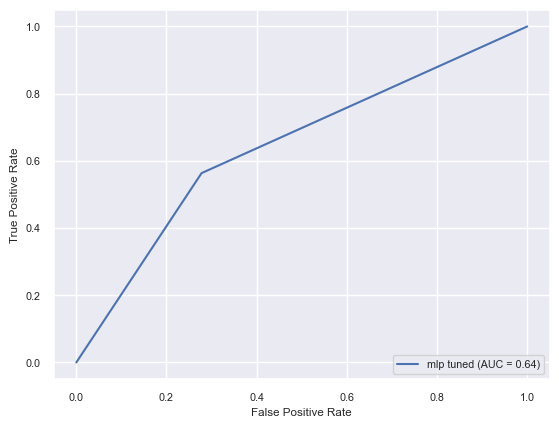

In [168]:
y_preds_mlp_tuned = mlp_grid.predict(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds_mlp_tuned)
roc_auc = metrics.auc(fpr,tpr)
display = metrics.RocCurveDisplay(fpr=fpr,
                                 tpr=tpr,
                                 roc_auc=roc_auc,
                                 estimator_name = 'mlp tuned')
display.plot();

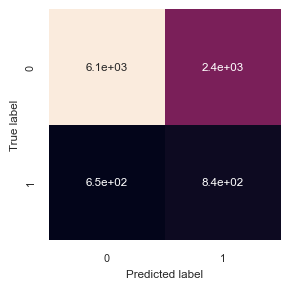

In [171]:
plot_conf_mat(y_test, y_preds_mlp_tuned)

In [169]:
joblib.dump(mlp_grid,'mlp_grid.joblib')

['mlp_grid.joblib']

The results show the model is still struggling to predict the booking complete when the actual result is booking complete. the type I error is too high (false posiotives). This is an improvement from previous models that never predicted true. 

In [147]:
clf_isolation = IsolationForest(max_samples=100, random_state=9)
clf_isolation.fit(x_train)

IsolationForest(max_samples=100, random_state=9)

In [148]:
x_test_predictions = clf_isolation.predict(x_test)

In [149]:
x_test_predictions = np.array(x_test_predictions)

In [150]:
# x_test_predictions[x_test_predictions == 1] = 0
x_test_predictions[x_test_predictions == -1] = 1

In [151]:
x_test_predictions

array([1, 1, 1, ..., 1, 1, 1])

In [152]:
np.array(np.unique(x_test_predictions, return_counts=True)).T

array([[    1, 10000]])

The Isolation Forest is not picking up on outliers in the data. going this route probably will not improve results.

In [ ]:
joblib.dump(clf_isolation,'clf_isolation.joblib')

## Conclusion
all the models struggle to seperate the two classes. Withouth the oversampling technique the model always predicted the majority class and was able to get a high accuracy score but the recall score was poor. After the over sampling technique the model did improve inpredicting the minority class but still not well. The best accuracy score came from the `RandomforestClassifier` and it still was scoring poorly in the minority class. The feature importance also showed very little correlation between any of the features and the classes. The model was never really sure. 